In [1]:
from tqdm import tqdm
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt


from numpy import asarray
from numpy import save

In [2]:
train_df = pd.read_csv('California Healthcare Foundation/trainLabels.csv')
train1_df =train_df[train_df.image != '43862_left']

In [3]:
train1_df.head(10)

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1
5,15_right,2
6,16_left,4
7,16_right,4
8,17_left,0
9,17_right,1


In [4]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    
    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking
    
    :return: A NumPy array containing the cropped image
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [5]:
def circle_crop1(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [6]:
def resize(image_pil, width, height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    ratio_w = width / image_pil.width
    ratio_h = height / image_pil.height
    if ratio_w < ratio_h:

        resize_width = width
        resize_height = round(ratio_w * image_pil.height)
    else:

        resize_width = round(ratio_h * image_pil.width)
        resize_height = height
    image_resize = image_pil.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (width, height), (0, 0, 0, 0)) #fondo negro o blanco
    offset = (round((width - resize_width) / 2), round((height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

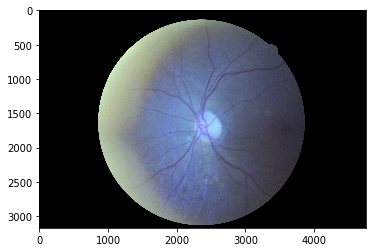

In [7]:
img=cv2.imread(f'California Healthcare Foundation/train/train 2/10_left.jpeg')
plt.imshow(img)

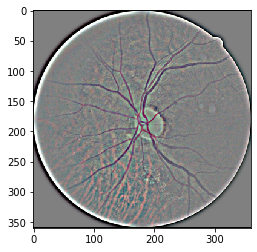

In [8]:
img = cv2.imread('California Healthcare Foundation/train/train 2/10_left.jpeg')
img=circle_crop1(img)
pilimage =Image.fromarray(img)
img =resize(pilimage,360,360)
    
plt.imshow(img)

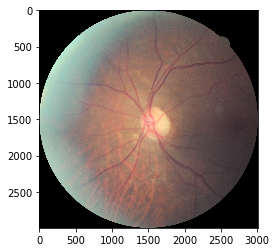

In [9]:
img = cv2.imread('California Healthcare Foundation/train/train 2/10_left.jpeg')
image = crop_image_from_gray(img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [11]:
from tqdm import tqdm
import os

DIR = 'California Healthcare Foundation/train/train 2'  #carpeta con el dataset ya preprocesado manualmente (sin imagenes repetidas o corruptas o que sean de un platillo diferente, etc)
DIR2 = 'California Healthcare Foundation/train/train-360-circle' #capeta destino que contiene sub-carpetas con los nombres objetivo del anterior código vacias o una copia de la carpta anterior

IMG_size = 360  # tamaño de la imagen, usualmente utilizo 80 0 124, porque los archivos .pickle o .npy son muy grandes y saturan la ram 
          # cuando los cargo en colab para realizar el entrenamiento

for i, image_id in enumerate(tqdm(train_df['image'])):
    img = cv2.imread(DIR+'/'+image_id+'.jpeg')
    img = circle_crop1(img)
    pilimage =Image.fromarray(img)
    img =resize(pilimage,IMG_size,IMG_size)
    img.save(DIR2+'/'+image_id+'.png')

 99%|█████████▉| 34714/35126 [33:08:15<12:28,  1.82s/it]   

AttributeError: 'NoneType' object has no attribute 'ndim'

In [10]:
newtrain_df =train_df[train_df.index > 34714]

In [11]:
from tqdm import tqdm
import os

DIR = 'California Healthcare Foundation/train/train 2'  #carpeta con el dataset ya preprocesado manualmente (sin imagenes repetidas o corruptas o que sean de un platillo diferente, etc)
DIR2 = 'California Healthcare Foundation/train/train-360-circle' #capeta destino que contiene sub-carpetas con los nombres objetivo del anterior código vacias o una copia de la carpta anterior

IMG_size = 360  # tamaño de la imagen, usualmente utilizo 80 0 124, porque los archivos .pickle o .npy son muy grandes y saturan la ram 
          # cuando los cargo en colab para realizar el entrenamiento

for i, image_id in enumerate(tqdm(newtrain_df['image'])):
    img = cv2.imread(DIR+'/'+image_id+'.jpeg')
    img = circle_crop1(img)
    pilimage =Image.fromarray(img)
    img =resize(pilimage,IMG_size,IMG_size)
    img.save(DIR2+'/'+image_id+'.png')

100%|██████████| 411/411 [29:24<00:00,  4.29s/it] 


In [10]:
train1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35125 entries, 0 to 35125
Data columns (total 2 columns):
image    35125 non-null object
level    35125 non-null int64
dtypes: int64(1), object(1)
memory usage: 823.2+ KB


In [13]:
IMG_SIZE= 360


DIR = 'California Healthcare Foundation/train/train-360-circle' #carpeta con los datos 

num_channels = 3 # canales, rgb, escala de grises
xtrain = np.zeros((35125, IMG_SIZE, IMG_SIZE, num_channels), dtype=np.uint8)


for i, image_id in enumerate(tqdm(train1_df['image'])):
    image = cv2.imread(f'California Healthcare Foundation/train/train-360-circle/{image_id}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    xtrain[i,:,:,:] = image

100%|██████████| 35125/35125 [12:46<00:00, 45.84it/s] 


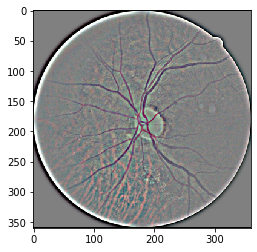

In [14]:
plt.imshow(xtrain[0])

In [15]:
from numpy import asarray
from numpy import save

data = asarray(xtrain)
save('California Healthcare Foundation/train/xtrainchf360c.npy', data)

In [ ]:
from tqdm import tqdm
import os

DIR = 'California Healthcare Foundation/train/train-360-circle'  #carpeta con el dataset ya preprocesado manualmente (sin imagenes repetidas o corruptas o que sean de un platillo diferente, etc)
DIR2 = 'California Healthcare Foundation/train/train-320-circle' #capeta destino que contiene sub-carpetas con los nombres objetivo del anterior código vacias o una copia de la carpta anterior

IMG_size = 320  # tamaño de la imagen, usualmente utilizo 80 0 124, porque los archivos .pickle o .npy son muy grandes y saturan la ram 
          # cuando los cargo en colab para realizar el entrenamiento

for i, image_id in enumerate(tqdm(train1_df['image'])):
    img = cv2.imread(DIR+'/'+image_id+'.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pilimage =Image.fromarray(img)
    img =resize(pilimage,IMG_size,IMG_size)
    img.save(DIR2+'/'+image_id+'.png')

 97%|█████████▋| 34124/35125 [1:34:03<04:28,  3.73it/s]  

In [13]:
newtrain_df1 = train1_df[train1_df.index > 34123]

In [14]:
from tqdm import tqdm
import os

DIR = 'California Healthcare Foundation/train/train-360-circle'  #carpeta con el dataset ya preprocesado manualmente (sin imagenes repetidas o corruptas o que sean de un platillo diferente, etc)
DIR2 = 'California Healthcare Foundation/train/train-320-circle' #capeta destino que contiene sub-carpetas con los nombres objetivo del anterior código vacias o una copia de la carpta anterior

IMG_size = 320  # tamaño de la imagen, usualmente utilizo 80 0 124, porque los archivos .pickle o .npy son muy grandes y saturan la ram 
          # cuando los cargo en colab para realizar el entrenamiento

for i, image_id in enumerate(tqdm(newtrain_df1['image'])):
    img = cv2.imread(DIR+'/'+image_id+'.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pilimage =Image.fromarray(img)
    img =resize(pilimage,IMG_size,IMG_size)
    img.save(DIR2+'/'+image_id+'.png')


 16%|█▌        | 156/1001 [00:25<01:50,  7.62it/s]


 32%|███▏      | 321/1001 [00:46<01:30,  7.54it/s]


 51%|█████▏    | 514/1001 [01:14<00:40, 11.99it/s]


 74%|███████▍  | 745/1001 [01:40<00:25, 10.11it/s]


 96%|█████████▋| 964/1001 [02:04<00:03, 10.77it/s]


100%|██████████| 1001/1001 [02:08<00:00,  7.78it/s]


In [18]:
from tqdm import tqdm
import os

DIR = 'California Healthcare Foundation/train/train-360-circle'  #carpeta con el dataset ya preprocesado manualmente (sin imagenes repetidas o corruptas o que sean de un platillo diferente, etc)
DIR2 = 'California Healthcare Foundation/train/train-128-c' #capeta destino que contiene sub-carpetas con los nombres objetivo del anterior código vacias o una copia de la carpta anterior

IMG_size = 128  # tamaño de la imagen, usualmente utilizo 80 0 124, porque los archivos .pickle o .npy son muy grandes y saturan la ram 
          # cuando los cargo en colab para realizar el entrenamiento

for i, image_id in enumerate(tqdm(train1_df['image'])):
    img = cv2.imread(DIR+'/'+image_id+'.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pilimage =Image.fromarray(img)
    img =resize(pilimage,IMG_size,IMG_size)
    img.save(DIR2+'/'+image_id+'.png')





  0%|          | 0/35125 [00:00<?, ?it/s]



  0%|          | 1/35125 [00:00<2:06:56,  4.61it/s]



  0%|          | 3/35125 [00:00<1:38:31,  5.94it/s]



  0%|          | 4/35125 [00:00<1:30:58,  6.43it/s]



  0%|          | 5/35125 [00:00<1:27:18,  6.70it/s]



  0%|          | 6/35125 [00:00<1:20:45,  7.25it/s]



  0%|          | 7/35125 [00:00<1:20:19,  7.29it/s]



  0%|          | 8/35125 [00:00<1:17:03,  7.60it/s]



  0%|          | 9/35125 [00:01<1:45:36,  5.54it/s]



  0%|          | 10/35125 [00:01<1:41:53,  5.74it/s]



  0%|          | 11/35125 [00:01<1:32:57,  6.30it/s]



  0%|          | 13/35125 [00:01<1:28:01,  6.65it/s]



  0%|          | 15/35125 [00:01<1:12:49,  8.04it/s]



  0%|          | 16/35125 [00:02<1:20:21,  7.28it/s]



  0%|          | 17/35125 [00:02<1:20:33,  7.26it/s]



  0%|          | 19/35125 [00:02<1:15:04,  7.79it/s]



  0%|          | 20/35125 [00:02<1:15:32,  7.75it/s]



  0%|          | 21/35125 [00:02<1:17:07,  7.59it/s]



  0%|  

  1%|          | 177/35125 [00:20<58:22,  9.98it/s]  



  1%|          | 179/35125 [00:20<1:02:22,  9.34it/s]



  1%|          | 180/35125 [00:20<1:09:12,  8.42it/s]



  1%|          | 182/35125 [00:20<57:54, 10.06it/s]  



  1%|          | 184/35125 [00:21<56:02, 10.39it/s]



  1%|          | 186/35125 [00:21<56:42, 10.27it/s]



  1%|          | 188/35125 [00:21<56:10, 10.36it/s]



  1%|          | 190/35125 [00:21<55:13, 10.54it/s]



  1%|          | 192/35125 [00:21<1:00:30,  9.62it/s]



  1%|          | 194/35125 [00:22<56:39, 10.28it/s]  



  1%|          | 196/35125 [00:22<55:45, 10.44it/s]



  1%|          | 198/35125 [00:22<53:08, 10.96it/s]



  1%|          | 200/35125 [00:22<56:13, 10.35it/s]



  1%|          | 202/35125 [00:22<49:59, 11.64it/s]



  1%|          | 204/35125 [00:22<55:05, 10.57it/s]



  1%|          | 207/35125 [00:23<47:34, 12.23it/s]



  1%|          | 209/35125 [00:23<49:45, 11.70it/s]



  1%|          | 211/35125 [00:23<49:33, 11.74it/s]



  1%|          | 408/35125 [00:44<1:03:50,  9.06it/s]



  1%|          | 409/35125 [00:44<1:08:37,  8.43it/s]



  1%|          | 410/35125 [00:44<1:13:34,  7.86it/s]



  1%|          | 411/35125 [00:44<1:17:53,  7.43it/s]



  1%|          | 412/35125 [00:44<1:19:30,  7.28it/s]



  1%|          | 414/35125 [00:44<1:07:26,  8.58it/s]



  1%|          | 415/35125 [00:44<1:04:53,  8.91it/s]



  1%|          | 416/35125 [00:44<1:02:57,  9.19it/s]



  1%|          | 417/35125 [00:45<1:04:32,  8.96it/s]



  1%|          | 418/35125 [00:45<1:16:13,  7.59it/s]



  1%|          | 419/35125 [00:45<1:12:15,  8.00it/s]



  1%|          | 420/35125 [00:45<1:11:06,  8.13it/s]



  1%|          | 421/35125 [00:45<1:14:50,  7.73it/s]



  1%|          | 422/35125 [00:45<1:16:04,  7.60it/s]



  1%|          | 424/35125 [00:45<1:08:34,  8.43it/s]



  1%|          | 425/35125 [00:46<1:06:50,  8.65it/s]



  1%|          | 426/35125 [00:46<1:29:25,  6.47it/s]



  1%|          | 428/35125 [00:

  2%|▏         | 631/35125 [01:08<46:16, 12.42it/s]



  2%|▏         | 633/35125 [01:08<41:45, 13.77it/s]



  2%|▏         | 635/35125 [01:08<41:36, 13.82it/s]



  2%|▏         | 637/35125 [01:08<50:14, 11.44it/s]



  2%|▏         | 639/35125 [01:08<51:24, 11.18it/s]



  2%|▏         | 641/35125 [01:08<50:21, 11.41it/s]



  2%|▏         | 643/35125 [01:09<50:53, 11.29it/s]



  2%|▏         | 645/35125 [01:09<52:51, 10.87it/s]



  2%|▏         | 647/35125 [01:09<49:04, 11.71it/s]



  2%|▏         | 649/35125 [01:09<51:08, 11.23it/s]



  2%|▏         | 651/35125 [01:09<47:27, 12.11it/s]



  2%|▏         | 653/35125 [01:09<52:21, 10.97it/s]



  2%|▏         | 655/35125 [01:10<51:21, 11.19it/s]



  2%|▏         | 657/35125 [01:10<1:00:36,  9.48it/s]



  2%|▏         | 659/35125 [01:10<54:26, 10.55it/s]  



  2%|▏         | 661/35125 [01:10<53:30, 10.73it/s]



  2%|▏         | 663/35125 [01:10<57:41,  9.95it/s]



  2%|▏         | 665/35125 [01:11<1:03:05,  9.10it/s]



  2%

  2%|▏         | 856/35125 [01:28<43:14, 13.21it/s]



  2%|▏         | 858/35125 [01:28<41:25, 13.79it/s]



  2%|▏         | 860/35125 [01:28<43:49, 13.03it/s]



  2%|▏         | 862/35125 [01:29<45:53, 12.44it/s]



  2%|▏         | 864/35125 [01:29<47:05, 12.13it/s]



  2%|▏         | 866/35125 [01:29<53:05, 10.75it/s]



  2%|▏         | 868/35125 [01:29<52:17, 10.92it/s]



  2%|▏         | 870/35125 [01:29<45:36, 12.52it/s]



  2%|▏         | 872/35125 [01:29<48:43, 11.72it/s]



  2%|▏         | 874/35125 [01:30<50:29, 11.31it/s]



  2%|▏         | 876/35125 [01:30<49:44, 11.47it/s]



  2%|▏         | 878/35125 [01:30<45:51, 12.45it/s]



  3%|▎         | 880/35125 [01:30<50:24, 11.32it/s]



  3%|▎         | 882/35125 [01:30<53:49, 10.60it/s]



  3%|▎         | 884/35125 [01:31<53:48, 10.60it/s]



  3%|▎         | 886/35125 [01:31<56:52, 10.03it/s]



  3%|▎         | 888/35125 [01:31<1:07:30,  8.45it/s]



  3%|▎         | 889/35125 [01:31<1:08:50,  8.29it/s]



  3%|▎

  3%|▎         | 1047/35125 [01:50<1:03:33,  8.94it/s]



  3%|▎         | 1049/35125 [01:50<58:43,  9.67it/s]  



  3%|▎         | 1051/35125 [01:50<59:53,  9.48it/s]



  3%|▎         | 1053/35125 [01:51<1:00:37,  9.37it/s]



  3%|▎         | 1054/35125 [01:51<1:02:21,  9.11it/s]



  3%|▎         | 1055/35125 [01:51<1:06:28,  8.54it/s]



  3%|▎         | 1057/35125 [01:51<57:19,  9.90it/s]  



  3%|▎         | 1059/35125 [01:51<56:17, 10.09it/s]



  3%|▎         | 1061/35125 [01:51<58:43,  9.67it/s]



  3%|▎         | 1063/35125 [01:52<1:08:49,  8.25it/s]



  3%|▎         | 1064/35125 [01:52<1:12:14,  7.86it/s]



  3%|▎         | 1065/35125 [01:52<1:11:08,  7.98it/s]



  3%|▎         | 1067/35125 [01:52<1:04:08,  8.85it/s]



  3%|▎         | 1068/35125 [01:52<1:24:54,  6.68it/s]



  3%|▎         | 1070/35125 [01:53<1:11:25,  7.95it/s]



  3%|▎         | 1071/35125 [01:53<1:09:19,  8.19it/s]



  3%|▎         | 1072/35125 [01:53<1:13:23,  7.73it/s]



  3%|▎         | 107

  4%|▎         | 1236/35125 [02:13<1:10:15,  8.04it/s]



  4%|▎         | 1238/35125 [02:14<1:39:53,  5.65it/s]



  4%|▎         | 1240/35125 [02:14<1:26:26,  6.53it/s]



  4%|▎         | 1241/35125 [02:14<1:21:48,  6.90it/s]



  4%|▎         | 1242/35125 [02:15<1:25:35,  6.60it/s]



  4%|▎         | 1243/35125 [02:15<1:24:05,  6.71it/s]



  4%|▎         | 1245/35125 [02:15<1:16:24,  7.39it/s]



  4%|▎         | 1247/35125 [02:15<1:08:31,  8.24it/s]



  4%|▎         | 1248/35125 [02:15<1:11:49,  7.86it/s]



  4%|▎         | 1250/35125 [02:15<1:05:35,  8.61it/s]



  4%|▎         | 1251/35125 [02:16<1:06:41,  8.47it/s]



  4%|▎         | 1253/35125 [02:16<1:06:33,  8.48it/s]



  4%|▎         | 1254/35125 [02:16<1:09:51,  8.08it/s]



  4%|▎         | 1255/35125 [02:16<1:08:17,  8.27it/s]



  4%|▎         | 1256/35125 [02:16<1:05:44,  8.59it/s]



  4%|▎         | 1257/35125 [02:16<1:07:36,  8.35it/s]



  4%|▎         | 1258/35125 [02:16<1:08:56,  8.19it/s]



  4%|▎        

  4%|▍         | 1439/35125 [02:39<1:17:00,  7.29it/s]



  4%|▍         | 1440/35125 [02:39<1:14:50,  7.50it/s]



  4%|▍         | 1441/35125 [02:39<1:11:41,  7.83it/s]



  4%|▍         | 1442/35125 [02:39<1:08:09,  8.24it/s]



  4%|▍         | 1444/35125 [02:40<1:05:16,  8.60it/s]



  4%|▍         | 1445/35125 [02:40<1:10:38,  7.95it/s]



  4%|▍         | 1446/35125 [02:40<1:12:52,  7.70it/s]



  4%|▍         | 1447/35125 [02:40<1:08:07,  8.24it/s]



  4%|▍         | 1448/35125 [02:40<1:06:18,  8.47it/s]



  4%|▍         | 1450/35125 [02:40<1:00:42,  9.24it/s]



  4%|▍         | 1451/35125 [02:40<1:07:02,  8.37it/s]



  4%|▍         | 1452/35125 [02:41<1:05:08,  8.62it/s]



  4%|▍         | 1453/35125 [02:41<1:04:18,  8.73it/s]



  4%|▍         | 1454/35125 [02:41<1:08:20,  8.21it/s]



  4%|▍         | 1456/35125 [02:41<1:14:37,  7.52it/s]



  4%|▍         | 1457/35125 [02:41<1:11:20,  7.87it/s]



  4%|▍         | 1458/35125 [02:41<1:38:37,  5.69it/s]



  4%|▍        

  5%|▍         | 1615/35125 [02:59<1:04:51,  8.61it/s]



  5%|▍         | 1617/35125 [03:00<1:00:32,  9.23it/s]



  5%|▍         | 1619/35125 [03:00<59:27,  9.39it/s]  



  5%|▍         | 1621/35125 [03:00<59:27,  9.39it/s]



  5%|▍         | 1622/35125 [03:00<1:01:22,  9.10it/s]



  5%|▍         | 1623/35125 [03:00<1:01:37,  9.06it/s]



  5%|▍         | 1625/35125 [03:00<57:50,  9.65it/s]  



  5%|▍         | 1626/35125 [03:00<58:51,  9.48it/s]



  5%|▍         | 1627/35125 [03:01<59:42,  9.35it/s]



  5%|▍         | 1629/35125 [03:01<57:10,  9.76it/s]



  5%|▍         | 1631/35125 [03:01<52:36, 10.61it/s]



  5%|▍         | 1633/35125 [03:01<52:45, 10.58it/s]



  5%|▍         | 1635/35125 [03:01<53:14, 10.48it/s]



  5%|▍         | 1637/35125 [03:01<49:08, 11.36it/s]



  5%|▍         | 1639/35125 [03:02<50:23, 11.07it/s]



  5%|▍         | 1641/35125 [03:02<45:38, 12.23it/s]



  5%|▍         | 1643/35125 [03:02<51:17, 10.88it/s]



  5%|▍         | 1645/35125 [03:02<5

  5%|▌         | 1798/35125 [03:19<1:09:02,  8.05it/s]



  5%|▌         | 1800/35125 [03:19<1:02:24,  8.90it/s]



  5%|▌         | 1802/35125 [03:20<1:03:05,  8.80it/s]



  5%|▌         | 1804/35125 [03:20<1:03:19,  8.77it/s]



  5%|▌         | 1805/35125 [03:20<1:08:48,  8.07it/s]



  5%|▌         | 1806/35125 [03:20<1:06:29,  8.35it/s]



  5%|▌         | 1807/35125 [03:20<1:06:53,  8.30it/s]



  5%|▌         | 1809/35125 [03:20<1:03:33,  8.74it/s]



  5%|▌         | 1810/35125 [03:21<1:06:04,  8.40it/s]



  5%|▌         | 1812/35125 [03:21<59:52,  9.27it/s]  



  5%|▌         | 1813/35125 [03:21<59:30,  9.33it/s]



  5%|▌         | 1815/35125 [03:21<1:02:58,  8.82it/s]



  5%|▌         | 1817/35125 [03:21<59:46,  9.29it/s]  



  5%|▌         | 1818/35125 [03:21<1:02:09,  8.93it/s]



  5%|▌         | 1819/35125 [03:22<1:01:43,  8.99it/s]



  5%|▌         | 1820/35125 [03:22<1:03:53,  8.69it/s]



  5%|▌         | 1821/35125 [03:22<1:02:31,  8.88it/s]



  5%|▌         |

  6%|▌         | 2012/35125 [03:40<47:47, 11.55it/s]



  6%|▌         | 2014/35125 [03:40<46:41, 11.82it/s]



  6%|▌         | 2016/35125 [03:40<47:52, 11.53it/s]



  6%|▌         | 2018/35125 [03:41<51:34, 10.70it/s]



  6%|▌         | 2020/35125 [03:41<52:43, 10.46it/s]



  6%|▌         | 2022/35125 [03:41<49:20, 11.18it/s]



  6%|▌         | 2024/35125 [03:41<56:03,  9.84it/s]



  6%|▌         | 2026/35125 [03:41<1:00:05,  9.18it/s]



  6%|▌         | 2027/35125 [03:42<1:16:24,  7.22it/s]



  6%|▌         | 2029/35125 [03:42<1:04:25,  8.56it/s]



  6%|▌         | 2031/35125 [03:42<1:05:32,  8.42it/s]



  6%|▌         | 2033/35125 [03:42<55:46,  9.89it/s]  



  6%|▌         | 2035/35125 [03:42<55:39,  9.91it/s]



  6%|▌         | 2037/35125 [03:43<1:00:47,  9.07it/s]



  6%|▌         | 2039/35125 [03:43<52:29, 10.50it/s]  



  6%|▌         | 2041/35125 [03:43<1:03:06,  8.74it/s]



  6%|▌         | 2043/35125 [03:43<1:06:16,  8.32it/s]



  6%|▌         | 2044/35125 [0

  6%|▋         | 2205/35125 [04:01<41:55, 13.09it/s]



  6%|▋         | 2207/35125 [04:01<45:20, 12.10it/s]



  6%|▋         | 2209/35125 [04:01<41:49, 13.12it/s]



  6%|▋         | 2211/35125 [04:01<42:54, 12.78it/s]



  6%|▋         | 2213/35125 [04:01<44:57, 12.20it/s]



  6%|▋         | 2215/35125 [04:02<52:05, 10.53it/s]



  6%|▋         | 2217/35125 [04:02<48:39, 11.27it/s]



  6%|▋         | 2219/35125 [04:02<48:58, 11.20it/s]



  6%|▋         | 2221/35125 [04:02<44:38, 12.29it/s]



  6%|▋         | 2224/35125 [04:02<41:46, 13.12it/s]



  6%|▋         | 2226/35125 [04:02<41:09, 13.32it/s]



  6%|▋         | 2228/35125 [04:03<49:09, 11.15it/s]



  6%|▋         | 2230/35125 [04:03<49:03, 11.17it/s]



  6%|▋         | 2232/35125 [04:03<45:37, 12.01it/s]



  6%|▋         | 2234/35125 [04:03<53:18, 10.28it/s]



  6%|▋         | 2236/35125 [04:03<55:11,  9.93it/s]



  6%|▋         | 2238/35125 [04:04<51:43, 10.60it/s]



  6%|▋         | 2240/35125 [04:04<1:16:07,  7.2

  7%|▋         | 2448/35125 [04:21<43:09, 12.62it/s]



  7%|▋         | 2450/35125 [04:21<42:16, 12.88it/s]



  7%|▋         | 2452/35125 [04:21<42:45, 12.74it/s]



  7%|▋         | 2454/35125 [04:22<45:49, 11.88it/s]



  7%|▋         | 2456/35125 [04:22<44:27, 12.25it/s]



  7%|▋         | 2458/35125 [04:22<42:44, 12.74it/s]



  7%|▋         | 2460/35125 [04:22<42:37, 12.77it/s]



  7%|▋         | 2462/35125 [04:22<42:58, 12.67it/s]



  7%|▋         | 2464/35125 [04:22<41:36, 13.08it/s]



  7%|▋         | 2466/35125 [04:23<41:55, 12.99it/s]



  7%|▋         | 2468/35125 [04:23<38:18, 14.21it/s]



  7%|▋         | 2470/35125 [04:23<35:52, 15.17it/s]



  7%|▋         | 2472/35125 [04:23<41:01, 13.27it/s]



  7%|▋         | 2474/35125 [04:23<46:18, 11.75it/s]



  7%|▋         | 2476/35125 [04:23<49:08, 11.07it/s]



  7%|▋         | 2478/35125 [04:24<46:43, 11.65it/s]



  7%|▋         | 2480/35125 [04:24<45:46, 11.89it/s]



  7%|▋         | 2482/35125 [04:24<43:53, 12.39i

  8%|▊         | 2647/35125 [04:43<1:04:55,  8.34it/s]



  8%|▊         | 2648/35125 [04:44<1:07:01,  8.08it/s]



  8%|▊         | 2649/35125 [04:44<1:06:58,  8.08it/s]



  8%|▊         | 2651/35125 [04:44<1:04:46,  8.35it/s]



  8%|▊         | 2653/35125 [04:44<55:21,  9.78it/s]  



  8%|▊         | 2655/35125 [04:44<58:58,  9.18it/s]



  8%|▊         | 2656/35125 [04:44<1:02:25,  8.67it/s]



  8%|▊         | 2658/35125 [04:45<1:03:15,  8.55it/s]



  8%|▊         | 2659/35125 [04:45<1:03:39,  8.50it/s]



  8%|▊         | 2660/35125 [04:45<1:02:34,  8.65it/s]



  8%|▊         | 2662/35125 [04:45<54:53,  9.86it/s]  



  8%|▊         | 2664/35125 [04:45<53:51, 10.04it/s]



  8%|▊         | 2666/35125 [04:45<51:51, 10.43it/s]



  8%|▊         | 2668/35125 [04:45<49:22, 10.96it/s]



  8%|▊         | 2670/35125 [04:46<46:33, 11.62it/s]



  8%|▊         | 2672/35125 [04:46<40:55, 13.21it/s]



  8%|▊         | 2674/35125 [04:46<52:00, 10.40it/s]



  8%|▊         | 2676/35125 

  8%|▊         | 2878/35125 [05:04<1:05:54,  8.15it/s]



  8%|▊         | 2879/35125 [05:04<1:04:35,  8.32it/s]



  8%|▊         | 2880/35125 [05:05<1:04:54,  8.28it/s]



  8%|▊         | 2882/35125 [05:05<1:05:55,  8.15it/s]



  8%|▊         | 2884/35125 [05:05<1:03:11,  8.50it/s]



  8%|▊         | 2886/35125 [05:05<57:22,  9.37it/s]  



  8%|▊         | 2887/35125 [05:05<56:38,  9.49it/s]



  8%|▊         | 2889/35125 [05:05<53:13, 10.09it/s]



  8%|▊         | 2891/35125 [05:06<54:16,  9.90it/s]



  8%|▊         | 2893/35125 [05:06<59:45,  8.99it/s]



  8%|▊         | 2894/35125 [05:06<1:03:08,  8.51it/s]



  8%|▊         | 2895/35125 [05:06<1:00:23,  8.90it/s]



  8%|▊         | 2897/35125 [05:06<57:26,  9.35it/s]  



  8%|▊         | 2899/35125 [05:07<1:02:34,  8.58it/s]



  8%|▊         | 2900/35125 [05:07<1:00:15,  8.91it/s]



  8%|▊         | 2901/35125 [05:07<1:01:38,  8.71it/s]



  8%|▊         | 2902/35125 [05:07<1:54:25,  4.69it/s]



  8%|▊         | 2904/

  9%|▉         | 3097/35125 [05:25<46:31, 11.48it/s]



  9%|▉         | 3099/35125 [05:25<44:19, 12.04it/s]



  9%|▉         | 3101/35125 [05:25<43:01, 12.40it/s]



  9%|▉         | 3103/35125 [05:25<47:39, 11.20it/s]



  9%|▉         | 3105/35125 [05:25<51:49, 10.30it/s]



  9%|▉         | 3107/35125 [05:26<52:11, 10.22it/s]



  9%|▉         | 3109/35125 [05:26<52:40, 10.13it/s]



  9%|▉         | 3111/35125 [05:26<56:33,  9.43it/s]



  9%|▉         | 3113/35125 [05:26<51:48, 10.30it/s]



  9%|▉         | 3115/35125 [05:27<1:16:40,  6.96it/s]



  9%|▉         | 3117/35125 [05:27<1:04:39,  8.25it/s]



  9%|▉         | 3119/35125 [05:27<57:04,  9.35it/s]  



  9%|▉         | 3121/35125 [05:27<55:47,  9.56it/s]



  9%|▉         | 3123/35125 [05:27<53:55,  9.89it/s]



  9%|▉         | 3125/35125 [05:28<52:39, 10.13it/s]



  9%|▉         | 3127/35125 [05:28<52:45, 10.11it/s]



  9%|▉         | 3129/35125 [05:28<50:12, 10.62it/s]



  9%|▉         | 3131/35125 [05:28<50:51, 

  9%|▉         | 3329/35125 [05:46<48:09, 11.00it/s]



  9%|▉         | 3331/35125 [05:46<48:06, 11.01it/s]



  9%|▉         | 3333/35125 [05:47<43:13, 12.26it/s]



  9%|▉         | 3335/35125 [05:47<46:17, 11.45it/s]



 10%|▉         | 3337/35125 [05:47<48:25, 10.94it/s]



 10%|▉         | 3339/35125 [05:47<53:59,  9.81it/s]



 10%|▉         | 3342/35125 [05:47<45:30, 11.64it/s]



 10%|▉         | 3344/35125 [05:48<46:20, 11.43it/s]



 10%|▉         | 3346/35125 [05:48<46:40, 11.35it/s]



 10%|▉         | 3348/35125 [05:48<41:13, 12.85it/s]



 10%|▉         | 3350/35125 [05:48<42:10, 12.56it/s]



 10%|▉         | 3352/35125 [05:48<43:55, 12.06it/s]



 10%|▉         | 3354/35125 [05:48<40:09, 13.18it/s]



 10%|▉         | 3356/35125 [05:49<43:33, 12.16it/s]



 10%|▉         | 3358/35125 [05:49<48:55, 10.82it/s]



 10%|▉         | 3360/35125 [05:49<50:30, 10.48it/s]



 10%|▉         | 3362/35125 [05:49<50:11, 10.55it/s]



 10%|▉         | 3364/35125 [05:49<47:41, 11.10i

 10%|█         | 3574/35125 [06:07<37:24, 14.06it/s]



 10%|█         | 3576/35125 [06:07<37:08, 14.16it/s]



 10%|█         | 3578/35125 [06:07<46:11, 11.38it/s]



 10%|█         | 3580/35125 [06:07<46:34, 11.29it/s]



 10%|█         | 3582/35125 [06:08<48:21, 10.87it/s]



 10%|█         | 3584/35125 [06:08<51:37, 10.18it/s]



 10%|█         | 3586/35125 [06:08<53:29,  9.83it/s]



 10%|█         | 3588/35125 [06:08<49:10, 10.69it/s]



 10%|█         | 3590/35125 [06:08<51:49, 10.14it/s]



 10%|█         | 3592/35125 [06:08<45:08, 11.64it/s]



 10%|█         | 3594/35125 [06:09<47:21, 11.10it/s]



 10%|█         | 3596/35125 [06:09<45:06, 11.65it/s]



 10%|█         | 3598/35125 [06:09<47:35, 11.04it/s]



 10%|█         | 3600/35125 [06:09<46:15, 11.36it/s]



 10%|█         | 3602/35125 [06:09<48:25, 10.85it/s]



 10%|█         | 3604/35125 [06:10<52:24, 10.02it/s]



 10%|█         | 3606/35125 [06:10<47:23, 11.08it/s]



 10%|█         | 3608/35125 [06:10<43:48, 11.99i

 11%|█         | 3756/35125 [06:28<58:13,  8.98it/s]



 11%|█         | 3757/35125 [06:28<1:06:39,  7.84it/s]



 11%|█         | 3758/35125 [06:28<1:02:41,  8.34it/s]



 11%|█         | 3760/35125 [06:28<57:01,  9.17it/s]  



 11%|█         | 3762/35125 [06:28<53:07,  9.84it/s]



 11%|█         | 3764/35125 [06:28<50:09, 10.42it/s]



 11%|█         | 3766/35125 [06:28<45:25, 11.51it/s]



 11%|█         | 3768/35125 [06:29<1:03:49,  8.19it/s]



 11%|█         | 3769/35125 [06:29<1:09:32,  7.51it/s]



 11%|█         | 3770/35125 [06:29<1:13:55,  7.07it/s]



 11%|█         | 3772/35125 [06:29<1:00:19,  8.66it/s]



 11%|█         | 3774/35125 [06:29<52:19,  9.99it/s]  



 11%|█         | 3776/35125 [06:30<51:49, 10.08it/s]



 11%|█         | 3778/35125 [06:30<45:38, 11.45it/s]



 11%|█         | 3780/35125 [06:30<42:17, 12.35it/s]



 11%|█         | 3782/35125 [06:30<41:38, 12.54it/s]



 11%|█         | 3784/35125 [06:30<40:35, 12.87it/s]



 11%|█         | 3786/35125 [06:

 11%|█         | 3923/35125 [06:49<1:03:44,  8.16it/s]



 11%|█         | 3924/35125 [06:49<1:02:07,  8.37it/s]



 11%|█         | 3926/35125 [06:50<56:21,  9.23it/s]  



 11%|█         | 3927/35125 [06:50<56:34,  9.19it/s]



 11%|█         | 3928/35125 [06:50<58:18,  8.92it/s]



 11%|█         | 3930/35125 [06:50<1:01:03,  8.52it/s]



 11%|█         | 3931/35125 [06:50<1:03:52,  8.14it/s]



 11%|█         | 3933/35125 [06:50<1:04:45,  8.03it/s]



 11%|█         | 3934/35125 [06:51<1:07:05,  7.75it/s]



 11%|█         | 3935/35125 [06:51<1:09:25,  7.49it/s]



 11%|█         | 3936/35125 [06:51<1:08:56,  7.54it/s]



 11%|█         | 3937/35125 [06:51<1:12:52,  7.13it/s]



 11%|█         | 3938/35125 [06:51<1:18:45,  6.60it/s]



 11%|█         | 3940/35125 [06:51<1:07:20,  7.72it/s]



 11%|█         | 3941/35125 [06:51<1:10:16,  7.40it/s]



 11%|█         | 3942/35125 [06:52<1:08:49,  7.55it/s]



 11%|█         | 3943/35125 [06:52<1:17:51,  6.67it/s]



 11%|█         | 3

 12%|█▏        | 4143/35125 [07:09<43:18, 11.92it/s]



 12%|█▏        | 4145/35125 [07:09<43:47, 11.79it/s]



 12%|█▏        | 4147/35125 [07:09<44:15, 11.67it/s]



 12%|█▏        | 4149/35125 [07:09<42:46, 12.07it/s]



 12%|█▏        | 4151/35125 [07:10<43:10, 11.96it/s]



 12%|█▏        | 4153/35125 [07:10<38:09, 13.53it/s]



 12%|█▏        | 4155/35125 [07:10<34:43, 14.87it/s]



 12%|█▏        | 4157/35125 [07:10<38:04, 13.55it/s]



 12%|█▏        | 4159/35125 [07:10<41:17, 12.50it/s]



 12%|█▏        | 4161/35125 [07:10<44:21, 11.63it/s]



 12%|█▏        | 4163/35125 [07:11<43:46, 11.79it/s]



 12%|█▏        | 4166/35125 [07:11<36:47, 14.02it/s]



 12%|█▏        | 4168/35125 [07:11<36:13, 14.24it/s]



 12%|█▏        | 4170/35125 [07:11<43:19, 11.91it/s]



 12%|█▏        | 4172/35125 [07:11<48:19, 10.68it/s]



 12%|█▏        | 4174/35125 [07:11<46:43, 11.04it/s]



 12%|█▏        | 4176/35125 [07:12<52:42,  9.79it/s]



 12%|█▏        | 4178/35125 [07:12<54:26,  9.47i

 12%|█▏        | 4380/35125 [07:29<41:21, 12.39it/s]



 12%|█▏        | 4382/35125 [07:29<39:18, 13.03it/s]



 12%|█▏        | 4384/35125 [07:29<40:10, 12.75it/s]



 12%|█▏        | 4386/35125 [07:29<41:31, 12.34it/s]



 12%|█▏        | 4388/35125 [07:30<39:33, 12.95it/s]



 12%|█▏        | 4390/35125 [07:30<36:16, 14.12it/s]



 13%|█▎        | 4392/35125 [07:30<34:57, 14.65it/s]



 13%|█▎        | 4394/35125 [07:30<37:05, 13.81it/s]



 13%|█▎        | 4396/35125 [07:30<38:49, 13.19it/s]



 13%|█▎        | 4398/35125 [07:30<42:34, 12.03it/s]



 13%|█▎        | 4400/35125 [07:30<42:30, 12.05it/s]



 13%|█▎        | 4402/35125 [07:31<53:52,  9.50it/s]



 13%|█▎        | 4404/35125 [07:31<55:18,  9.26it/s]



 13%|█▎        | 4406/35125 [07:31<54:01,  9.48it/s]



 13%|█▎        | 4408/35125 [07:31<51:31,  9.94it/s]



 13%|█▎        | 4410/35125 [07:32<50:08, 10.21it/s]



 13%|█▎        | 4412/35125 [07:32<46:32, 11.00it/s]



 13%|█▎        | 4414/35125 [07:32<45:21, 11.28i

 13%|█▎        | 4597/35125 [07:49<41:44, 12.19it/s]



 13%|█▎        | 4599/35125 [07:50<42:22, 12.00it/s]



 13%|█▎        | 4601/35125 [07:50<48:41, 10.45it/s]



 13%|█▎        | 4603/35125 [07:50<47:08, 10.79it/s]



 13%|█▎        | 4605/35125 [07:50<47:58, 10.60it/s]



 13%|█▎        | 4607/35125 [07:50<44:19, 11.48it/s]



 13%|█▎        | 4609/35125 [07:51<46:12, 11.01it/s]



 13%|█▎        | 4611/35125 [07:51<54:00,  9.42it/s]



 13%|█▎        | 4613/35125 [07:51<53:02,  9.59it/s]



 13%|█▎        | 4615/35125 [07:51<51:15,  9.92it/s]



 13%|█▎        | 4617/35125 [07:51<57:41,  8.81it/s]



 13%|█▎        | 4619/35125 [07:52<1:00:50,  8.36it/s]



 13%|█▎        | 4621/35125 [07:52<55:36,  9.14it/s]  



 13%|█▎        | 4622/35125 [07:52<58:37,  8.67it/s]



 13%|█▎        | 4623/35125 [07:52<57:52,  8.78it/s]



 13%|█▎        | 4625/35125 [07:52<51:14,  9.92it/s]



 13%|█▎        | 4627/35125 [07:52<47:13, 10.76it/s]



 13%|█▎        | 4629/35125 [07:53<48:09, 10

 14%|█▎        | 4822/35125 [08:10<43:51, 11.52it/s]



 14%|█▎        | 4824/35125 [08:11<45:01, 11.21it/s]



 14%|█▎        | 4826/35125 [08:11<44:56, 11.24it/s]



 14%|█▎        | 4828/35125 [08:11<42:13, 11.96it/s]



 14%|█▍        | 4830/35125 [08:11<57:24,  8.79it/s]



 14%|█▍        | 4832/35125 [08:11<56:46,  8.89it/s]



 14%|█▍        | 4833/35125 [08:12<1:06:35,  7.58it/s]



 14%|█▍        | 4834/35125 [08:12<1:06:33,  7.59it/s]



 14%|█▍        | 4835/35125 [08:12<1:02:43,  8.05it/s]



 14%|█▍        | 4836/35125 [08:12<1:02:50,  8.03it/s]



 14%|█▍        | 4837/35125 [08:12<1:05:54,  7.66it/s]



 14%|█▍        | 4838/35125 [08:12<1:03:59,  7.89it/s]



 14%|█▍        | 4839/35125 [08:12<1:00:12,  8.38it/s]



 14%|█▍        | 4840/35125 [08:12<1:00:58,  8.28it/s]



 14%|█▍        | 4841/35125 [08:13<1:01:36,  8.19it/s]



 14%|█▍        | 4842/35125 [08:13<1:02:47,  8.04it/s]



 14%|█▍        | 4843/35125 [08:13<1:04:03,  7.88it/s]



 14%|█▍        | 4844/3512

 14%|█▍        | 5034/35125 [08:30<41:12, 12.17it/s]



 14%|█▍        | 5036/35125 [08:30<40:51, 12.28it/s]



 14%|█▍        | 5038/35125 [08:30<40:16, 12.45it/s]



 14%|█▍        | 5040/35125 [08:30<40:52, 12.27it/s]



 14%|█▍        | 5042/35125 [08:31<43:31, 11.52it/s]



 14%|█▍        | 5044/35125 [08:31<41:27, 12.09it/s]



 14%|█▍        | 5046/35125 [08:31<41:45, 12.01it/s]



 14%|█▍        | 5048/35125 [08:31<41:55, 11.95it/s]



 14%|█▍        | 5050/35125 [08:31<41:13, 12.16it/s]



 14%|█▍        | 5052/35125 [08:31<40:57, 12.24it/s]



 14%|█▍        | 5054/35125 [08:32<42:00, 11.93it/s]



 14%|█▍        | 5056/35125 [08:32<39:36, 12.66it/s]



 14%|█▍        | 5058/35125 [08:32<42:44, 11.72it/s]



 14%|█▍        | 5060/35125 [08:32<42:20, 11.84it/s]



 14%|█▍        | 5062/35125 [08:32<41:38, 12.03it/s]



 14%|█▍        | 5064/35125 [08:32<41:35, 12.05it/s]



 14%|█▍        | 5066/35125 [08:33<45:09, 11.10it/s]



 14%|█▍        | 5068/35125 [08:33<43:18, 11.57i

 15%|█▍        | 5267/35125 [08:50<39:07, 12.72it/s]



 15%|█▌        | 5269/35125 [08:50<40:55, 12.16it/s]



 15%|█▌        | 5271/35125 [08:51<54:39,  9.10it/s]



 15%|█▌        | 5273/35125 [08:51<55:10,  9.02it/s]



 15%|█▌        | 5274/35125 [08:51<54:52,  9.07it/s]



 15%|█▌        | 5275/35125 [08:51<57:59,  8.58it/s]



 15%|█▌        | 5276/35125 [08:51<1:07:03,  7.42it/s]



 15%|█▌        | 5278/35125 [08:52<1:09:21,  7.17it/s]



 15%|█▌        | 5279/35125 [08:52<1:29:59,  5.53it/s]



 15%|█▌        | 5281/35125 [08:52<1:12:22,  6.87it/s]



 15%|█▌        | 5283/35125 [08:52<1:05:34,  7.59it/s]



 15%|█▌        | 5284/35125 [08:53<1:07:36,  7.36it/s]



 15%|█▌        | 5285/35125 [08:53<1:02:50,  7.91it/s]



 15%|█▌        | 5287/35125 [08:53<55:02,  9.04it/s]  



 15%|█▌        | 5289/35125 [08:53<55:57,  8.89it/s]



 15%|█▌        | 5290/35125 [08:53<1:02:16,  7.99it/s]



 15%|█▌        | 5291/35125 [08:53<1:03:29,  7.83it/s]



 15%|█▌        | 5292/35125 

 16%|█▌        | 5491/35125 [09:12<50:40,  9.75it/s]



 16%|█▌        | 5493/35125 [09:12<46:06, 10.71it/s]



 16%|█▌        | 5495/35125 [09:12<45:16, 10.91it/s]



 16%|█▌        | 5497/35125 [09:12<51:36,  9.57it/s]



 16%|█▌        | 5499/35125 [09:13<53:16,  9.27it/s]



 16%|█▌        | 5501/35125 [09:13<54:18,  9.09it/s]



 16%|█▌        | 5503/35125 [09:13<53:10,  9.28it/s]



 16%|█▌        | 5504/35125 [09:13<54:04,  9.13it/s]



 16%|█▌        | 5506/35125 [09:13<52:42,  9.37it/s]



 16%|█▌        | 5507/35125 [09:13<1:03:10,  7.81it/s]



 16%|█▌        | 5509/35125 [09:14<55:41,  8.86it/s]  



 16%|█▌        | 5511/35125 [09:14<56:17,  8.77it/s]



 16%|█▌        | 5512/35125 [09:14<56:31,  8.73it/s]



 16%|█▌        | 5514/35125 [09:14<53:10,  9.28it/s]



 16%|█▌        | 5515/35125 [09:14<1:02:33,  7.89it/s]



 16%|█▌        | 5516/35125 [09:14<1:05:08,  7.58it/s]



 16%|█▌        | 5518/35125 [09:15<56:09,  8.79it/s]  



 16%|█▌        | 5519/35125 [09:15<54:

 16%|█▋        | 5721/35125 [09:33<59:43,  8.20it/s]  



 16%|█▋        | 5722/35125 [09:33<1:01:23,  7.98it/s]



 16%|█▋        | 5723/35125 [09:33<1:02:18,  7.86it/s]



 16%|█▋        | 5724/35125 [09:34<1:05:03,  7.53it/s]



 16%|█▋        | 5725/35125 [09:34<1:04:18,  7.62it/s]



 16%|█▋        | 5726/35125 [09:34<1:18:28,  6.24it/s]



 16%|█▋        | 5727/35125 [09:34<1:16:47,  6.38it/s]



 16%|█▋        | 5728/35125 [09:34<1:13:11,  6.69it/s]



 16%|█▋        | 5730/35125 [09:34<1:08:23,  7.16it/s]



 16%|█▋        | 5732/35125 [09:35<59:23,  8.25it/s]  



 16%|█▋        | 5733/35125 [09:35<1:01:49,  7.92it/s]



 16%|█▋        | 5734/35125 [09:35<1:01:34,  7.95it/s]



 16%|█▋        | 5735/35125 [09:35<1:13:38,  6.65it/s]



 16%|█▋        | 5737/35125 [09:35<1:06:25,  7.37it/s]



 16%|█▋        | 5738/35125 [09:35<1:20:01,  6.12it/s]



 16%|█▋        | 5739/35125 [09:36<1:12:12,  6.78it/s]



 16%|█▋        | 5740/35125 [09:36<1:10:48,  6.92it/s]



 16%|█▋       

 17%|█▋        | 5910/35125 [09:52<24:38, 19.76it/s]



 17%|█▋        | 5913/35125 [09:52<24:54, 19.55it/s]



 17%|█▋        | 5915/35125 [09:52<27:23, 17.77it/s]



 17%|█▋        | 5918/35125 [09:53<26:21, 18.47it/s]



 17%|█▋        | 5921/35125 [09:53<24:51, 19.58it/s]



 17%|█▋        | 5924/35125 [09:53<22:59, 21.17it/s]



 17%|█▋        | 5927/35125 [09:53<26:07, 18.63it/s]



 17%|█▋        | 5929/35125 [09:53<27:00, 18.02it/s]



 17%|█▋        | 5931/35125 [09:53<27:42, 17.56it/s]



 17%|█▋        | 5933/35125 [09:53<27:04, 17.97it/s]



 17%|█▋        | 5935/35125 [09:53<30:41, 15.85it/s]



 17%|█▋        | 5938/35125 [09:54<30:06, 16.15it/s]



 17%|█▋        | 5940/35125 [09:54<30:29, 15.96it/s]



 17%|█▋        | 5943/35125 [09:54<28:00, 17.36it/s]



 17%|█▋        | 5947/35125 [09:54<24:20, 19.97it/s]



 17%|█▋        | 5950/35125 [09:54<21:57, 22.15it/s]



 17%|█▋        | 5953/35125 [09:54<21:43, 22.38it/s]



 17%|█▋        | 5956/35125 [09:54<21:16, 22.85i

 18%|█▊        | 6231/35125 [10:09<25:14, 19.08it/s]



 18%|█▊        | 6234/35125 [10:09<25:20, 19.00it/s]



 18%|█▊        | 6236/35125 [10:09<31:27, 15.30it/s]



 18%|█▊        | 6239/35125 [10:10<27:54, 17.25it/s]



 18%|█▊        | 6241/35125 [10:10<26:52, 17.91it/s]



 18%|█▊        | 6243/35125 [10:10<27:43, 17.37it/s]



 18%|█▊        | 6246/35125 [10:10<27:04, 17.77it/s]



 18%|█▊        | 6249/35125 [10:10<26:39, 18.05it/s]



 18%|█▊        | 6252/35125 [10:10<25:48, 18.65it/s]



 18%|█▊        | 6255/35125 [10:10<27:17, 17.63it/s]



 18%|█▊        | 6257/35125 [10:11<26:29, 18.16it/s]



 18%|█▊        | 6259/35125 [10:11<27:26, 17.54it/s]



 18%|█▊        | 6261/35125 [10:11<29:40, 16.21it/s]



 18%|█▊        | 6263/35125 [10:11<28:29, 16.88it/s]



 18%|█▊        | 6265/35125 [10:11<43:05, 11.16it/s]



 18%|█▊        | 6267/35125 [10:11<41:22, 11.63it/s]



 18%|█▊        | 6269/35125 [10:11<37:02, 12.98it/s]



 18%|█▊        | 6271/35125 [10:12<37:17, 12.90i

 19%|█▊        | 6535/35125 [10:27<23:59, 19.87it/s]



 19%|█▊        | 6538/35125 [10:27<23:11, 20.55it/s]



 19%|█▊        | 6541/35125 [10:27<22:24, 21.27it/s]



 19%|█▊        | 6544/35125 [10:28<21:47, 21.86it/s]



 19%|█▊        | 6547/35125 [10:28<23:01, 20.69it/s]



 19%|█▊        | 6550/35125 [10:28<23:50, 19.97it/s]



 19%|█▊        | 6553/35125 [10:28<22:26, 21.22it/s]



 19%|█▊        | 6556/35125 [10:28<22:59, 20.70it/s]



 19%|█▊        | 6559/35125 [10:28<23:04, 20.63it/s]



 19%|█▊        | 6562/35125 [10:28<23:21, 20.38it/s]



 19%|█▊        | 6565/35125 [10:29<28:02, 16.98it/s]



 19%|█▊        | 6568/35125 [10:29<26:27, 17.98it/s]



 19%|█▊        | 6571/35125 [10:29<25:26, 18.70it/s]



 19%|█▊        | 6574/35125 [10:29<26:00, 18.30it/s]



 19%|█▊        | 6577/35125 [10:29<25:34, 18.60it/s]



 19%|█▊        | 6580/35125 [10:29<24:42, 19.26it/s]



 19%|█▊        | 6582/35125 [10:30<24:44, 19.22it/s]



 19%|█▊        | 6585/35125 [10:30<23:15, 20.45i

 20%|█▉        | 6858/35125 [10:46<22:33, 20.89it/s]



 20%|█▉        | 6861/35125 [10:46<23:14, 20.26it/s]



 20%|█▉        | 6864/35125 [10:46<21:25, 21.98it/s]



 20%|█▉        | 6867/35125 [10:46<20:19, 23.18it/s]



 20%|█▉        | 6870/35125 [10:46<22:07, 21.29it/s]



 20%|█▉        | 6873/35125 [10:46<23:26, 20.08it/s]



 20%|█▉        | 6876/35125 [10:46<22:41, 20.75it/s]



 20%|█▉        | 6879/35125 [10:47<22:46, 20.67it/s]



 20%|█▉        | 6882/35125 [10:47<24:42, 19.05it/s]



 20%|█▉        | 6885/35125 [10:47<23:24, 20.11it/s]



 20%|█▉        | 6888/35125 [10:47<21:57, 21.43it/s]



 20%|█▉        | 6891/35125 [10:47<23:13, 20.25it/s]



 20%|█▉        | 6894/35125 [10:47<22:58, 20.48it/s]



 20%|█▉        | 6897/35125 [10:48<22:55, 20.52it/s]



 20%|█▉        | 6900/35125 [10:48<24:25, 19.26it/s]



 20%|█▉        | 6903/35125 [10:48<23:00, 20.44it/s]



 20%|█▉        | 6906/35125 [10:48<23:28, 20.04it/s]



 20%|█▉        | 6909/35125 [10:48<23:17, 20.19i

 20%|██        | 7177/35125 [11:04<41:17, 11.28it/s]



 20%|██        | 7179/35125 [11:04<38:13, 12.18it/s]



 20%|██        | 7181/35125 [11:04<37:17, 12.49it/s]



 20%|██        | 7183/35125 [11:04<43:15, 10.76it/s]



 20%|██        | 7185/35125 [11:04<39:14, 11.87it/s]



 20%|██        | 7187/35125 [11:04<39:25, 11.81it/s]



 20%|██        | 7189/35125 [11:05<58:15,  7.99it/s]



 20%|██        | 7191/35125 [11:05<58:25,  7.97it/s]



 20%|██        | 7193/35125 [11:05<54:03,  8.61it/s]



 20%|██        | 7194/35125 [11:05<56:00,  8.31it/s]



 20%|██        | 7195/35125 [11:06<57:48,  8.05it/s]



 20%|██        | 7197/35125 [11:06<56:33,  8.23it/s]



 20%|██        | 7198/35125 [11:06<1:01:23,  7.58it/s]



 20%|██        | 7199/35125 [11:06<1:01:47,  7.53it/s]



 20%|██        | 7200/35125 [11:06<1:00:57,  7.64it/s]



 21%|██        | 7202/35125 [11:06<53:29,  8.70it/s]  



 21%|██        | 7203/35125 [11:07<57:44,  8.06it/s]



 21%|██        | 7205/35125 [11:07<52:41

 21%|██        | 7424/35125 [11:24<26:40, 17.31it/s]



 21%|██        | 7426/35125 [11:24<26:56, 17.13it/s]



 21%|██        | 7429/35125 [11:24<25:08, 18.36it/s]



 21%|██        | 7432/35125 [11:24<24:04, 19.17it/s]



 21%|██        | 7435/35125 [11:24<25:30, 18.09it/s]



 21%|██        | 7437/35125 [11:24<27:59, 16.49it/s]



 21%|██        | 7440/35125 [11:24<25:17, 18.24it/s]



 21%|██        | 7442/35125 [11:25<24:57, 18.49it/s]



 21%|██        | 7444/35125 [11:25<29:04, 15.87it/s]



 21%|██        | 7446/35125 [11:25<31:40, 14.57it/s]



 21%|██        | 7448/35125 [11:25<31:51, 14.48it/s]



 21%|██        | 7450/35125 [11:25<33:28, 13.78it/s]



 21%|██        | 7453/35125 [11:25<32:15, 14.30it/s]



 21%|██        | 7455/35125 [11:25<29:51, 15.44it/s]



 21%|██        | 7458/35125 [11:26<26:55, 17.13it/s]



 21%|██        | 7460/35125 [11:26<26:14, 17.57it/s]



 21%|██        | 7462/35125 [11:26<25:44, 17.91it/s]



 21%|██        | 7464/35125 [11:26<25:32, 18.05i

 22%|██▏       | 7621/35125 [11:45<1:17:39,  5.90it/s]



 22%|██▏       | 7622/35125 [11:45<1:23:30,  5.49it/s]



 22%|██▏       | 7623/35125 [11:45<1:14:18,  6.17it/s]



 22%|██▏       | 7625/35125 [11:45<1:02:23,  7.35it/s]



 22%|██▏       | 7627/35125 [11:45<54:33,  8.40it/s]  



 22%|██▏       | 7629/35125 [11:46<49:09,  9.32it/s]



 22%|██▏       | 7632/35125 [11:46<41:07, 11.14it/s]



 22%|██▏       | 7634/35125 [11:46<41:42, 10.99it/s]



 22%|██▏       | 7636/35125 [11:46<38:27, 11.91it/s]



 22%|██▏       | 7638/35125 [11:46<34:54, 13.12it/s]



 22%|██▏       | 7640/35125 [11:46<34:44, 13.18it/s]



 22%|██▏       | 7642/35125 [11:47<36:37, 12.51it/s]



 22%|██▏       | 7644/35125 [11:47<33:34, 13.64it/s]



 22%|██▏       | 7646/35125 [11:47<34:38, 13.22it/s]



 22%|██▏       | 7648/35125 [11:47<37:00, 12.37it/s]



 22%|██▏       | 7650/35125 [11:47<47:46,  9.58it/s]



 22%|██▏       | 7652/35125 [11:48<51:35,  8.88it/s]



 22%|██▏       | 7653/35125 [11:48<56:

 22%|██▏       | 7865/35125 [12:06<40:41, 11.17it/s]



 22%|██▏       | 7867/35125 [12:06<37:49, 12.01it/s]



 22%|██▏       | 7869/35125 [12:06<33:18, 13.64it/s]



 22%|██▏       | 7871/35125 [12:06<33:04, 13.74it/s]



 22%|██▏       | 7873/35125 [12:06<30:47, 14.75it/s]



 22%|██▏       | 7875/35125 [12:07<49:09,  9.24it/s]



 22%|██▏       | 7877/35125 [12:07<44:53, 10.11it/s]



 22%|██▏       | 7879/35125 [12:07<1:00:19,  7.53it/s]



 22%|██▏       | 7881/35125 [12:07<52:15,  8.69it/s]  



 22%|██▏       | 7883/35125 [12:08<55:23,  8.20it/s]



 22%|██▏       | 7885/35125 [12:08<48:47,  9.30it/s]



 22%|██▏       | 7887/35125 [12:08<49:05,  9.25it/s]



 22%|██▏       | 7889/35125 [12:08<49:13,  9.22it/s]



 22%|██▏       | 7891/35125 [12:09<1:02:37,  7.25it/s]



 22%|██▏       | 7892/35125 [12:09<1:16:21,  5.94it/s]



 22%|██▏       | 7893/35125 [12:09<1:11:23,  6.36it/s]



 22%|██▏       | 7894/35125 [12:09<1:08:37,  6.61it/s]



 22%|██▏       | 7895/35125 [12:09<1

 23%|██▎       | 8092/35125 [12:26<1:26:58,  5.18it/s]



 23%|██▎       | 8093/35125 [12:27<1:17:24,  5.82it/s]



 23%|██▎       | 8094/35125 [12:27<1:25:35,  5.26it/s]



 23%|██▎       | 8095/35125 [12:27<1:27:53,  5.13it/s]



 23%|██▎       | 8096/35125 [12:27<1:28:00,  5.12it/s]



 23%|██▎       | 8097/35125 [12:27<1:16:37,  5.88it/s]



 23%|██▎       | 8099/35125 [12:27<1:05:06,  6.92it/s]



 23%|██▎       | 8100/35125 [12:28<1:16:00,  5.93it/s]



 23%|██▎       | 8101/35125 [12:28<1:10:07,  6.42it/s]



 23%|██▎       | 8102/35125 [12:28<1:05:13,  6.90it/s]



 23%|██▎       | 8103/35125 [12:28<1:01:06,  7.37it/s]



 23%|██▎       | 8105/35125 [12:28<1:00:46,  7.41it/s]



 23%|██▎       | 8106/35125 [12:28<1:02:33,  7.20it/s]



 23%|██▎       | 8108/35125 [12:29<55:33,  8.10it/s]  



 23%|██▎       | 8109/35125 [12:29<54:46,  8.22it/s]



 23%|██▎       | 8111/35125 [12:29<55:08,  8.17it/s]



 23%|██▎       | 8112/35125 [12:29<56:17,  8.00it/s]



 23%|██▎       | 811

 23%|██▎       | 8229/35125 [12:47<1:20:36,  5.56it/s]



 23%|██▎       | 8230/35125 [12:47<1:10:13,  6.38it/s]



 23%|██▎       | 8232/35125 [12:47<59:39,  7.51it/s]  



 23%|██▎       | 8233/35125 [12:47<1:09:53,  6.41it/s]



 23%|██▎       | 8234/35125 [12:48<1:16:12,  5.88it/s]



 23%|██▎       | 8235/35125 [12:48<1:17:43,  5.77it/s]



 23%|██▎       | 8236/35125 [12:48<1:14:48,  5.99it/s]



 23%|██▎       | 8237/35125 [12:48<1:14:47,  5.99it/s]



 23%|██▎       | 8238/35125 [12:48<1:10:32,  6.35it/s]



 23%|██▎       | 8239/35125 [12:48<1:10:20,  6.37it/s]



 23%|██▎       | 8240/35125 [12:48<1:06:11,  6.77it/s]



 23%|██▎       | 8241/35125 [12:49<1:27:22,  5.13it/s]



 23%|██▎       | 8242/35125 [12:49<1:29:21,  5.01it/s]



 23%|██▎       | 8243/35125 [12:49<1:24:55,  5.28it/s]



 23%|██▎       | 8244/35125 [12:49<1:25:42,  5.23it/s]



 23%|██▎       | 8245/35125 [12:49<1:25:07,  5.26it/s]



 23%|██▎       | 8246/35125 [12:50<1:17:50,  5.76it/s]



 23%|██▎      

 24%|██▍       | 8451/35125 [13:07<30:27, 14.59it/s]



 24%|██▍       | 8453/35125 [13:07<31:02, 14.32it/s]



 24%|██▍       | 8455/35125 [13:07<31:12, 14.25it/s]



 24%|██▍       | 8458/35125 [13:07<28:54, 15.37it/s]



 24%|██▍       | 8460/35125 [13:07<27:08, 16.37it/s]



 24%|██▍       | 8462/35125 [13:07<28:26, 15.62it/s]



 24%|██▍       | 8465/35125 [13:07<25:49, 17.21it/s]



 24%|██▍       | 8467/35125 [13:08<25:34, 17.37it/s]



 24%|██▍       | 8469/35125 [13:08<25:49, 17.20it/s]



 24%|██▍       | 8472/35125 [13:08<26:03, 17.05it/s]



 24%|██▍       | 8475/35125 [13:08<26:17, 16.89it/s]



 24%|██▍       | 8478/35125 [13:08<24:47, 17.91it/s]



 24%|██▍       | 8480/35125 [13:08<25:48, 17.20it/s]



 24%|██▍       | 8482/35125 [13:08<25:35, 17.36it/s]



 24%|██▍       | 8484/35125 [13:08<25:06, 17.69it/s]



 24%|██▍       | 8486/35125 [13:09<28:52, 15.37it/s]



 24%|██▍       | 8488/35125 [13:09<32:13, 13.78it/s]



 24%|██▍       | 8490/35125 [13:09<31:30, 14.09i

 25%|██▍       | 8695/35125 [13:28<28:12, 15.62it/s]



 25%|██▍       | 8697/35125 [13:28<27:56, 15.77it/s]



 25%|██▍       | 8699/35125 [13:29<30:45, 14.32it/s]



 25%|██▍       | 8702/35125 [13:29<29:26, 14.96it/s]



 25%|██▍       | 8705/35125 [13:29<28:54, 15.23it/s]



 25%|██▍       | 8708/35125 [13:29<28:45, 15.31it/s]



 25%|██▍       | 8711/35125 [13:29<25:10, 17.49it/s]



 25%|██▍       | 8714/35125 [13:29<22:55, 19.20it/s]



 25%|██▍       | 8717/35125 [13:30<25:43, 17.11it/s]



 25%|██▍       | 8719/35125 [13:30<30:39, 14.35it/s]



 25%|██▍       | 8721/35125 [13:30<38:40, 11.38it/s]



 25%|██▍       | 8723/35125 [13:30<34:13, 12.85it/s]



 25%|██▍       | 8725/35125 [13:30<32:21, 13.59it/s]



 25%|██▍       | 8728/35125 [13:30<30:12, 14.57it/s]



 25%|██▍       | 8731/35125 [13:31<28:57, 15.19it/s]



 25%|██▍       | 8733/35125 [13:31<27:02, 16.27it/s]



 25%|██▍       | 8736/35125 [13:31<24:57, 17.62it/s]



 25%|██▍       | 8738/35125 [13:31<30:56, 14.21i

 25%|██▌       | 8948/35125 [13:49<42:13, 10.33it/s]



 25%|██▌       | 8950/35125 [13:49<38:14, 11.41it/s]



 25%|██▌       | 8952/35125 [13:49<33:39, 12.96it/s]



 25%|██▌       | 8954/35125 [13:49<32:49, 13.29it/s]



 25%|██▌       | 8956/35125 [13:50<33:09, 13.15it/s]



 26%|██▌       | 8958/35125 [13:50<50:04,  8.71it/s]



 26%|██▌       | 8960/35125 [13:50<46:02,  9.47it/s]



 26%|██▌       | 8962/35125 [13:50<42:46, 10.20it/s]



 26%|██▌       | 8964/35125 [13:50<38:15, 11.40it/s]



 26%|██▌       | 8966/35125 [13:51<37:29, 11.63it/s]



 26%|██▌       | 8968/35125 [13:51<35:52, 12.15it/s]



 26%|██▌       | 8970/35125 [13:51<39:58, 10.91it/s]



 26%|██▌       | 8972/35125 [13:51<44:08,  9.87it/s]



 26%|██▌       | 8975/35125 [13:51<36:41, 11.88it/s]



 26%|██▌       | 8977/35125 [13:51<34:08, 12.77it/s]



 26%|██▌       | 8979/35125 [13:52<39:04, 11.15it/s]



 26%|██▌       | 8981/35125 [13:52<43:36,  9.99it/s]



 26%|██▌       | 8983/35125 [13:52<56:08,  7.76i

 26%|██▌       | 9182/35125 [14:10<37:48, 11.44it/s]



 26%|██▌       | 9184/35125 [14:10<45:16,  9.55it/s]



 26%|██▌       | 9186/35125 [14:11<55:23,  7.81it/s]



 26%|██▌       | 9187/35125 [14:11<57:40,  7.50it/s]



 26%|██▌       | 9188/35125 [14:11<1:12:50,  5.93it/s]



 26%|██▌       | 9189/35125 [14:11<1:29:35,  4.83it/s]



 26%|██▌       | 9190/35125 [14:12<1:20:17,  5.38it/s]



 26%|██▌       | 9191/35125 [14:12<1:15:51,  5.70it/s]



 26%|██▌       | 9192/35125 [14:12<1:17:16,  5.59it/s]



 26%|██▌       | 9193/35125 [14:12<1:07:49,  6.37it/s]



 26%|██▌       | 9194/35125 [14:12<1:08:47,  6.28it/s]



 26%|██▌       | 9195/35125 [14:12<1:01:18,  7.05it/s]



 26%|██▌       | 9196/35125 [14:12<1:03:12,  6.84it/s]



 26%|██▌       | 9197/35125 [14:13<1:19:06,  5.46it/s]



 26%|██▌       | 9198/35125 [14:13<1:10:42,  6.11it/s]



 26%|██▌       | 9199/35125 [14:13<1:22:57,  5.21it/s]



 26%|██▌       | 9200/35125 [14:13<1:16:14,  5.67it/s]



 26%|██▌       | 9201/

 27%|██▋       | 9377/35125 [14:31<32:21, 13.26it/s]



 27%|██▋       | 9379/35125 [14:31<32:07, 13.36it/s]



 27%|██▋       | 9381/35125 [14:32<43:03,  9.97it/s]



 27%|██▋       | 9383/35125 [14:32<38:22, 11.18it/s]



 27%|██▋       | 9386/35125 [14:32<35:20, 12.14it/s]



 27%|██▋       | 9388/35125 [14:32<49:09,  8.73it/s]



 27%|██▋       | 9391/35125 [14:32<42:08, 10.18it/s]



 27%|██▋       | 9394/35125 [14:33<43:00,  9.97it/s]



 27%|██▋       | 9396/35125 [14:33<37:14, 11.51it/s]



 27%|██▋       | 9398/35125 [14:33<32:48, 13.07it/s]



 27%|██▋       | 9400/35125 [14:33<37:01, 11.58it/s]



 27%|██▋       | 9402/35125 [14:33<40:02, 10.71it/s]



 27%|██▋       | 9404/35125 [14:34<36:05, 11.88it/s]



 27%|██▋       | 9406/35125 [14:34<37:23, 11.46it/s]



 27%|██▋       | 9408/35125 [14:34<42:37, 10.05it/s]



 27%|██▋       | 9410/35125 [14:34<36:58, 11.59it/s]



 27%|██▋       | 9412/35125 [14:34<34:38, 12.37it/s]



 27%|██▋       | 9414/35125 [14:34<33:38, 12.73i

 27%|██▋       | 9605/35125 [14:53<1:10:31,  6.03it/s]



 27%|██▋       | 9606/35125 [14:53<1:07:33,  6.30it/s]



 27%|██▋       | 9607/35125 [14:53<1:01:25,  6.92it/s]



 27%|██▋       | 9608/35125 [14:53<59:27,  7.15it/s]  



 27%|██▋       | 9610/35125 [14:54<52:13,  8.14it/s]



 27%|██▋       | 9611/35125 [14:54<50:12,  8.47it/s]



 27%|██▋       | 9613/35125 [14:54<46:30,  9.14it/s]



 27%|██▋       | 9614/35125 [14:54<47:48,  8.89it/s]



 27%|██▋       | 9616/35125 [14:54<42:04, 10.11it/s]



 27%|██▋       | 9618/35125 [14:54<38:39, 11.00it/s]



 27%|██▋       | 9620/35125 [14:54<37:39, 11.29it/s]



 27%|██▋       | 9622/35125 [14:54<34:15, 12.41it/s]



 27%|██▋       | 9624/35125 [14:55<34:17, 12.40it/s]



 27%|██▋       | 9626/35125 [14:55<35:02, 12.13it/s]



 27%|██▋       | 9628/35125 [14:55<37:18, 11.39it/s]



 27%|██▋       | 9630/35125 [14:55<54:53,  7.74it/s]



 27%|██▋       | 9631/35125 [14:56<58:05,  7.31it/s]



 27%|██▋       | 9632/35125 [14:56<1:01:

 28%|██▊       | 9811/35125 [15:14<51:18,  8.22it/s]  



 28%|██▊       | 9813/35125 [15:14<52:39,  8.01it/s]



 28%|██▊       | 9815/35125 [15:14<50:09,  8.41it/s]



 28%|██▊       | 9816/35125 [15:15<56:05,  7.52it/s]



 28%|██▊       | 9817/35125 [15:15<56:41,  7.44it/s]



 28%|██▊       | 9818/35125 [15:15<1:05:01,  6.49it/s]



 28%|██▊       | 9820/35125 [15:15<54:51,  7.69it/s]  



 28%|██▊       | 9822/35125 [15:15<46:25,  9.08it/s]



 28%|██▊       | 9824/35125 [15:15<39:10, 10.76it/s]



 28%|██▊       | 9826/35125 [15:16<44:03,  9.57it/s]



 28%|██▊       | 9828/35125 [15:16<46:58,  8.98it/s]



 28%|██▊       | 9830/35125 [15:16<39:51, 10.58it/s]



 28%|██▊       | 9833/35125 [15:16<34:58, 12.05it/s]



 28%|██▊       | 9835/35125 [15:16<32:57, 12.79it/s]



 28%|██▊       | 9837/35125 [15:16<32:47, 12.85it/s]



 28%|██▊       | 9839/35125 [15:17<35:32, 11.86it/s]



 28%|██▊       | 9841/35125 [15:17<31:24, 13.42it/s]



 28%|██▊       | 9843/35125 [15:17<29:08, 

 29%|██▊       | 10050/35125 [15:35<43:31,  9.60it/s]



 29%|██▊       | 10052/35125 [15:36<42:01,  9.94it/s]



 29%|██▊       | 10054/35125 [15:36<52:23,  7.98it/s]



 29%|██▊       | 10056/35125 [15:36<49:13,  8.49it/s]



 29%|██▊       | 10057/35125 [15:36<1:03:57,  6.53it/s]



 29%|██▊       | 10058/35125 [15:37<59:25,  7.03it/s]  



 29%|██▊       | 10060/35125 [15:37<56:04,  7.45it/s]



 29%|██▊       | 10061/35125 [15:37<55:12,  7.57it/s]



 29%|██▊       | 10063/35125 [15:37<47:42,  8.75it/s]



 29%|██▊       | 10064/35125 [15:37<49:16,  8.48it/s]



 29%|██▊       | 10066/35125 [15:37<43:32,  9.59it/s]



 29%|██▊       | 10069/35125 [15:37<36:57, 11.30it/s]



 29%|██▊       | 10071/35125 [15:38<35:26, 11.78it/s]



 29%|██▊       | 10073/35125 [15:38<39:31, 10.56it/s]



 29%|██▊       | 10075/35125 [15:38<39:44, 10.51it/s]



 29%|██▊       | 10077/35125 [15:38<35:20, 11.81it/s]



 29%|██▊       | 10079/35125 [15:38<31:02, 13.45it/s]



 29%|██▊       | 10081/3512

 29%|██▉       | 10241/35125 [15:57<56:41,  7.31it/s]  



 29%|██▉       | 10242/35125 [15:57<1:07:25,  6.15it/s]



 29%|██▉       | 10243/35125 [15:57<1:04:55,  6.39it/s]



 29%|██▉       | 10244/35125 [15:57<1:00:54,  6.81it/s]



 29%|██▉       | 10245/35125 [15:58<1:13:19,  5.65it/s]



 29%|██▉       | 10246/35125 [15:58<1:16:57,  5.39it/s]



 29%|██▉       | 10247/35125 [15:58<1:16:18,  5.43it/s]



 29%|██▉       | 10249/35125 [15:58<1:05:19,  6.35it/s]



 29%|██▉       | 10250/35125 [15:58<1:21:35,  5.08it/s]



 29%|██▉       | 10251/35125 [15:59<1:10:50,  5.85it/s]



 29%|██▉       | 10252/35125 [15:59<1:02:35,  6.62it/s]



 29%|██▉       | 10253/35125 [15:59<1:06:48,  6.20it/s]



 29%|██▉       | 10254/35125 [15:59<1:05:55,  6.29it/s]



 29%|██▉       | 10255/35125 [15:59<58:58,  7.03it/s]  



 29%|██▉       | 10257/35125 [15:59<51:58,  7.97it/s]



 29%|██▉       | 10258/35125 [15:59<53:22,  7.76it/s]



 29%|██▉       | 10259/35125 [16:00<50:54,  8.14it/s]



 29

 30%|██▉       | 10426/35125 [16:17<33:28, 12.30it/s]



 30%|██▉       | 10428/35125 [16:17<33:28, 12.30it/s]



 30%|██▉       | 10430/35125 [16:17<34:23, 11.97it/s]



 30%|██▉       | 10432/35125 [16:17<32:03, 12.84it/s]



 30%|██▉       | 10434/35125 [16:17<31:03, 13.25it/s]



 30%|██▉       | 10436/35125 [16:17<29:46, 13.82it/s]



 30%|██▉       | 10438/35125 [16:18<29:47, 13.81it/s]



 30%|██▉       | 10440/35125 [16:18<33:07, 12.42it/s]



 30%|██▉       | 10442/35125 [16:18<31:01, 13.26it/s]



 30%|██▉       | 10444/35125 [16:18<30:42, 13.40it/s]



 30%|██▉       | 10446/35125 [16:18<35:06, 11.72it/s]



 30%|██▉       | 10449/35125 [16:18<30:25, 13.51it/s]



 30%|██▉       | 10451/35125 [16:19<32:45, 12.56it/s]



 30%|██▉       | 10453/35125 [16:19<31:26, 13.08it/s]



 30%|██▉       | 10455/35125 [16:19<33:23, 12.32it/s]



 30%|██▉       | 10457/35125 [16:19<32:23, 12.69it/s]



 30%|██▉       | 10459/35125 [16:19<32:39, 12.59it/s]



 30%|██▉       | 10461/35125 [1

 30%|███       | 10668/35125 [16:35<31:22, 12.99it/s]



 30%|███       | 10671/35125 [16:35<28:20, 14.38it/s]



 30%|███       | 10673/35125 [16:35<27:03, 15.06it/s]



 30%|███       | 10675/35125 [16:35<27:43, 14.70it/s]



 30%|███       | 10677/35125 [16:35<28:53, 14.10it/s]



 30%|███       | 10679/35125 [16:35<30:55, 13.18it/s]



 30%|███       | 10681/35125 [16:35<29:14, 13.93it/s]



 30%|███       | 10683/35125 [16:36<30:23, 13.40it/s]



 30%|███       | 10685/35125 [16:36<29:33, 13.78it/s]



 30%|███       | 10687/35125 [16:36<31:26, 12.96it/s]



 30%|███       | 10689/35125 [16:36<34:39, 11.75it/s]



 30%|███       | 10691/35125 [16:36<35:46, 11.38it/s]



 30%|███       | 10693/35125 [16:36<31:13, 13.04it/s]



 30%|███       | 10695/35125 [16:37<37:09, 10.96it/s]



 30%|███       | 10697/35125 [16:37<35:38, 11.42it/s]



 30%|███       | 10700/35125 [16:37<31:30, 12.92it/s]



 30%|███       | 10702/35125 [16:37<29:53, 13.62it/s]



 30%|███       | 10704/35125 [1

 31%|███       | 10909/35125 [16:53<24:37, 16.39it/s]



 31%|███       | 10911/35125 [16:53<24:51, 16.24it/s]



 31%|███       | 10913/35125 [16:53<24:56, 16.17it/s]



 31%|███       | 10916/35125 [16:54<23:35, 17.11it/s]



 31%|███       | 10918/35125 [16:54<28:18, 14.25it/s]



 31%|███       | 10920/35125 [16:54<27:44, 14.55it/s]



 31%|███       | 10922/35125 [16:54<36:15, 11.13it/s]



 31%|███       | 10924/35125 [16:54<34:40, 11.63it/s]



 31%|███       | 10926/35125 [16:54<35:36, 11.33it/s]



 31%|███       | 10928/35125 [16:55<33:51, 11.91it/s]



 31%|███       | 10930/35125 [16:55<30:37, 13.17it/s]



 31%|███       | 10932/35125 [16:55<30:55, 13.04it/s]



 31%|███       | 10934/35125 [16:55<28:46, 14.01it/s]



 31%|███       | 10936/35125 [16:55<31:00, 13.00it/s]



 31%|███       | 10938/35125 [16:55<30:40, 13.14it/s]



 31%|███       | 10940/35125 [16:55<31:07, 12.95it/s]



 31%|███       | 10942/35125 [16:56<30:38, 13.15it/s]



 31%|███       | 10944/35125 [1

 32%|███▏      | 11153/35125 [17:11<29:14, 13.67it/s]



 32%|███▏      | 11155/35125 [17:11<31:48, 12.56it/s]



 32%|███▏      | 11157/35125 [17:11<35:47, 11.16it/s]



 32%|███▏      | 11159/35125 [17:12<46:24,  8.61it/s]



 32%|███▏      | 11160/35125 [17:12<44:37,  8.95it/s]



 32%|███▏      | 11161/35125 [17:12<47:20,  8.44it/s]



 32%|███▏      | 11162/35125 [17:12<55:36,  7.18it/s]



 32%|███▏      | 11163/35125 [17:12<52:37,  7.59it/s]



 32%|███▏      | 11164/35125 [17:13<1:03:25,  6.30it/s]



 32%|███▏      | 11165/35125 [17:13<1:01:17,  6.52it/s]



 32%|███▏      | 11166/35125 [17:13<1:10:57,  5.63it/s]



 32%|███▏      | 11167/35125 [17:13<1:05:36,  6.09it/s]



 32%|███▏      | 11168/35125 [17:13<1:08:47,  5.80it/s]



 32%|███▏      | 11170/35125 [17:13<1:02:38,  6.37it/s]



 32%|███▏      | 11171/35125 [17:14<1:00:29,  6.60it/s]



 32%|███▏      | 11173/35125 [17:14<1:00:14,  6.63it/s]



 32%|███▏      | 11174/35125 [17:14<54:17,  7.35it/s]  



 32%|███▏    

 32%|███▏      | 11389/35125 [17:29<26:45, 14.78it/s]



 32%|███▏      | 11391/35125 [17:29<26:09, 15.12it/s]



 32%|███▏      | 11394/35125 [17:29<25:16, 15.65it/s]



 32%|███▏      | 11396/35125 [17:29<25:55, 15.25it/s]



 32%|███▏      | 11398/35125 [17:30<29:11, 13.55it/s]



 32%|███▏      | 11400/35125 [17:30<28:59, 13.64it/s]



 32%|███▏      | 11402/35125 [17:30<31:33, 12.53it/s]



 32%|███▏      | 11404/35125 [17:30<30:09, 13.11it/s]



 32%|███▏      | 11406/35125 [17:30<31:09, 12.69it/s]



 32%|███▏      | 11408/35125 [17:30<29:23, 13.45it/s]



 32%|███▏      | 11411/35125 [17:31<27:07, 14.57it/s]



 32%|███▏      | 11413/35125 [17:31<27:49, 14.20it/s]



 32%|███▏      | 11415/35125 [17:31<29:28, 13.41it/s]



 33%|███▎      | 11417/35125 [17:31<28:21, 13.93it/s]



 33%|███▎      | 11420/35125 [17:31<27:55, 14.15it/s]



 33%|███▎      | 11422/35125 [17:31<29:45, 13.28it/s]



 33%|███▎      | 11424/35125 [17:32<35:38, 11.08it/s]



 33%|███▎      | 11426/35125 [1

 33%|███▎      | 11634/35125 [17:47<23:25, 16.71it/s]



 33%|███▎      | 11636/35125 [17:48<24:00, 16.31it/s]



 33%|███▎      | 11638/35125 [17:48<23:28, 16.67it/s]



 33%|███▎      | 11640/35125 [17:48<23:05, 16.94it/s]



 33%|███▎      | 11642/35125 [17:48<23:14, 16.85it/s]



 33%|███▎      | 11644/35125 [17:48<24:43, 15.83it/s]



 33%|███▎      | 11647/35125 [17:48<22:49, 17.15it/s]



 33%|███▎      | 11649/35125 [17:48<22:31, 17.37it/s]



 33%|███▎      | 11652/35125 [17:49<24:07, 16.21it/s]



 33%|███▎      | 11654/35125 [17:49<23:25, 16.70it/s]



 33%|███▎      | 11656/35125 [17:49<23:15, 16.82it/s]



 33%|███▎      | 11658/35125 [17:49<28:33, 13.70it/s]



 33%|███▎      | 11660/35125 [17:49<28:07, 13.90it/s]



 33%|███▎      | 11662/35125 [17:49<30:27, 12.84it/s]



 33%|███▎      | 11664/35125 [17:50<32:40, 11.97it/s]



 33%|███▎      | 11666/35125 [17:50<30:51, 12.67it/s]



 33%|███▎      | 11668/35125 [17:50<27:47, 14.06it/s]



 33%|███▎      | 11670/35125 [1

 34%|███▍      | 11886/35125 [18:03<26:45, 14.48it/s]



 34%|███▍      | 11888/35125 [18:04<29:30, 13.12it/s]



 34%|███▍      | 11890/35125 [18:04<26:43, 14.49it/s]



 34%|███▍      | 11893/35125 [18:04<27:23, 14.14it/s]



 34%|███▍      | 11895/35125 [18:04<29:53, 12.95it/s]



 34%|███▍      | 11897/35125 [18:04<28:37, 13.52it/s]



 34%|███▍      | 11899/35125 [18:04<27:04, 14.30it/s]



 34%|███▍      | 11901/35125 [18:05<26:31, 14.59it/s]



 34%|███▍      | 11903/35125 [18:05<27:38, 14.00it/s]



 34%|███▍      | 11905/35125 [18:05<26:09, 14.79it/s]



 34%|███▍      | 11907/35125 [18:05<24:40, 15.68it/s]



 34%|███▍      | 11909/35125 [18:05<26:06, 14.82it/s]



 34%|███▍      | 11911/35125 [18:05<25:40, 15.07it/s]



 34%|███▍      | 11913/35125 [18:05<27:39, 13.99it/s]



 34%|███▍      | 11916/35125 [18:06<25:36, 15.10it/s]



 34%|███▍      | 11918/35125 [18:06<24:18, 15.91it/s]



 34%|███▍      | 11920/35125 [18:06<23:39, 16.34it/s]



 34%|███▍      | 11923/35125 [1

 35%|███▍      | 12134/35125 [18:21<25:36, 14.96it/s]



 35%|███▍      | 12136/35125 [18:21<24:43, 15.50it/s]



 35%|███▍      | 12138/35125 [18:21<25:29, 15.03it/s]



 35%|███▍      | 12140/35125 [18:22<25:47, 14.86it/s]



 35%|███▍      | 12142/35125 [18:22<30:43, 12.47it/s]



 35%|███▍      | 12144/35125 [18:22<30:14, 12.66it/s]



 35%|███▍      | 12146/35125 [18:22<29:26, 13.01it/s]



 35%|███▍      | 12148/35125 [18:22<32:57, 11.62it/s]



 35%|███▍      | 12150/35125 [18:22<29:52, 12.82it/s]



 35%|███▍      | 12152/35125 [18:23<29:34, 12.95it/s]



 35%|███▍      | 12154/35125 [18:23<28:49, 13.28it/s]



 35%|███▍      | 12156/35125 [18:23<29:36, 12.93it/s]



 35%|███▍      | 12158/35125 [18:23<27:54, 13.72it/s]



 35%|███▍      | 12160/35125 [18:23<31:28, 12.16it/s]



 35%|███▍      | 12162/35125 [18:23<29:51, 12.82it/s]



 35%|███▍      | 12164/35125 [18:24<32:47, 11.67it/s]



 35%|███▍      | 12166/35125 [18:24<30:01, 12.75it/s]



 35%|███▍      | 12169/35125 [1

 35%|███▌      | 12380/35125 [18:39<29:48, 12.72it/s]



 35%|███▌      | 12383/35125 [18:39<26:29, 14.31it/s]



 35%|███▌      | 12385/35125 [18:39<27:24, 13.83it/s]



 35%|███▌      | 12387/35125 [18:40<27:53, 13.58it/s]



 35%|███▌      | 12389/35125 [18:40<33:29, 11.31it/s]



 35%|███▌      | 12391/35125 [18:40<31:59, 11.84it/s]



 35%|███▌      | 12393/35125 [18:40<31:16, 12.12it/s]



 35%|███▌      | 12395/35125 [18:40<27:52, 13.59it/s]



 35%|███▌      | 12397/35125 [18:40<28:11, 13.43it/s]



 35%|███▌      | 12399/35125 [18:41<27:01, 14.01it/s]



 35%|███▌      | 12401/35125 [18:41<26:17, 14.40it/s]



 35%|███▌      | 12403/35125 [18:41<27:47, 13.63it/s]



 35%|███▌      | 12405/35125 [18:41<26:35, 14.24it/s]



 35%|███▌      | 12407/35125 [18:41<32:27, 11.67it/s]



 35%|███▌      | 12409/35125 [18:41<32:41, 11.58it/s]



 35%|███▌      | 12411/35125 [18:42<34:06, 11.10it/s]



 35%|███▌      | 12413/35125 [18:42<31:51, 11.88it/s]



 35%|███▌      | 12415/35125 [1

 36%|███▌      | 12623/35125 [18:57<25:30, 14.70it/s]



 36%|███▌      | 12626/35125 [18:58<24:06, 15.55it/s]



 36%|███▌      | 12628/35125 [18:58<25:03, 14.97it/s]



 36%|███▌      | 12630/35125 [18:58<25:06, 14.94it/s]



 36%|███▌      | 12632/35125 [18:58<24:40, 15.19it/s]



 36%|███▌      | 12634/35125 [18:58<26:29, 14.15it/s]



 36%|███▌      | 12636/35125 [18:58<24:23, 15.37it/s]



 36%|███▌      | 12638/35125 [18:58<28:38, 13.08it/s]



 36%|███▌      | 12641/35125 [18:59<25:49, 14.51it/s]



 36%|███▌      | 12643/35125 [18:59<25:41, 14.59it/s]



 36%|███▌      | 12645/35125 [18:59<26:36, 14.08it/s]



 36%|███▌      | 12647/35125 [18:59<25:38, 14.61it/s]



 36%|███▌      | 12650/35125 [18:59<24:03, 15.57it/s]



 36%|███▌      | 12652/35125 [18:59<25:39, 14.60it/s]



 36%|███▌      | 12654/35125 [18:59<24:31, 15.27it/s]



 36%|███▌      | 12656/35125 [19:00<24:49, 15.08it/s]



 36%|███▌      | 12658/35125 [19:00<26:10, 14.30it/s]



 36%|███▌      | 12660/35125 [1

 37%|███▋      | 12857/35125 [19:17<24:11, 15.34it/s]



 37%|███▋      | 12859/35125 [19:17<23:24, 15.85it/s]



 37%|███▋      | 12861/35125 [19:17<24:31, 15.13it/s]



 37%|███▋      | 12863/35125 [19:17<24:53, 14.91it/s]



 37%|███▋      | 12865/35125 [19:17<23:16, 15.93it/s]



 37%|███▋      | 12867/35125 [19:17<24:51, 14.93it/s]



 37%|███▋      | 12869/35125 [19:18<26:44, 13.87it/s]



 37%|███▋      | 12871/35125 [19:18<26:45, 13.86it/s]



 37%|███▋      | 12873/35125 [19:18<25:05, 14.78it/s]



 37%|███▋      | 12875/35125 [19:18<30:12, 12.28it/s]



 37%|███▋      | 12877/35125 [19:18<27:39, 13.40it/s]



 37%|███▋      | 12879/35125 [19:18<29:01, 12.78it/s]



 37%|███▋      | 12881/35125 [19:19<26:17, 14.10it/s]



 37%|███▋      | 12884/35125 [19:19<23:32, 15.74it/s]



 37%|███▋      | 12886/35125 [19:19<23:52, 15.52it/s]



 37%|███▋      | 12888/35125 [19:19<26:44, 13.86it/s]



 37%|███▋      | 12891/35125 [19:19<24:17, 15.26it/s]



 37%|███▋      | 12893/35125 [1

 37%|███▋      | 13103/35125 [19:34<27:31, 13.33it/s]



 37%|███▋      | 13105/35125 [19:34<27:47, 13.20it/s]



 37%|███▋      | 13107/35125 [19:35<25:49, 14.21it/s]



 37%|███▋      | 13110/35125 [19:35<23:21, 15.71it/s]



 37%|███▋      | 13112/35125 [19:35<23:31, 15.60it/s]



 37%|███▋      | 13114/35125 [19:35<24:03, 15.25it/s]



 37%|███▋      | 13116/35125 [19:35<24:13, 15.14it/s]



 37%|███▋      | 13118/35125 [19:35<28:31, 12.86it/s]



 37%|███▋      | 13121/35125 [19:36<25:12, 14.55it/s]



 37%|███▋      | 13123/35125 [19:36<27:04, 13.54it/s]



 37%|███▋      | 13125/35125 [19:36<25:57, 14.12it/s]



 37%|███▋      | 13127/35125 [19:36<26:21, 13.91it/s]



 37%|███▋      | 13129/35125 [19:36<26:54, 13.63it/s]



 37%|███▋      | 13131/35125 [19:36<26:57, 13.59it/s]



 37%|███▋      | 13133/35125 [19:36<26:58, 13.59it/s]



 37%|███▋      | 13135/35125 [19:37<26:55, 13.62it/s]



 37%|███▋      | 13137/35125 [19:37<28:21, 12.92it/s]



 37%|███▋      | 13139/35125 [1

 38%|███▊      | 13347/35125 [19:53<24:04, 15.08it/s]



 38%|███▊      | 13349/35125 [19:53<23:38, 15.35it/s]



 38%|███▊      | 13351/35125 [19:53<32:06, 11.30it/s]



 38%|███▊      | 13353/35125 [19:53<30:19, 11.96it/s]



 38%|███▊      | 13355/35125 [19:53<29:51, 12.15it/s]



 38%|███▊      | 13357/35125 [19:53<29:09, 12.44it/s]



 38%|███▊      | 13359/35125 [19:54<27:57, 12.98it/s]



 38%|███▊      | 13361/35125 [19:54<26:57, 13.46it/s]



 38%|███▊      | 13363/35125 [19:54<25:13, 14.38it/s]



 38%|███▊      | 13365/35125 [19:54<25:59, 13.96it/s]



 38%|███▊      | 13367/35125 [19:54<24:41, 14.68it/s]



 38%|███▊      | 13369/35125 [19:54<26:36, 13.63it/s]



 38%|███▊      | 13371/35125 [19:54<26:14, 13.81it/s]



 38%|███▊      | 13373/35125 [19:54<25:59, 13.95it/s]



 38%|███▊      | 13375/35125 [19:55<27:04, 13.39it/s]



 38%|███▊      | 13377/35125 [19:55<26:58, 13.44it/s]



 38%|███▊      | 13379/35125 [19:55<27:29, 13.18it/s]



 38%|███▊      | 13381/35125 [1

 39%|███▊      | 13592/35125 [20:10<25:35, 14.02it/s]



 39%|███▊      | 13594/35125 [20:10<25:58, 13.82it/s]



 39%|███▊      | 13596/35125 [20:10<25:01, 14.34it/s]



 39%|███▊      | 13598/35125 [20:10<27:02, 13.27it/s]



 39%|███▊      | 13600/35125 [20:10<27:02, 13.26it/s]



 39%|███▊      | 13602/35125 [20:11<26:22, 13.60it/s]



 39%|███▊      | 13604/35125 [20:11<27:21, 13.11it/s]



 39%|███▊      | 13606/35125 [20:11<29:41, 12.08it/s]



 39%|███▊      | 13608/35125 [20:11<32:42, 10.96it/s]



 39%|███▊      | 13610/35125 [20:11<36:23,  9.85it/s]



 39%|███▉      | 13612/35125 [20:12<34:03, 10.52it/s]



 39%|███▉      | 13614/35125 [20:12<36:03,  9.94it/s]



 39%|███▉      | 13616/35125 [20:12<36:00,  9.95it/s]



 39%|███▉      | 13618/35125 [20:12<33:06, 10.83it/s]



 39%|███▉      | 13620/35125 [20:12<31:45, 11.29it/s]



 39%|███▉      | 13622/35125 [20:13<33:09, 10.81it/s]



 39%|███▉      | 13624/35125 [20:13<35:49, 10.00it/s]



 39%|███▉      | 13626/35125 [2

 39%|███▉      | 13831/35125 [20:28<23:49, 14.90it/s]



 39%|███▉      | 13833/35125 [20:28<24:38, 14.40it/s]



 39%|███▉      | 13835/35125 [20:28<26:16, 13.50it/s]



 39%|███▉      | 13837/35125 [20:29<26:16, 13.51it/s]



 39%|███▉      | 13839/35125 [20:29<25:57, 13.67it/s]



 39%|███▉      | 13841/35125 [20:29<25:18, 14.02it/s]



 39%|███▉      | 13843/35125 [20:29<26:15, 13.51it/s]



 39%|███▉      | 13845/35125 [20:29<27:35, 12.85it/s]



 39%|███▉      | 13847/35125 [20:29<26:20, 13.46it/s]



 39%|███▉      | 13849/35125 [20:29<24:42, 14.35it/s]



 39%|███▉      | 13851/35125 [20:30<25:15, 14.04it/s]



 39%|███▉      | 13853/35125 [20:30<23:51, 14.86it/s]



 39%|███▉      | 13855/35125 [20:30<24:55, 14.22it/s]



 39%|███▉      | 13857/35125 [20:30<25:34, 13.86it/s]



 39%|███▉      | 13859/35125 [20:30<27:04, 13.09it/s]



 39%|███▉      | 13861/35125 [20:30<27:12, 13.02it/s]



 39%|███▉      | 13863/35125 [20:31<32:26, 10.92it/s]



 39%|███▉      | 13865/35125 [2

 40%|████      | 14065/35125 [20:47<28:03, 12.51it/s]



 40%|████      | 14067/35125 [20:48<28:16, 12.41it/s]



 40%|████      | 14069/35125 [20:48<30:14, 11.60it/s]



 40%|████      | 14071/35125 [20:48<29:00, 12.10it/s]



 40%|████      | 14073/35125 [20:48<30:35, 11.47it/s]



 40%|████      | 14075/35125 [20:48<27:41, 12.67it/s]



 40%|████      | 14077/35125 [20:48<28:57, 12.12it/s]



 40%|████      | 14079/35125 [20:49<53:02,  6.61it/s]



 40%|████      | 14081/35125 [20:49<44:01,  7.97it/s]



 40%|████      | 14083/35125 [20:49<42:23,  8.27it/s]



 40%|████      | 14085/35125 [20:50<39:11,  8.95it/s]



 40%|████      | 14087/35125 [20:50<37:19,  9.39it/s]



 40%|████      | 14089/35125 [20:50<33:34, 10.44it/s]



 40%|████      | 14091/35125 [20:50<33:03, 10.60it/s]



 40%|████      | 14093/35125 [20:50<30:24, 11.53it/s]



 40%|████      | 14095/35125 [20:50<27:32, 12.73it/s]



 40%|████      | 14097/35125 [20:50<26:50, 13.06it/s]



 40%|████      | 14099/35125 [2

 41%|████      | 14300/35125 [21:06<23:50, 14.56it/s]



 41%|████      | 14302/35125 [21:06<28:35, 12.14it/s]



 41%|████      | 14304/35125 [21:06<30:39, 11.32it/s]



 41%|████      | 14306/35125 [21:06<30:18, 11.45it/s]



 41%|████      | 14308/35125 [21:06<27:48, 12.48it/s]



 41%|████      | 14310/35125 [21:06<26:38, 13.02it/s]



 41%|████      | 14312/35125 [21:07<26:47, 12.94it/s]



 41%|████      | 14314/35125 [21:07<26:53, 12.90it/s]



 41%|████      | 14316/35125 [21:07<27:23, 12.66it/s]



 41%|████      | 14318/35125 [21:07<26:24, 13.13it/s]



 41%|████      | 14320/35125 [21:07<26:22, 13.14it/s]



 41%|████      | 14322/35125 [21:07<27:08, 12.78it/s]



 41%|████      | 14324/35125 [21:07<25:34, 13.56it/s]



 41%|████      | 14326/35125 [21:08<26:24, 13.13it/s]



 41%|████      | 14328/35125 [21:08<26:54, 12.88it/s]



 41%|████      | 14330/35125 [21:08<26:10, 13.24it/s]



 41%|████      | 14332/35125 [21:08<26:19, 13.17it/s]



 41%|████      | 14334/35125 [2

 41%|████▏     | 14540/35125 [21:25<37:08,  9.24it/s]



 41%|████▏     | 14541/35125 [21:25<48:53,  7.02it/s]



 41%|████▏     | 14543/35125 [21:25<41:58,  8.17it/s]



 41%|████▏     | 14545/35125 [21:26<35:57,  9.54it/s]



 41%|████▏     | 14547/35125 [21:26<32:49, 10.45it/s]



 41%|████▏     | 14549/35125 [21:26<31:46, 10.79it/s]



 41%|████▏     | 14551/35125 [21:26<28:33, 12.01it/s]



 41%|████▏     | 14553/35125 [21:26<26:36, 12.89it/s]



 41%|████▏     | 14555/35125 [21:26<26:04, 13.15it/s]



 41%|████▏     | 14557/35125 [21:26<28:56, 11.84it/s]



 41%|████▏     | 14559/35125 [21:27<27:49, 12.32it/s]



 41%|████▏     | 14561/35125 [21:27<26:16, 13.04it/s]



 41%|████▏     | 14563/35125 [21:27<24:23, 14.05it/s]



 41%|████▏     | 14565/35125 [21:27<22:37, 15.14it/s]



 41%|████▏     | 14567/35125 [21:27<25:05, 13.65it/s]



 41%|████▏     | 14569/35125 [21:27<23:48, 14.39it/s]



 41%|████▏     | 14571/35125 [21:27<23:25, 14.62it/s]



 41%|████▏     | 14573/35125 [2

 42%|████▏     | 14778/35125 [21:43<31:49, 10.66it/s]



 42%|████▏     | 14780/35125 [21:43<32:38, 10.39it/s]



 42%|████▏     | 14782/35125 [21:43<31:24, 10.80it/s]



 42%|████▏     | 14784/35125 [21:43<28:17, 11.98it/s]



 42%|████▏     | 14786/35125 [21:43<28:48, 11.76it/s]



 42%|████▏     | 14788/35125 [21:44<33:37, 10.08it/s]



 42%|████▏     | 14790/35125 [21:44<30:45, 11.02it/s]



 42%|████▏     | 14792/35125 [21:44<30:53, 10.97it/s]



 42%|████▏     | 14794/35125 [21:44<30:06, 11.25it/s]



 42%|████▏     | 14796/35125 [21:44<29:01, 11.67it/s]



 42%|████▏     | 14798/35125 [21:44<28:36, 11.84it/s]



 42%|████▏     | 14800/35125 [21:44<27:23, 12.37it/s]



 42%|████▏     | 14802/35125 [21:45<26:57, 12.57it/s]



 42%|████▏     | 14804/35125 [21:45<29:11, 11.60it/s]



 42%|████▏     | 14806/35125 [21:45<29:18, 11.55it/s]



 42%|████▏     | 14808/35125 [21:45<30:38, 11.05it/s]



 42%|████▏     | 14810/35125 [21:45<28:04, 12.06it/s]



 42%|████▏     | 14812/35125 [2

 43%|████▎     | 15028/35125 [22:01<23:24, 14.31it/s]



 43%|████▎     | 15030/35125 [22:01<22:02, 15.20it/s]



 43%|████▎     | 15033/35125 [22:01<19:31, 17.15it/s]



 43%|████▎     | 15035/35125 [22:01<21:29, 15.57it/s]



 43%|████▎     | 15037/35125 [22:01<20:36, 16.25it/s]



 43%|████▎     | 15040/35125 [22:01<19:06, 17.51it/s]



 43%|████▎     | 15043/35125 [22:01<22:01, 15.20it/s]



 43%|████▎     | 15046/35125 [22:02<21:52, 15.30it/s]



 43%|████▎     | 15048/35125 [22:02<21:45, 15.38it/s]



 43%|████▎     | 15050/35125 [22:02<22:57, 14.58it/s]



 43%|████▎     | 15052/35125 [22:02<24:38, 13.58it/s]



 43%|████▎     | 15054/35125 [22:02<25:21, 13.19it/s]



 43%|████▎     | 15056/35125 [22:02<25:15, 13.24it/s]



 43%|████▎     | 15058/35125 [22:03<23:46, 14.07it/s]



 43%|████▎     | 15060/35125 [22:03<23:22, 14.31it/s]



 43%|████▎     | 15062/35125 [22:03<21:27, 15.58it/s]



 43%|████▎     | 15064/35125 [22:03<22:11, 15.07it/s]



 43%|████▎     | 15066/35125 [2

 43%|████▎     | 15276/35125 [22:19<21:18, 15.53it/s]



 43%|████▎     | 15279/35125 [22:19<20:53, 15.83it/s]



 44%|████▎     | 15281/35125 [22:19<21:14, 15.57it/s]



 44%|████▎     | 15283/35125 [22:20<21:20, 15.49it/s]



 44%|████▎     | 15285/35125 [22:20<20:38, 16.02it/s]



 44%|████▎     | 15287/35125 [22:20<20:27, 16.16it/s]



 44%|████▎     | 15289/35125 [22:20<20:53, 15.83it/s]



 44%|████▎     | 15291/35125 [22:20<22:24, 14.75it/s]



 44%|████▎     | 15293/35125 [22:20<22:17, 14.83it/s]



 44%|████▎     | 15295/35125 [22:20<22:46, 14.51it/s]



 44%|████▎     | 15297/35125 [22:21<27:23, 12.07it/s]



 44%|████▎     | 15299/35125 [22:21<27:55, 11.84it/s]



 44%|████▎     | 15301/35125 [22:21<25:11, 13.11it/s]



 44%|████▎     | 15303/35125 [22:21<26:40, 12.38it/s]



 44%|████▎     | 15305/35125 [22:21<24:40, 13.38it/s]



 44%|████▎     | 15308/35125 [22:21<23:17, 14.18it/s]



 44%|████▎     | 15310/35125 [22:22<21:37, 15.27it/s]



 44%|████▎     | 15312/35125 [2

 44%|████▍     | 15518/35125 [22:37<23:29, 13.91it/s]



 44%|████▍     | 15520/35125 [22:37<22:18, 14.65it/s]



 44%|████▍     | 15522/35125 [22:37<20:41, 15.79it/s]



 44%|████▍     | 15524/35125 [22:37<21:29, 15.20it/s]



 44%|████▍     | 15526/35125 [22:37<25:09, 12.99it/s]



 44%|████▍     | 15528/35125 [22:38<25:50, 12.64it/s]



 44%|████▍     | 15530/35125 [22:38<28:18, 11.53it/s]



 44%|████▍     | 15532/35125 [22:38<26:19, 12.40it/s]



 44%|████▍     | 15534/35125 [22:38<26:05, 12.52it/s]



 44%|████▍     | 15536/35125 [22:38<30:05, 10.85it/s]



 44%|████▍     | 15539/35125 [22:38<25:27, 12.82it/s]



 44%|████▍     | 15541/35125 [22:39<24:41, 13.22it/s]



 44%|████▍     | 15543/35125 [22:39<23:17, 14.02it/s]



 44%|████▍     | 15545/35125 [22:39<22:25, 14.55it/s]



 44%|████▍     | 15547/35125 [22:39<22:50, 14.28it/s]



 44%|████▍     | 15549/35125 [22:39<22:31, 14.48it/s]



 44%|████▍     | 15551/35125 [22:39<21:49, 14.94it/s]



 44%|████▍     | 15553/35125 [2

 45%|████▍     | 15756/35125 [22:55<38:56,  8.29it/s]



 45%|████▍     | 15758/35125 [22:55<40:39,  7.94it/s]



 45%|████▍     | 15759/35125 [22:55<39:01,  8.27it/s]



 45%|████▍     | 15760/35125 [22:55<38:24,  8.40it/s]



 45%|████▍     | 15762/35125 [22:55<35:55,  8.98it/s]



 45%|████▍     | 15763/35125 [22:56<35:46,  9.02it/s]



 45%|████▍     | 15765/35125 [22:56<38:46,  8.32it/s]



 45%|████▍     | 15767/35125 [22:56<32:56,  9.79it/s]



 45%|████▍     | 15769/35125 [22:56<28:37, 11.27it/s]



 45%|████▍     | 15771/35125 [22:56<27:31, 11.72it/s]



 45%|████▍     | 15773/35125 [22:56<24:34, 13.13it/s]



 45%|████▍     | 15775/35125 [22:56<23:55, 13.48it/s]



 45%|████▍     | 15777/35125 [22:57<24:47, 13.00it/s]



 45%|████▍     | 15779/35125 [22:57<23:01, 14.00it/s]



 45%|████▍     | 15781/35125 [22:57<24:41, 13.06it/s]



 45%|████▍     | 15783/35125 [22:57<24:17, 13.27it/s]



 45%|████▍     | 15785/35125 [22:57<23:46, 13.56it/s]



 45%|████▍     | 15787/35125 [2

 46%|████▌     | 15983/35125 [23:14<1:04:54,  4.92it/s]



 46%|████▌     | 15984/35125 [23:14<1:00:14,  5.30it/s]



 46%|████▌     | 15985/35125 [23:14<1:03:38,  5.01it/s]



 46%|████▌     | 15986/35125 [23:15<1:05:46,  4.85it/s]



 46%|████▌     | 15987/35125 [23:15<59:42,  5.34it/s]  



 46%|████▌     | 15989/35125 [23:15<48:27,  6.58it/s]



 46%|████▌     | 15990/35125 [23:15<46:00,  6.93it/s]



 46%|████▌     | 15991/35125 [23:15<45:48,  6.96it/s]



 46%|████▌     | 15992/35125 [23:15<58:16,  5.47it/s]



 46%|████▌     | 15993/35125 [23:15<51:33,  6.19it/s]



 46%|████▌     | 15995/35125 [23:16<44:05,  7.23it/s]



 46%|████▌     | 15997/35125 [23:16<36:57,  8.63it/s]



 46%|████▌     | 15999/35125 [23:16<33:08,  9.62it/s]



 46%|████▌     | 16001/35125 [23:16<29:20, 10.86it/s]



 46%|████▌     | 16003/35125 [23:16<26:06, 12.21it/s]



 46%|████▌     | 16005/35125 [23:16<28:23, 11.22it/s]



 46%|████▌     | 16008/35125 [23:16<24:11, 13.17it/s]



 46%|████▌     | 1601

 46%|████▌     | 16240/35125 [23:32<18:59, 16.58it/s]



 46%|████▌     | 16242/35125 [23:32<22:29, 14.00it/s]



 46%|████▌     | 16244/35125 [23:32<24:55, 12.63it/s]



 46%|████▋     | 16246/35125 [23:32<22:51, 13.76it/s]



 46%|████▋     | 16248/35125 [23:32<21:03, 14.94it/s]



 46%|████▋     | 16250/35125 [23:32<20:27, 15.37it/s]



 46%|████▋     | 16252/35125 [23:33<20:20, 15.46it/s]



 46%|████▋     | 16254/35125 [23:33<20:45, 15.15it/s]



 46%|████▋     | 16256/35125 [23:33<20:35, 15.27it/s]



 46%|████▋     | 16259/35125 [23:33<18:46, 16.75it/s]



 46%|████▋     | 16261/35125 [23:33<18:40, 16.84it/s]



 46%|████▋     | 16263/35125 [23:33<18:55, 16.62it/s]



 46%|████▋     | 16265/35125 [23:33<18:51, 16.67it/s]



 46%|████▋     | 16268/35125 [23:33<17:54, 17.55it/s]



 46%|████▋     | 16270/35125 [23:34<17:37, 17.82it/s]



 46%|████▋     | 16272/35125 [23:34<17:06, 18.37it/s]



 46%|████▋     | 16274/35125 [23:34<19:45, 15.90it/s]



 46%|████▋     | 16276/35125 [2

 47%|████▋     | 16449/35125 [23:52<29:19, 10.61it/s]



 47%|████▋     | 16451/35125 [23:52<29:41, 10.48it/s]



 47%|████▋     | 16453/35125 [23:52<29:00, 10.73it/s]



 47%|████▋     | 16455/35125 [23:52<28:56, 10.75it/s]



 47%|████▋     | 16458/35125 [23:52<25:36, 12.15it/s]



 47%|████▋     | 16460/35125 [23:53<30:56, 10.05it/s]



 47%|████▋     | 16462/35125 [23:53<28:08, 11.06it/s]



 47%|████▋     | 16464/35125 [23:53<35:42,  8.71it/s]



 47%|████▋     | 16466/35125 [23:53<34:13,  9.09it/s]



 47%|████▋     | 16468/35125 [23:54<31:08,  9.98it/s]



 47%|████▋     | 16470/35125 [23:54<32:25,  9.59it/s]



 47%|████▋     | 16472/35125 [23:54<34:03,  9.13it/s]



 47%|████▋     | 16474/35125 [23:54<28:35, 10.87it/s]



 47%|████▋     | 16476/35125 [23:54<24:50, 12.52it/s]



 47%|████▋     | 16478/35125 [23:55<31:55,  9.74it/s]



 47%|████▋     | 16480/35125 [23:55<30:43, 10.11it/s]



 47%|████▋     | 16482/35125 [23:55<32:33,  9.54it/s]



 47%|████▋     | 16484/35125 [2

 47%|████▋     | 16646/35125 [24:14<1:05:59,  4.67it/s]



 47%|████▋     | 16648/35125 [24:15<59:43,  5.16it/s]  



 47%|████▋     | 16649/35125 [24:15<58:30,  5.26it/s]



 47%|████▋     | 16650/35125 [24:15<50:20,  6.12it/s]



 47%|████▋     | 16651/35125 [24:15<54:49,  5.62it/s]



 47%|████▋     | 16652/35125 [24:15<58:47,  5.24it/s]



 47%|████▋     | 16653/35125 [24:16<1:01:11,  5.03it/s]



 47%|████▋     | 16654/35125 [24:16<59:23,  5.18it/s]  



 47%|████▋     | 16655/35125 [24:16<56:31,  5.45it/s]



 47%|████▋     | 16656/35125 [24:16<54:12,  5.68it/s]



 47%|████▋     | 16657/35125 [24:16<56:26,  5.45it/s]



 47%|████▋     | 16658/35125 [24:16<58:43,  5.24it/s]



 47%|████▋     | 16659/35125 [24:17<1:06:00,  4.66it/s]



 47%|████▋     | 16660/35125 [24:17<58:32,  5.26it/s]  



 47%|████▋     | 16661/35125 [24:17<52:33,  5.86it/s]



 47%|████▋     | 16662/35125 [24:17<51:38,  5.96it/s]



 47%|████▋     | 16664/35125 [24:17<41:44,  7.37it/s]



 47%|████▋     | 16

 48%|████▊     | 16875/35125 [24:34<16:20, 18.61it/s]



 48%|████▊     | 16877/35125 [24:35<22:43, 13.38it/s]



 48%|████▊     | 16879/35125 [24:35<27:15, 11.16it/s]



 48%|████▊     | 16881/35125 [24:35<24:39, 12.33it/s]



 48%|████▊     | 16883/35125 [24:35<24:00, 12.67it/s]



 48%|████▊     | 16885/35125 [24:35<33:46,  9.00it/s]



 48%|████▊     | 16887/35125 [24:36<32:45,  9.28it/s]



 48%|████▊     | 16889/35125 [24:36<37:54,  8.02it/s]



 48%|████▊     | 16890/35125 [24:36<42:21,  7.17it/s]



 48%|████▊     | 16891/35125 [24:36<39:35,  7.68it/s]



 48%|████▊     | 16892/35125 [24:36<46:04,  6.59it/s]



 48%|████▊     | 16893/35125 [24:37<52:10,  5.82it/s]



 48%|████▊     | 16894/35125 [24:37<1:00:52,  4.99it/s]



 48%|████▊     | 16895/35125 [24:37<58:18,  5.21it/s]  



 48%|████▊     | 16896/35125 [24:37<58:34,  5.19it/s]



 48%|████▊     | 16897/35125 [24:37<53:24,  5.69it/s]



 48%|████▊     | 16898/35125 [24:38<52:36,  5.78it/s]



 48%|████▊     | 16900/3512

 49%|████▊     | 17093/35125 [24:55<40:17,  7.46it/s]



 49%|████▊     | 17094/35125 [24:55<42:58,  6.99it/s]



 49%|████▊     | 17095/35125 [24:55<39:30,  7.61it/s]



 49%|████▊     | 17096/35125 [24:55<39:39,  7.58it/s]



 49%|████▊     | 17098/35125 [24:56<34:07,  8.81it/s]



 49%|████▊     | 17100/35125 [24:56<29:44, 10.10it/s]



 49%|████▊     | 17102/35125 [24:56<33:18,  9.02it/s]



 49%|████▊     | 17104/35125 [24:56<31:06,  9.66it/s]



 49%|████▊     | 17106/35125 [24:56<26:54, 11.16it/s]



 49%|████▊     | 17108/35125 [24:56<25:43, 11.67it/s]



 49%|████▊     | 17110/35125 [24:56<23:10, 12.96it/s]



 49%|████▊     | 17112/35125 [24:57<21:15, 14.13it/s]



 49%|████▊     | 17115/35125 [24:57<18:52, 15.90it/s]



 49%|████▊     | 17117/35125 [24:57<23:43, 12.65it/s]



 49%|████▊     | 17119/35125 [24:57<23:26, 12.80it/s]



 49%|████▊     | 17122/35125 [24:57<20:36, 14.56it/s]



 49%|████▉     | 17125/35125 [24:57<18:14, 16.45it/s]



 49%|████▉     | 17128/35125 [2

 49%|████▉     | 17349/35125 [25:14<20:47, 14.25it/s]



 49%|████▉     | 17351/35125 [25:14<27:10, 10.90it/s]



 49%|████▉     | 17353/35125 [25:15<26:17, 11.26it/s]



 49%|████▉     | 17355/35125 [25:15<25:18, 11.71it/s]



 49%|████▉     | 17357/35125 [25:15<23:10, 12.78it/s]



 49%|████▉     | 17359/35125 [25:15<22:43, 13.03it/s]



 49%|████▉     | 17361/35125 [25:15<20:51, 14.19it/s]



 49%|████▉     | 17363/35125 [25:15<19:16, 15.36it/s]



 49%|████▉     | 17365/35125 [25:15<18:01, 16.42it/s]



 49%|████▉     | 17367/35125 [25:15<17:52, 16.55it/s]



 49%|████▉     | 17369/35125 [25:16<18:21, 16.12it/s]



 49%|████▉     | 17372/35125 [25:16<16:43, 17.70it/s]



 49%|████▉     | 17374/35125 [25:16<25:40, 11.52it/s]



 49%|████▉     | 17376/35125 [25:16<34:13,  8.64it/s]



 49%|████▉     | 17378/35125 [25:17<33:43,  8.77it/s]



 49%|████▉     | 17380/35125 [25:17<30:58,  9.55it/s]



 49%|████▉     | 17382/35125 [25:17<26:44, 11.06it/s]



 49%|████▉     | 17385/35125 [2

 50%|█████     | 17598/35125 [25:35<22:53, 12.77it/s]



 50%|█████     | 17600/35125 [25:35<21:56, 13.31it/s]



 50%|█████     | 17602/35125 [25:35<21:11, 13.79it/s]



 50%|█████     | 17605/35125 [25:35<18:37, 15.68it/s]



 50%|█████     | 17607/35125 [25:35<19:22, 15.07it/s]



 50%|█████     | 17609/35125 [25:35<18:24, 15.85it/s]



 50%|█████     | 17611/35125 [25:35<18:57, 15.40it/s]



 50%|█████     | 17613/35125 [25:35<18:40, 15.63it/s]



 50%|█████     | 17616/35125 [25:36<17:32, 16.64it/s]



 50%|█████     | 17618/35125 [25:36<21:49, 13.37it/s]



 50%|█████     | 17620/35125 [25:36<23:00, 12.68it/s]



 50%|█████     | 17622/35125 [25:36<22:06, 13.19it/s]



 50%|█████     | 17624/35125 [25:36<22:29, 12.97it/s]



 50%|█████     | 17626/35125 [25:36<22:40, 12.86it/s]



 50%|█████     | 17628/35125 [25:37<21:38, 13.47it/s]



 50%|█████     | 17630/35125 [25:37<27:29, 10.60it/s]



 50%|█████     | 17632/35125 [25:37<28:52, 10.10it/s]



 50%|█████     | 17634/35125 [2

 51%|█████     | 17841/35125 [25:55<37:22,  7.71it/s]



 51%|█████     | 17843/35125 [25:55<31:48,  9.05it/s]



 51%|█████     | 17845/35125 [25:55<33:09,  8.68it/s]



 51%|█████     | 17847/35125 [25:56<30:26,  9.46it/s]



 51%|█████     | 17849/35125 [25:56<31:42,  9.08it/s]



 51%|█████     | 17850/35125 [25:56<34:01,  8.46it/s]



 51%|█████     | 17851/35125 [25:56<33:54,  8.49it/s]



 51%|█████     | 17852/35125 [25:56<41:27,  6.95it/s]



 51%|█████     | 17853/35125 [25:56<42:22,  6.79it/s]



 51%|█████     | 17854/35125 [25:57<49:11,  5.85it/s]



 51%|█████     | 17856/35125 [25:57<41:54,  6.87it/s]



 51%|█████     | 17858/35125 [25:57<36:22,  7.91it/s]



 51%|█████     | 17860/35125 [25:57<30:33,  9.42it/s]



 51%|█████     | 17862/35125 [25:57<30:49,  9.34it/s]



 51%|█████     | 17864/35125 [25:58<34:52,  8.25it/s]



 51%|█████     | 17865/35125 [25:58<34:03,  8.45it/s]



 51%|█████     | 17866/35125 [25:58<48:17,  5.96it/s]



 51%|█████     | 17868/35125 [2

 51%|█████▏    | 18080/35125 [26:16<37:35,  7.56it/s]



 51%|█████▏    | 18081/35125 [26:16<34:52,  8.15it/s]



 51%|█████▏    | 18083/35125 [26:16<30:14,  9.39it/s]



 51%|█████▏    | 18085/35125 [26:16<35:58,  7.89it/s]



 51%|█████▏    | 18086/35125 [26:17<46:48,  6.07it/s]



 51%|█████▏    | 18087/35125 [26:17<49:29,  5.74it/s]



 51%|█████▏    | 18088/35125 [26:17<46:07,  6.15it/s]



 51%|█████▏    | 18089/35125 [26:17<43:26,  6.54it/s]



 52%|█████▏    | 18091/35125 [26:17<35:58,  7.89it/s]



 52%|█████▏    | 18093/35125 [26:17<29:39,  9.57it/s]



 52%|█████▏    | 18095/35125 [26:17<25:19, 11.21it/s]



 52%|█████▏    | 18097/35125 [26:18<38:09,  7.44it/s]



 52%|█████▏    | 18099/35125 [26:18<34:39,  8.19it/s]



 52%|█████▏    | 18101/35125 [26:18<35:23,  8.02it/s]



 52%|█████▏    | 18103/35125 [26:19<37:45,  7.51it/s]



 52%|█████▏    | 18105/35125 [26:19<33:21,  8.50it/s]



 52%|█████▏    | 18107/35125 [26:19<34:05,  8.32it/s]



 52%|█████▏    | 18108/35125 [2

 52%|█████▏    | 18338/35125 [26:35<26:33, 10.54it/s]



 52%|█████▏    | 18340/35125 [26:36<25:45, 10.86it/s]



 52%|█████▏    | 18342/35125 [26:36<22:50, 12.25it/s]



 52%|█████▏    | 18344/35125 [26:36<20:39, 13.54it/s]



 52%|█████▏    | 18346/35125 [26:36<18:45, 14.90it/s]



 52%|█████▏    | 18348/35125 [26:36<18:38, 15.00it/s]



 52%|█████▏    | 18350/35125 [26:36<18:06, 15.44it/s]



 52%|█████▏    | 18352/35125 [26:36<17:17, 16.17it/s]



 52%|█████▏    | 18354/35125 [26:37<19:01, 14.69it/s]



 52%|█████▏    | 18356/35125 [26:37<17:52, 15.64it/s]



 52%|█████▏    | 18358/35125 [26:37<24:21, 11.47it/s]



 52%|█████▏    | 18360/35125 [26:37<26:43, 10.45it/s]



 52%|█████▏    | 18362/35125 [26:37<23:04, 12.11it/s]



 52%|█████▏    | 18364/35125 [26:37<20:57, 13.33it/s]



 52%|█████▏    | 18366/35125 [26:37<19:00, 14.70it/s]



 52%|█████▏    | 18369/35125 [26:38<16:40, 16.74it/s]



 52%|█████▏    | 18371/35125 [26:38<20:48, 13.42it/s]



 52%|█████▏    | 18373/35125 [2

 53%|█████▎    | 18582/35125 [26:56<24:18, 11.35it/s]



 53%|█████▎    | 18584/35125 [26:56<23:18, 11.83it/s]



 53%|█████▎    | 18586/35125 [26:56<22:25, 12.29it/s]



 53%|█████▎    | 18588/35125 [26:56<21:52, 12.60it/s]



 53%|█████▎    | 18590/35125 [26:56<22:42, 12.14it/s]



 53%|█████▎    | 18592/35125 [26:57<23:10, 11.89it/s]



 53%|█████▎    | 18594/35125 [26:57<21:17, 12.94it/s]



 53%|█████▎    | 18596/35125 [26:57<20:31, 13.42it/s]



 53%|█████▎    | 18598/35125 [26:57<20:45, 13.26it/s]



 53%|█████▎    | 18600/35125 [26:57<19:07, 14.40it/s]



 53%|█████▎    | 18602/35125 [26:57<18:14, 15.10it/s]



 53%|█████▎    | 18604/35125 [26:57<18:00, 15.29it/s]



 53%|█████▎    | 18606/35125 [26:58<20:25, 13.48it/s]



 53%|█████▎    | 18608/35125 [26:58<20:31, 13.41it/s]



 53%|█████▎    | 18610/35125 [26:58<27:14, 10.10it/s]



 53%|█████▎    | 18613/35125 [26:58<23:25, 11.75it/s]



 53%|█████▎    | 18615/35125 [26:58<22:12, 12.39it/s]



 53%|█████▎    | 18617/35125 [2

 54%|█████▎    | 18806/35125 [27:16<29:50,  9.12it/s]



 54%|█████▎    | 18808/35125 [27:16<26:22, 10.31it/s]



 54%|█████▎    | 18810/35125 [27:16<24:47, 10.97it/s]



 54%|█████▎    | 18812/35125 [27:16<26:50, 10.13it/s]



 54%|█████▎    | 18814/35125 [27:16<26:40, 10.19it/s]



 54%|█████▎    | 18816/35125 [27:17<28:25,  9.56it/s]



 54%|█████▎    | 18818/35125 [27:17<27:05, 10.03it/s]



 54%|█████▎    | 18820/35125 [27:17<23:23, 11.62it/s]



 54%|█████▎    | 18822/35125 [27:17<20:27, 13.28it/s]



 54%|█████▎    | 18824/35125 [27:17<21:15, 12.78it/s]



 54%|█████▎    | 18826/35125 [27:17<21:14, 12.79it/s]



 54%|█████▎    | 18829/35125 [27:17<19:44, 13.76it/s]



 54%|█████▎    | 18831/35125 [27:18<21:07, 12.86it/s]



 54%|█████▎    | 18833/35125 [27:18<33:52,  8.02it/s]



 54%|█████▎    | 18835/35125 [27:19<41:15,  6.58it/s]



 54%|█████▎    | 18837/35125 [27:19<40:19,  6.73it/s]



 54%|█████▎    | 18838/35125 [27:19<42:36,  6.37it/s]



 54%|█████▎    | 18839/35125 [2

 54%|█████▍    | 19054/35125 [27:36<22:48, 11.75it/s]



 54%|█████▍    | 19056/35125 [27:37<22:48, 11.74it/s]



 54%|█████▍    | 19058/35125 [27:37<22:39, 11.82it/s]



 54%|█████▍    | 19060/35125 [27:37<28:36,  9.36it/s]



 54%|█████▍    | 19062/35125 [27:37<26:59,  9.92it/s]



 54%|█████▍    | 19064/35125 [27:38<36:53,  7.26it/s]



 54%|█████▍    | 19065/35125 [27:38<34:17,  7.80it/s]



 54%|█████▍    | 19067/35125 [27:38<28:51,  9.27it/s]



 54%|█████▍    | 19069/35125 [27:38<25:30, 10.49it/s]



 54%|█████▍    | 19072/35125 [27:38<21:45, 12.29it/s]



 54%|█████▍    | 19074/35125 [27:38<20:33, 13.02it/s]



 54%|█████▍    | 19076/35125 [27:38<18:43, 14.28it/s]



 54%|█████▍    | 19078/35125 [27:39<17:26, 15.33it/s]



 54%|█████▍    | 19080/35125 [27:39<16:38, 16.07it/s]



 54%|█████▍    | 19082/35125 [27:39<35:33,  7.52it/s]



 54%|█████▍    | 19084/35125 [27:39<30:44,  8.70it/s]



 54%|█████▍    | 19086/35125 [27:40<31:05,  8.60it/s]



 54%|█████▍    | 19088/35125 [2

 55%|█████▍    | 19291/35125 [27:59<39:56,  6.61it/s]



 55%|█████▍    | 19293/35125 [27:59<32:38,  8.08it/s]



 55%|█████▍    | 19295/35125 [27:59<29:35,  8.92it/s]



 55%|█████▍    | 19297/35125 [27:59<24:59, 10.55it/s]



 55%|█████▍    | 19299/35125 [28:00<21:57, 12.02it/s]



 55%|█████▍    | 19301/35125 [28:00<19:52, 13.27it/s]



 55%|█████▍    | 19303/35125 [28:00<29:10,  9.04it/s]



 55%|█████▍    | 19305/35125 [28:00<29:41,  8.88it/s]



 55%|█████▍    | 19307/35125 [28:00<26:04, 10.11it/s]



 55%|█████▍    | 19309/35125 [28:01<30:25,  8.66it/s]



 55%|█████▍    | 19311/35125 [28:01<27:07,  9.72it/s]



 55%|█████▍    | 19313/35125 [28:01<23:20, 11.29it/s]



 55%|█████▍    | 19315/35125 [28:01<22:03, 11.95it/s]



 55%|█████▍    | 19317/35125 [28:01<26:02, 10.12it/s]



 55%|█████▌    | 19319/35125 [28:02<24:16, 10.85it/s]



 55%|█████▌    | 19321/35125 [28:02<24:53, 10.58it/s]



 55%|█████▌    | 19323/35125 [28:02<28:08,  9.36it/s]



 55%|█████▌    | 19325/35125 [2

 56%|█████▌    | 19547/35125 [28:19<23:09, 11.21it/s]



 56%|█████▌    | 19549/35125 [28:19<23:39, 10.97it/s]



 56%|█████▌    | 19552/35125 [28:19<19:50, 13.08it/s]



 56%|█████▌    | 19554/35125 [28:19<19:15, 13.48it/s]



 56%|█████▌    | 19556/35125 [28:19<18:56, 13.70it/s]



 56%|█████▌    | 19558/35125 [28:20<22:14, 11.66it/s]



 56%|█████▌    | 19560/35125 [28:20<21:25, 12.11it/s]



 56%|█████▌    | 19562/35125 [28:20<19:34, 13.25it/s]



 56%|█████▌    | 19564/35125 [28:20<18:51, 13.75it/s]



 56%|█████▌    | 19566/35125 [28:20<19:07, 13.56it/s]



 56%|█████▌    | 19568/35125 [28:20<17:41, 14.65it/s]



 56%|█████▌    | 19571/35125 [28:20<15:55, 16.29it/s]



 56%|█████▌    | 19574/35125 [28:20<14:22, 18.03it/s]



 56%|█████▌    | 19576/35125 [28:21<16:02, 16.15it/s]



 56%|█████▌    | 19578/35125 [28:21<17:03, 15.19it/s]



 56%|█████▌    | 19580/35125 [28:21<19:00, 13.63it/s]



 56%|█████▌    | 19582/35125 [28:21<18:53, 13.71it/s]



 56%|█████▌    | 19584/35125 [2

 56%|█████▋    | 19783/35125 [28:39<31:09,  8.21it/s]



 56%|█████▋    | 19785/35125 [28:39<29:39,  8.62it/s]



 56%|█████▋    | 19787/35125 [28:39<26:09,  9.77it/s]



 56%|█████▋    | 19789/35125 [28:39<24:22, 10.49it/s]



 56%|█████▋    | 19791/35125 [28:39<22:46, 11.22it/s]



 56%|█████▋    | 19793/35125 [28:40<23:13, 11.01it/s]



 56%|█████▋    | 19795/35125 [28:40<22:41, 11.26it/s]



 56%|█████▋    | 19797/35125 [28:40<20:32, 12.44it/s]



 56%|█████▋    | 19799/35125 [28:40<20:04, 12.72it/s]



 56%|█████▋    | 19801/35125 [28:40<21:43, 11.76it/s]



 56%|█████▋    | 19803/35125 [28:40<22:34, 11.31it/s]



 56%|█████▋    | 19805/35125 [28:41<20:11, 12.64it/s]



 56%|█████▋    | 19807/35125 [28:41<18:56, 13.48it/s]



 56%|█████▋    | 19809/35125 [28:41<19:48, 12.88it/s]



 56%|█████▋    | 19811/35125 [28:41<27:35,  9.25it/s]



 56%|█████▋    | 19813/35125 [28:41<25:13, 10.12it/s]



 56%|█████▋    | 19815/35125 [28:42<23:11, 11.00it/s]



 56%|█████▋    | 19817/35125 [2

 57%|█████▋    | 20032/35125 [28:58<37:54,  6.64it/s]



 57%|█████▋    | 20033/35125 [28:59<45:53,  5.48it/s]



 57%|█████▋    | 20034/35125 [28:59<40:23,  6.23it/s]



 57%|█████▋    | 20035/35125 [28:59<42:10,  5.96it/s]



 57%|█████▋    | 20036/35125 [28:59<39:25,  6.38it/s]



 57%|█████▋    | 20037/35125 [28:59<55:32,  4.53it/s]



 57%|█████▋    | 20038/35125 [29:00<53:41,  4.68it/s]



 57%|█████▋    | 20039/35125 [29:00<54:25,  4.62it/s]



 57%|█████▋    | 20040/35125 [29:00<47:18,  5.31it/s]



 57%|█████▋    | 20041/35125 [29:00<52:32,  4.78it/s]



 57%|█████▋    | 20043/35125 [29:01<51:37,  4.87it/s]



 57%|█████▋    | 20044/35125 [29:01<51:29,  4.88it/s]



 57%|█████▋    | 20045/35125 [29:01<49:27,  5.08it/s]



 57%|█████▋    | 20046/35125 [29:01<44:43,  5.62it/s]



 57%|█████▋    | 20047/35125 [29:01<43:32,  5.77it/s]



 57%|█████▋    | 20048/35125 [29:01<45:40,  5.50it/s]



 57%|█████▋    | 20049/35125 [29:02<44:35,  5.64it/s]



 57%|█████▋    | 20050/35125 [2

 58%|█████▊    | 20236/35125 [29:20<17:56, 13.84it/s]



 58%|█████▊    | 20238/35125 [29:20<22:32, 11.01it/s]



 58%|█████▊    | 20240/35125 [29:20<21:53, 11.34it/s]



 58%|█████▊    | 20242/35125 [29:20<23:30, 10.55it/s]



 58%|█████▊    | 20244/35125 [29:21<22:24, 11.07it/s]



 58%|█████▊    | 20246/35125 [29:21<25:22,  9.77it/s]



 58%|█████▊    | 20248/35125 [29:21<22:31, 11.01it/s]



 58%|█████▊    | 20250/35125 [29:21<19:57, 12.42it/s]



 58%|█████▊    | 20252/35125 [29:21<18:32, 13.37it/s]



 58%|█████▊    | 20254/35125 [29:21<19:37, 12.63it/s]



 58%|█████▊    | 20256/35125 [29:22<18:14, 13.59it/s]



 58%|█████▊    | 20258/35125 [29:22<18:30, 13.38it/s]



 58%|█████▊    | 20260/35125 [29:22<17:12, 14.39it/s]



 58%|█████▊    | 20262/35125 [29:22<16:12, 15.29it/s]



 58%|█████▊    | 20264/35125 [29:22<15:15, 16.24it/s]



 58%|█████▊    | 20266/35125 [29:22<15:14, 16.24it/s]



 58%|█████▊    | 20268/35125 [29:22<14:53, 16.62it/s]



 58%|█████▊    | 20270/35125 [2

 58%|█████▊    | 20485/35125 [29:38<14:12, 17.17it/s]



 58%|█████▊    | 20487/35125 [29:38<13:50, 17.63it/s]



 58%|█████▊    | 20489/35125 [29:38<15:02, 16.22it/s]



 58%|█████▊    | 20492/35125 [29:38<13:59, 17.44it/s]



 58%|█████▊    | 20495/35125 [29:39<12:27, 19.56it/s]



 58%|█████▊    | 20498/35125 [29:39<12:53, 18.91it/s]



 58%|█████▊    | 20501/35125 [29:39<11:58, 20.34it/s]



 58%|█████▊    | 20504/35125 [29:39<11:20, 21.49it/s]



 58%|█████▊    | 20507/35125 [29:39<12:23, 19.65it/s]



 58%|█████▊    | 20510/35125 [29:39<13:01, 18.70it/s]



 58%|█████▊    | 20513/35125 [29:39<12:26, 19.58it/s]



 58%|█████▊    | 20516/35125 [29:40<11:50, 20.57it/s]



 58%|█████▊    | 20519/35125 [29:40<10:54, 22.33it/s]



 58%|█████▊    | 20522/35125 [29:40<11:27, 21.24it/s]



 58%|█████▊    | 20525/35125 [29:40<10:54, 22.32it/s]



 58%|█████▊    | 20528/35125 [29:40<11:42, 20.77it/s]



 58%|█████▊    | 20531/35125 [29:40<11:26, 21.25it/s]



 58%|█████▊    | 20534/35125 [2

 59%|█████▉    | 20752/35125 [29:58<18:42, 12.80it/s]



 59%|█████▉    | 20754/35125 [29:59<21:17, 11.25it/s]



 59%|█████▉    | 20756/35125 [29:59<18:44, 12.78it/s]



 59%|█████▉    | 20758/35125 [29:59<22:53, 10.46it/s]



 59%|█████▉    | 20760/35125 [29:59<23:46, 10.07it/s]



 59%|█████▉    | 20762/35125 [29:59<22:38, 10.57it/s]



 59%|█████▉    | 20764/35125 [29:59<22:22, 10.70it/s]



 59%|█████▉    | 20766/35125 [30:00<20:29, 11.68it/s]



 59%|█████▉    | 20768/35125 [30:00<23:33, 10.16it/s]



 59%|█████▉    | 20770/35125 [30:00<27:44,  8.62it/s]



 59%|█████▉    | 20771/35125 [30:00<32:45,  7.30it/s]



 59%|█████▉    | 20773/35125 [30:01<27:58,  8.55it/s]



 59%|█████▉    | 20775/35125 [30:01<25:36,  9.34it/s]



 59%|█████▉    | 20777/35125 [30:01<21:37, 11.06it/s]



 59%|█████▉    | 20779/35125 [30:01<24:06,  9.91it/s]



 59%|█████▉    | 20781/35125 [30:01<23:24, 10.21it/s]



 59%|█████▉    | 20783/35125 [30:01<26:16,  9.10it/s]



 59%|█████▉    | 20785/35125 [3

 60%|█████▉    | 20961/35125 [30:20<14:05, 16.76it/s]



 60%|█████▉    | 20963/35125 [30:20<13:51, 17.04it/s]



 60%|█████▉    | 20965/35125 [30:20<14:06, 16.73it/s]



 60%|█████▉    | 20967/35125 [30:20<14:50, 15.90it/s]



 60%|█████▉    | 20969/35125 [30:20<14:14, 16.56it/s]



 60%|█████▉    | 20971/35125 [30:20<13:36, 17.33it/s]



 60%|█████▉    | 20974/35125 [30:20<12:40, 18.60it/s]



 60%|█████▉    | 20976/35125 [30:21<14:13, 16.58it/s]



 60%|█████▉    | 20978/35125 [30:21<13:41, 17.23it/s]



 60%|█████▉    | 20980/35125 [30:21<15:01, 15.69it/s]



 60%|█████▉    | 20983/35125 [30:21<13:16, 17.76it/s]



 60%|█████▉    | 20985/35125 [30:21<13:41, 17.21it/s]



 60%|█████▉    | 20987/35125 [30:21<13:53, 16.97it/s]



 60%|█████▉    | 20990/35125 [30:21<12:55, 18.23it/s]



 60%|█████▉    | 20993/35125 [30:22<13:42, 17.19it/s]



 60%|█████▉    | 20996/35125 [30:22<12:46, 18.43it/s]



 60%|█████▉    | 20998/35125 [30:22<13:50, 17.02it/s]



 60%|█████▉    | 21001/35125 [3

 60%|██████    | 21225/35125 [30:39<14:24, 16.08it/s]



 60%|██████    | 21227/35125 [30:39<15:22, 15.07it/s]



 60%|██████    | 21229/35125 [30:39<15:07, 15.31it/s]



 60%|██████    | 21232/35125 [30:40<13:45, 16.84it/s]



 60%|██████    | 21234/35125 [30:40<17:20, 13.35it/s]



 60%|██████    | 21236/35125 [30:40<16:38, 13.91it/s]



 60%|██████    | 21238/35125 [30:40<15:35, 14.85it/s]



 60%|██████    | 21240/35125 [30:40<19:01, 12.17it/s]



 60%|██████    | 21242/35125 [30:40<19:57, 11.59it/s]



 60%|██████    | 21244/35125 [30:41<17:37, 13.13it/s]



 60%|██████    | 21247/35125 [30:41<15:29, 14.94it/s]



 60%|██████    | 21249/35125 [30:41<14:18, 16.16it/s]



 61%|██████    | 21251/35125 [30:41<16:57, 13.64it/s]



 61%|██████    | 21253/35125 [30:41<21:45, 10.63it/s]



 61%|██████    | 21255/35125 [30:41<19:05, 12.11it/s]



 61%|██████    | 21257/35125 [30:41<18:18, 12.63it/s]



 61%|██████    | 21259/35125 [30:42<17:03, 13.55it/s]



 61%|██████    | 21261/35125 [3

 61%|██████    | 21464/35125 [31:00<13:24, 16.98it/s]



 61%|██████    | 21466/35125 [31:00<13:02, 17.47it/s]



 61%|██████    | 21468/35125 [31:00<12:48, 17.76it/s]



 61%|██████    | 21471/35125 [31:00<12:00, 18.96it/s]



 61%|██████    | 21473/35125 [31:00<12:50, 17.73it/s]



 61%|██████    | 21475/35125 [31:00<12:31, 18.16it/s]



 61%|██████    | 21478/35125 [31:00<12:02, 18.89it/s]



 61%|██████    | 21480/35125 [31:00<13:08, 17.31it/s]



 61%|██████    | 21482/35125 [31:01<13:55, 16.33it/s]



 61%|██████    | 21484/35125 [31:01<15:25, 14.73it/s]



 61%|██████    | 21486/35125 [31:01<15:05, 15.06it/s]



 61%|██████    | 21488/35125 [31:01<15:58, 14.22it/s]



 61%|██████    | 21491/35125 [31:01<14:21, 15.82it/s]



 61%|██████    | 21493/35125 [31:01<14:04, 16.13it/s]



 61%|██████    | 21495/35125 [31:01<14:47, 15.36it/s]



 61%|██████    | 21497/35125 [31:02<18:44, 12.12it/s]



 61%|██████    | 21499/35125 [31:02<18:05, 12.56it/s]



 61%|██████    | 21501/35125 [3

 62%|██████▏   | 21695/35125 [31:20<22:56,  9.76it/s]



 62%|██████▏   | 21697/35125 [31:20<19:55, 11.23it/s]



 62%|██████▏   | 21699/35125 [31:20<17:21, 12.89it/s]



 62%|██████▏   | 21702/35125 [31:20<15:08, 14.78it/s]



 62%|██████▏   | 21704/35125 [31:20<14:45, 15.16it/s]



 62%|██████▏   | 21706/35125 [31:20<16:52, 13.25it/s]



 62%|██████▏   | 21708/35125 [31:20<15:50, 14.12it/s]



 62%|██████▏   | 21710/35125 [31:21<16:46, 13.33it/s]



 62%|██████▏   | 21713/35125 [31:21<14:55, 14.97it/s]



 62%|██████▏   | 21715/35125 [31:21<18:55, 11.81it/s]



 62%|██████▏   | 21717/35125 [31:21<17:48, 12.55it/s]



 62%|██████▏   | 21719/35125 [31:21<16:08, 13.85it/s]



 62%|██████▏   | 21721/35125 [31:21<15:19, 14.58it/s]



 62%|██████▏   | 21723/35125 [31:21<16:31, 13.52it/s]



 62%|██████▏   | 21725/35125 [31:22<15:53, 14.06it/s]



 62%|██████▏   | 21727/35125 [31:22<15:06, 14.78it/s]



 62%|██████▏   | 21729/35125 [31:22<16:40, 13.39it/s]



 62%|██████▏   | 21731/35125 [3

 62%|██████▏   | 21918/35125 [31:41<14:25, 15.26it/s]



 62%|██████▏   | 21920/35125 [31:41<14:22, 15.31it/s]



 62%|██████▏   | 21922/35125 [31:41<14:01, 15.70it/s]



 62%|██████▏   | 21924/35125 [31:41<14:07, 15.58it/s]



 62%|██████▏   | 21927/35125 [31:42<12:46, 17.22it/s]



 62%|██████▏   | 21929/35125 [31:42<12:41, 17.33it/s]



 62%|██████▏   | 21931/35125 [31:42<22:20,  9.84it/s]



 62%|██████▏   | 21933/35125 [31:42<20:24, 10.77it/s]



 62%|██████▏   | 21935/35125 [31:42<19:35, 11.22it/s]



 62%|██████▏   | 21937/35125 [31:43<20:08, 10.92it/s]



 62%|██████▏   | 21939/35125 [31:43<26:10,  8.40it/s]



 62%|██████▏   | 21941/35125 [31:43<23:19,  9.42it/s]



 62%|██████▏   | 21943/35125 [31:43<19:55, 11.03it/s]



 62%|██████▏   | 21945/35125 [31:43<17:31, 12.53it/s]



 62%|██████▏   | 21947/35125 [31:43<15:59, 13.74it/s]



 62%|██████▏   | 21949/35125 [31:44<15:14, 14.40it/s]



 62%|██████▏   | 21951/35125 [31:44<15:49, 13.88it/s]



 62%|██████▏   | 21953/35125 [3

 63%|██████▎   | 22152/35125 [32:03<37:27,  5.77it/s]



 63%|██████▎   | 22153/35125 [32:03<36:35,  5.91it/s]



 63%|██████▎   | 22155/35125 [32:03<29:46,  7.26it/s]



 63%|██████▎   | 22156/35125 [32:04<29:47,  7.25it/s]



 63%|██████▎   | 22158/35125 [32:04<24:08,  8.95it/s]



 63%|██████▎   | 22161/35125 [32:04<19:24, 11.13it/s]



 63%|██████▎   | 22163/35125 [32:04<16:55, 12.76it/s]



 63%|██████▎   | 22165/35125 [32:04<18:06, 11.93it/s]



 63%|██████▎   | 22167/35125 [32:04<21:07, 10.22it/s]



 63%|██████▎   | 22169/35125 [32:05<23:06,  9.35it/s]



 63%|██████▎   | 22171/35125 [32:05<23:44,  9.10it/s]



 63%|██████▎   | 22173/35125 [32:05<21:47,  9.91it/s]



 63%|██████▎   | 22175/35125 [32:05<22:16,  9.69it/s]



 63%|██████▎   | 22177/35125 [32:05<20:51, 10.35it/s]



 63%|██████▎   | 22179/35125 [32:05<18:39, 11.56it/s]



 63%|██████▎   | 22181/35125 [32:06<17:58, 12.00it/s]



 63%|██████▎   | 22183/35125 [32:06<16:05, 13.41it/s]



 63%|██████▎   | 22185/35125 [3

 64%|██████▎   | 22314/35125 [32:26<37:53,  5.63it/s]



 64%|██████▎   | 22315/35125 [32:26<41:28,  5.15it/s]



 64%|██████▎   | 22316/35125 [32:27<51:10,  4.17it/s]



 64%|██████▎   | 22317/35125 [32:27<47:22,  4.51it/s]



 64%|██████▎   | 22318/35125 [32:27<46:21,  4.61it/s]



 64%|██████▎   | 22319/35125 [32:27<42:24,  5.03it/s]



 64%|██████▎   | 22320/35125 [32:27<41:41,  5.12it/s]



 64%|██████▎   | 22321/35125 [32:27<36:57,  5.77it/s]



 64%|██████▎   | 22322/35125 [32:28<36:16,  5.88it/s]



 64%|██████▎   | 22323/35125 [32:28<35:34,  6.00it/s]



 64%|██████▎   | 22324/35125 [32:28<33:43,  6.33it/s]



 64%|██████▎   | 22325/35125 [32:28<37:27,  5.69it/s]



 64%|██████▎   | 22326/35125 [32:28<40:32,  5.26it/s]



 64%|██████▎   | 22327/35125 [32:28<37:30,  5.69it/s]



 64%|██████▎   | 22328/35125 [32:29<39:01,  5.46it/s]



 64%|██████▎   | 22329/35125 [32:29<41:21,  5.16it/s]



 64%|██████▎   | 22330/35125 [32:29<43:29,  4.90it/s]



 64%|██████▎   | 22331/35125 [3

 64%|██████▍   | 22473/35125 [32:48<30:49,  6.84it/s]



 64%|██████▍   | 22474/35125 [32:48<34:20,  6.14it/s]



 64%|██████▍   | 22475/35125 [32:49<43:41,  4.82it/s]



 64%|██████▍   | 22476/35125 [32:49<38:18,  5.50it/s]



 64%|██████▍   | 22477/35125 [32:49<45:32,  4.63it/s]



 64%|██████▍   | 22478/35125 [32:49<43:54,  4.80it/s]



 64%|██████▍   | 22479/35125 [32:49<38:14,  5.51it/s]



 64%|██████▍   | 22481/35125 [32:49<31:39,  6.66it/s]



 64%|██████▍   | 22482/35125 [32:50<33:08,  6.36it/s]



 64%|██████▍   | 22483/35125 [32:50<30:49,  6.84it/s]



 64%|██████▍   | 22485/35125 [32:50<26:13,  8.04it/s]



 64%|██████▍   | 22487/35125 [32:50<23:41,  8.89it/s]



 64%|██████▍   | 22489/35125 [32:50<22:42,  9.28it/s]



 64%|██████▍   | 22491/35125 [32:50<20:39, 10.19it/s]



 64%|██████▍   | 22493/35125 [32:51<19:21, 10.88it/s]



 64%|██████▍   | 22495/35125 [32:51<24:39,  8.53it/s]



 64%|██████▍   | 22497/35125 [32:51<26:13,  8.02it/s]



 64%|██████▍   | 22498/35125 [3

 64%|██████▍   | 22634/35125 [33:10<29:01,  7.17it/s]



 64%|██████▍   | 22635/35125 [33:10<27:47,  7.49it/s]



 64%|██████▍   | 22636/35125 [33:10<30:42,  6.78it/s]



 64%|██████▍   | 22637/35125 [33:10<31:41,  6.57it/s]



 64%|██████▍   | 22639/35125 [33:10<26:29,  7.85it/s]



 64%|██████▍   | 22640/35125 [33:10<33:56,  6.13it/s]



 64%|██████▍   | 22641/35125 [33:11<32:02,  6.49it/s]



 64%|██████▍   | 22643/35125 [33:11<26:36,  7.82it/s]



 64%|██████▍   | 22645/35125 [33:11<23:09,  8.98it/s]



 64%|██████▍   | 22647/35125 [33:11<25:55,  8.02it/s]



 64%|██████▍   | 22648/35125 [33:11<26:26,  7.86it/s]



 64%|██████▍   | 22649/35125 [33:11<26:59,  7.70it/s]



 64%|██████▍   | 22651/35125 [33:12<28:35,  7.27it/s]



 64%|██████▍   | 22652/35125 [33:12<27:25,  7.58it/s]



 64%|██████▍   | 22654/35125 [33:12<23:42,  8.77it/s]



 64%|██████▍   | 22655/35125 [33:12<23:19,  8.91it/s]



 65%|██████▍   | 22657/35125 [33:12<25:08,  8.26it/s]



 65%|██████▍   | 22658/35125 [3

 65%|██████▍   | 22816/35125 [33:32<21:26,  9.57it/s]



 65%|██████▍   | 22818/35125 [33:33<19:37, 10.45it/s]



 65%|██████▍   | 22820/35125 [33:33<19:10, 10.69it/s]



 65%|██████▍   | 22822/35125 [33:33<23:21,  8.78it/s]



 65%|██████▍   | 22824/35125 [33:33<23:24,  8.76it/s]



 65%|██████▍   | 22825/35125 [33:33<25:55,  7.91it/s]



 65%|██████▍   | 22826/35125 [33:34<28:12,  7.27it/s]



 65%|██████▍   | 22827/35125 [33:34<26:51,  7.63it/s]



 65%|██████▍   | 22828/35125 [33:34<29:28,  6.95it/s]



 65%|██████▍   | 22829/35125 [33:34<28:49,  7.11it/s]



 65%|██████▍   | 22830/35125 [33:34<35:24,  5.79it/s]



 65%|██████▍   | 22831/35125 [33:35<42:11,  4.86it/s]



 65%|██████▌   | 22832/35125 [33:35<37:38,  5.44it/s]



 65%|██████▌   | 22833/35125 [33:35<38:37,  5.30it/s]



 65%|██████▌   | 22834/35125 [33:35<39:28,  5.19it/s]



 65%|██████▌   | 22836/35125 [33:35<34:54,  5.87it/s]



 65%|██████▌   | 22837/35125 [33:36<39:22,  5.20it/s]



 65%|██████▌   | 22838/35125 [3

 65%|██████▌   | 22981/35125 [33:56<20:20,  9.95it/s]



 65%|██████▌   | 22983/35125 [33:56<18:29, 10.94it/s]



 65%|██████▌   | 22985/35125 [33:57<22:44,  8.89it/s]



 65%|██████▌   | 22987/35125 [33:57<20:17,  9.97it/s]



 65%|██████▌   | 22989/35125 [33:57<17:44, 11.40it/s]



 65%|██████▌   | 22992/35125 [33:57<15:21, 13.17it/s]



 65%|██████▌   | 22994/35125 [33:57<20:07, 10.04it/s]



 65%|██████▌   | 22996/35125 [33:58<19:14, 10.51it/s]



 65%|██████▌   | 22998/35125 [33:58<20:31,  9.85it/s]



 65%|██████▌   | 23000/35125 [33:58<22:35,  8.94it/s]



 65%|██████▌   | 23002/35125 [33:58<19:51, 10.18it/s]



 65%|██████▌   | 23004/35125 [33:58<17:45, 11.37it/s]



 65%|██████▌   | 23006/35125 [33:59<22:14,  9.08it/s]



 66%|██████▌   | 23008/35125 [33:59<18:43, 10.79it/s]



 66%|██████▌   | 23010/35125 [33:59<16:15, 12.41it/s]



 66%|██████▌   | 23013/35125 [33:59<13:27, 15.01it/s]



 66%|██████▌   | 23016/35125 [33:59<11:31, 17.52it/s]



 66%|██████▌   | 23019/35125 [3

 66%|██████▋   | 23318/35125 [34:14<11:25, 17.23it/s]



 66%|██████▋   | 23320/35125 [34:15<14:22, 13.68it/s]



 66%|██████▋   | 23323/35125 [34:15<12:35, 15.63it/s]



 66%|██████▋   | 23326/35125 [34:15<12:37, 15.57it/s]



 66%|██████▋   | 23329/35125 [34:15<10:59, 17.90it/s]



 66%|██████▋   | 23332/35125 [34:15<11:26, 17.18it/s]



 66%|██████▋   | 23335/35125 [34:15<10:46, 18.25it/s]



 66%|██████▋   | 23338/35125 [34:15<09:42, 20.23it/s]



 66%|██████▋   | 23341/35125 [34:16<09:39, 20.32it/s]



 66%|██████▋   | 23344/35125 [34:16<13:20, 14.72it/s]



 66%|██████▋   | 23346/35125 [34:16<16:47, 11.69it/s]



 66%|██████▋   | 23348/35125 [34:16<15:10, 12.94it/s]



 66%|██████▋   | 23350/35125 [34:17<18:59, 10.34it/s]



 66%|██████▋   | 23352/35125 [34:17<17:44, 11.06it/s]



 66%|██████▋   | 23354/35125 [34:17<16:25, 11.95it/s]



 66%|██████▋   | 23356/35125 [34:17<21:37,  9.07it/s]



 66%|██████▋   | 23358/35125 [34:17<20:49,  9.42it/s]



 67%|██████▋   | 23360/35125 [3

 67%|██████▋   | 23639/35125 [34:32<08:17, 23.09it/s]



 67%|██████▋   | 23642/35125 [34:32<09:39, 19.81it/s]



 67%|██████▋   | 23645/35125 [34:33<09:10, 20.87it/s]



 67%|██████▋   | 23648/35125 [34:33<09:19, 20.51it/s]



 67%|██████▋   | 23651/35125 [34:33<10:32, 18.15it/s]



 67%|██████▋   | 23654/35125 [34:33<09:41, 19.73it/s]



 67%|██████▋   | 23657/35125 [34:33<09:26, 20.23it/s]



 67%|██████▋   | 23660/35125 [34:33<11:21, 16.83it/s]



 67%|██████▋   | 23664/35125 [34:34<11:11, 17.07it/s]



 67%|██████▋   | 23666/35125 [34:34<11:28, 16.63it/s]



 67%|██████▋   | 23668/35125 [34:34<13:10, 14.49it/s]



 67%|██████▋   | 23670/35125 [34:34<12:27, 15.33it/s]



 67%|██████▋   | 23672/35125 [34:34<11:35, 16.46it/s]



 67%|██████▋   | 23675/35125 [34:34<10:25, 18.29it/s]



 67%|██████▋   | 23677/35125 [34:34<10:43, 17.79it/s]



 67%|██████▋   | 23680/35125 [34:35<10:05, 18.89it/s]



 67%|██████▋   | 23682/35125 [34:35<12:25, 15.35it/s]



 67%|██████▋   | 23684/35125 [3

 68%|██████▊   | 23928/35125 [34:52<08:03, 23.15it/s]



 68%|██████▊   | 23931/35125 [34:52<07:48, 23.88it/s]



 68%|██████▊   | 23934/35125 [34:52<07:24, 25.16it/s]



 68%|██████▊   | 23937/35125 [34:52<11:45, 15.85it/s]



 68%|██████▊   | 23941/35125 [34:52<10:02, 18.57it/s]



 68%|██████▊   | 23944/35125 [34:53<09:45, 19.11it/s]



 68%|██████▊   | 23947/35125 [34:53<08:59, 20.72it/s]



 68%|██████▊   | 23950/35125 [34:53<08:27, 22.02it/s]



 68%|██████▊   | 23953/35125 [34:53<08:30, 21.90it/s]



 68%|██████▊   | 23957/35125 [34:53<07:40, 24.23it/s]



 68%|██████▊   | 23960/35125 [34:53<07:14, 25.69it/s]



 68%|██████▊   | 23964/35125 [34:53<08:33, 21.72it/s]



 68%|██████▊   | 23967/35125 [34:54<08:41, 21.42it/s]



 68%|██████▊   | 23971/35125 [34:54<07:45, 23.98it/s]



 68%|██████▊   | 23974/35125 [34:54<07:37, 24.39it/s]



 68%|██████▊   | 23977/35125 [34:54<07:35, 24.45it/s]



 68%|██████▊   | 23981/35125 [34:54<07:15, 25.60it/s]



 68%|██████▊   | 23984/35125 [3

 69%|██████▉   | 24223/35125 [35:11<22:18,  8.14it/s]



 69%|██████▉   | 24224/35125 [35:11<31:05,  5.84it/s]



 69%|██████▉   | 24225/35125 [35:11<32:01,  5.67it/s]



 69%|██████▉   | 24226/35125 [35:12<36:03,  5.04it/s]



 69%|██████▉   | 24227/35125 [35:12<32:01,  5.67it/s]



 69%|██████▉   | 24228/35125 [35:12<29:02,  6.25it/s]



 69%|██████▉   | 24229/35125 [35:12<26:46,  6.78it/s]



 69%|██████▉   | 24231/35125 [35:12<25:28,  7.13it/s]



 69%|██████▉   | 24233/35125 [35:13<23:28,  7.73it/s]



 69%|██████▉   | 24235/35125 [35:13<20:01,  9.06it/s]



 69%|██████▉   | 24237/35125 [35:13<21:59,  8.25it/s]



 69%|██████▉   | 24239/35125 [35:13<20:51,  8.70it/s]



 69%|██████▉   | 24241/35125 [35:13<18:55,  9.58it/s]



 69%|██████▉   | 24243/35125 [35:14<19:02,  9.53it/s]



 69%|██████▉   | 24245/35125 [35:14<20:38,  8.78it/s]



 69%|██████▉   | 24246/35125 [35:14<25:09,  7.21it/s]



 69%|██████▉   | 24247/35125 [35:14<29:35,  6.13it/s]



 69%|██████▉   | 24248/35125 [3

 70%|██████▉   | 24419/35125 [35:32<15:49, 11.27it/s]



 70%|██████▉   | 24421/35125 [35:32<14:31, 12.29it/s]



 70%|██████▉   | 24423/35125 [35:32<14:32, 12.27it/s]



 70%|██████▉   | 24425/35125 [35:32<13:29, 13.22it/s]



 70%|██████▉   | 24427/35125 [35:32<15:11, 11.74it/s]



 70%|██████▉   | 24430/35125 [35:33<13:29, 13.21it/s]



 70%|██████▉   | 24433/35125 [35:33<11:28, 15.54it/s]



 70%|██████▉   | 24435/35125 [35:33<11:30, 15.49it/s]



 70%|██████▉   | 24438/35125 [35:33<10:54, 16.32it/s]



 70%|██████▉   | 24442/35125 [35:33<09:23, 18.95it/s]



 70%|██████▉   | 24445/35125 [35:33<08:34, 20.76it/s]



 70%|██████▉   | 24448/35125 [35:33<08:19, 21.39it/s]



 70%|██████▉   | 24451/35125 [35:33<09:34, 18.58it/s]



 70%|██████▉   | 24455/35125 [35:34<08:35, 20.70it/s]



 70%|██████▉   | 24458/35125 [35:34<08:32, 20.79it/s]



 70%|██████▉   | 24461/35125 [35:34<08:22, 21.20it/s]



 70%|██████▉   | 24464/35125 [35:34<07:54, 22.44it/s]



 70%|██████▉   | 24467/35125 [3

 71%|███████   | 24785/35125 [35:50<09:10, 18.78it/s]



 71%|███████   | 24788/35125 [35:50<09:09, 18.81it/s]



 71%|███████   | 24790/35125 [35:50<09:18, 18.52it/s]



 71%|███████   | 24793/35125 [35:50<08:16, 20.82it/s]



 71%|███████   | 24796/35125 [35:50<07:58, 21.57it/s]



 71%|███████   | 24799/35125 [35:50<07:41, 22.37it/s]



 71%|███████   | 24802/35125 [35:50<07:31, 22.85it/s]



 71%|███████   | 24805/35125 [35:50<07:03, 24.39it/s]



 71%|███████   | 24808/35125 [35:50<06:44, 25.48it/s]



 71%|███████   | 24811/35125 [35:51<07:05, 24.22it/s]



 71%|███████   | 24814/35125 [35:51<07:58, 21.55it/s]



 71%|███████   | 24817/35125 [35:51<07:37, 22.52it/s]



 71%|███████   | 24820/35125 [35:51<07:41, 22.33it/s]



 71%|███████   | 24823/35125 [35:51<07:29, 22.92it/s]



 71%|███████   | 24827/35125 [35:51<07:02, 24.38it/s]



 71%|███████   | 24830/35125 [35:51<07:09, 23.99it/s]



 71%|███████   | 24833/35125 [35:52<07:08, 24.00it/s]



 71%|███████   | 24837/35125 [3

 72%|███████▏  | 25143/35125 [36:06<10:15, 16.22it/s]



 72%|███████▏  | 25146/35125 [36:06<10:25, 15.95it/s]



 72%|███████▏  | 25148/35125 [36:06<09:54, 16.79it/s]



 72%|███████▏  | 25151/35125 [36:06<08:48, 18.87it/s]



 72%|███████▏  | 25154/35125 [36:07<08:22, 19.83it/s]



 72%|███████▏  | 25157/35125 [36:07<08:40, 19.16it/s]



 72%|███████▏  | 25160/35125 [36:07<08:13, 20.18it/s]



 72%|███████▏  | 25163/35125 [36:07<07:44, 21.46it/s]



 72%|███████▏  | 25167/35125 [36:07<07:48, 21.24it/s]



 72%|███████▏  | 25171/35125 [36:07<08:04, 20.54it/s]



 72%|███████▏  | 25174/35125 [36:08<08:35, 19.30it/s]



 72%|███████▏  | 25178/35125 [36:08<07:39, 21.67it/s]



 72%|███████▏  | 25181/35125 [36:08<07:07, 23.25it/s]



 72%|███████▏  | 25184/35125 [36:08<07:05, 23.37it/s]



 72%|███████▏  | 25187/35125 [36:08<06:47, 24.37it/s]



 72%|███████▏  | 25190/35125 [36:08<06:28, 25.59it/s]



 72%|███████▏  | 25193/35125 [36:08<06:38, 24.92it/s]



 72%|███████▏  | 25196/35125 [3

 72%|███████▏  | 25453/35125 [36:29<12:33, 12.83it/s]



 72%|███████▏  | 25456/35125 [36:29<11:27, 14.06it/s]



 72%|███████▏  | 25459/35125 [36:29<09:55, 16.23it/s]



 72%|███████▏  | 25461/35125 [36:29<10:26, 15.43it/s]



 72%|███████▏  | 25463/35125 [36:30<10:38, 15.12it/s]



 72%|███████▏  | 25465/35125 [36:30<10:46, 14.93it/s]



 73%|███████▎  | 25468/35125 [36:30<10:13, 15.75it/s]



 73%|███████▎  | 25471/35125 [36:30<09:37, 16.72it/s]



 73%|███████▎  | 25473/35125 [36:30<09:31, 16.90it/s]



 73%|███████▎  | 25475/35125 [36:30<09:18, 17.28it/s]



 73%|███████▎  | 25477/35125 [36:30<09:37, 16.71it/s]



 73%|███████▎  | 25479/35125 [36:31<10:24, 15.44it/s]



 73%|███████▎  | 25481/35125 [36:31<10:41, 15.04it/s]



 73%|███████▎  | 25483/35125 [36:31<10:32, 15.24it/s]



 73%|███████▎  | 25486/35125 [36:31<09:53, 16.23it/s]



 73%|███████▎  | 25488/35125 [36:31<09:22, 17.14it/s]



 73%|███████▎  | 25490/35125 [36:31<09:44, 16.47it/s]



 73%|███████▎  | 25492/35125 [3

 73%|███████▎  | 25734/35125 [36:52<12:26, 12.59it/s]



 73%|███████▎  | 25736/35125 [36:52<12:09, 12.86it/s]



 73%|███████▎  | 25738/35125 [36:52<11:09, 14.03it/s]



 73%|███████▎  | 25740/35125 [36:52<12:32, 12.47it/s]



 73%|███████▎  | 25742/35125 [36:52<11:32, 13.54it/s]



 73%|███████▎  | 25744/35125 [36:52<11:12, 13.94it/s]



 73%|███████▎  | 25747/35125 [36:53<09:32, 16.39it/s]



 73%|███████▎  | 25749/35125 [36:53<10:15, 15.23it/s]



 73%|███████▎  | 25751/35125 [36:53<09:55, 15.74it/s]



 73%|███████▎  | 25754/35125 [36:53<08:47, 17.78it/s]



 73%|███████▎  | 25756/35125 [36:53<09:44, 16.02it/s]



 73%|███████▎  | 25759/35125 [36:53<09:21, 16.67it/s]



 73%|███████▎  | 25762/35125 [36:53<08:27, 18.44it/s]



 73%|███████▎  | 25764/35125 [36:53<08:58, 17.37it/s]



 73%|███████▎  | 25766/35125 [36:54<12:19, 12.66it/s]



 73%|███████▎  | 25768/35125 [36:54<12:28, 12.50it/s]



 73%|███████▎  | 25770/35125 [36:55<26:37,  5.85it/s]



 73%|███████▎  | 25773/35125 [3

 74%|███████▍  | 25988/35125 [37:13<13:35, 11.21it/s]



 74%|███████▍  | 25991/35125 [37:13<11:19, 13.43it/s]



 74%|███████▍  | 25994/35125 [37:13<10:30, 14.48it/s]



 74%|███████▍  | 25996/35125 [37:14<11:41, 13.01it/s]



 74%|███████▍  | 25998/35125 [37:14<11:22, 13.38it/s]



 74%|███████▍  | 26000/35125 [37:14<11:23, 13.35it/s]



 74%|███████▍  | 26002/35125 [37:14<10:23, 14.64it/s]



 74%|███████▍  | 26004/35125 [37:14<11:09, 13.63it/s]



 74%|███████▍  | 26006/35125 [37:14<10:11, 14.90it/s]



 74%|███████▍  | 26009/35125 [37:14<09:16, 16.37it/s]



 74%|███████▍  | 26011/35125 [37:15<11:16, 13.48it/s]



 74%|███████▍  | 26013/35125 [37:15<10:29, 14.47it/s]



 74%|███████▍  | 26015/35125 [37:15<11:23, 13.32it/s]



 74%|███████▍  | 26017/35125 [37:15<10:26, 14.54it/s]



 74%|███████▍  | 26019/35125 [37:16<17:30,  8.67it/s]



 74%|███████▍  | 26021/35125 [37:16<15:23,  9.85it/s]



 74%|███████▍  | 26023/35125 [37:16<14:32, 10.44it/s]



 74%|███████▍  | 26025/35125 [3

 75%|███████▍  | 26227/35125 [37:39<08:51, 16.75it/s]



 75%|███████▍  | 26229/35125 [37:40<08:35, 17.27it/s]



 75%|███████▍  | 26231/35125 [37:40<08:14, 17.99it/s]



 75%|███████▍  | 26234/35125 [37:40<07:39, 19.34it/s]



 75%|███████▍  | 26236/35125 [37:40<08:19, 17.81it/s]



 75%|███████▍  | 26239/35125 [37:40<08:00, 18.50it/s]



 75%|███████▍  | 26241/35125 [37:40<12:48, 11.57it/s]



 75%|███████▍  | 26243/35125 [37:41<12:41, 11.66it/s]



 75%|███████▍  | 26246/35125 [37:41<10:32, 14.04it/s]



 75%|███████▍  | 26248/35125 [37:41<12:04, 12.25it/s]



 75%|███████▍  | 26251/35125 [37:41<10:08, 14.57it/s]



 75%|███████▍  | 26253/35125 [37:41<09:34, 15.46it/s]



 75%|███████▍  | 26255/35125 [37:41<09:35, 15.41it/s]



 75%|███████▍  | 26257/35125 [37:41<09:10, 16.11it/s]



 75%|███████▍  | 26260/35125 [37:41<08:09, 18.12it/s]



 75%|███████▍  | 26263/35125 [37:42<07:24, 19.92it/s]



 75%|███████▍  | 26266/35125 [37:42<07:03, 20.90it/s]



 75%|███████▍  | 26269/35125 [3

 76%|███████▌  | 26562/35125 [37:58<06:20, 22.50it/s]



 76%|███████▌  | 26565/35125 [37:58<06:26, 22.13it/s]



 76%|███████▌  | 26569/35125 [37:59<05:56, 24.00it/s]



 76%|███████▌  | 26572/35125 [37:59<06:05, 23.40it/s]



 76%|███████▌  | 26575/35125 [37:59<06:07, 23.25it/s]



 76%|███████▌  | 26578/35125 [37:59<07:09, 19.89it/s]



 76%|███████▌  | 26581/35125 [37:59<07:26, 19.13it/s]



 76%|███████▌  | 26584/35125 [37:59<06:54, 20.63it/s]



 76%|███████▌  | 26587/35125 [37:59<06:38, 21.41it/s]



 76%|███████▌  | 26590/35125 [38:00<07:03, 20.16it/s]



 76%|███████▌  | 26593/35125 [38:00<07:15, 19.58it/s]



 76%|███████▌  | 26596/35125 [38:00<08:26, 16.84it/s]



 76%|███████▌  | 26599/35125 [38:00<07:41, 18.49it/s]



 76%|███████▌  | 26601/35125 [38:00<07:32, 18.85it/s]



 76%|███████▌  | 26604/35125 [38:00<07:39, 18.53it/s]



 76%|███████▌  | 26607/35125 [38:01<07:32, 18.82it/s]



 76%|███████▌  | 26610/35125 [38:01<07:00, 20.26it/s]



 76%|███████▌  | 26613/35125 [3

 77%|███████▋  | 26887/35125 [38:15<06:15, 21.95it/s]



 77%|███████▋  | 26890/35125 [38:16<06:01, 22.79it/s]



 77%|███████▋  | 26893/35125 [38:16<06:11, 22.15it/s]



 77%|███████▋  | 26897/35125 [38:16<05:32, 24.71it/s]



 77%|███████▋  | 26900/35125 [38:16<08:21, 16.39it/s]



 77%|███████▋  | 26904/35125 [38:16<07:26, 18.42it/s]



 77%|███████▋  | 26908/35125 [38:17<06:56, 19.75it/s]



 77%|███████▋  | 26912/35125 [38:17<06:08, 22.30it/s]



 77%|███████▋  | 26915/35125 [38:17<06:11, 22.11it/s]



 77%|███████▋  | 26918/35125 [38:17<06:06, 22.40it/s]



 77%|███████▋  | 26922/35125 [38:17<06:07, 22.33it/s]



 77%|███████▋  | 26925/35125 [38:17<06:21, 21.50it/s]



 77%|███████▋  | 26928/35125 [38:17<07:11, 19.00it/s]



 77%|███████▋  | 26931/35125 [38:18<06:57, 19.62it/s]



 77%|███████▋  | 26934/35125 [38:18<06:56, 19.67it/s]



 77%|███████▋  | 26937/35125 [38:18<06:55, 19.71it/s]



 77%|███████▋  | 26941/35125 [38:18<06:18, 21.62it/s]



 77%|███████▋  | 26944/35125 [3

 78%|███████▊  | 27239/35125 [38:34<07:17, 18.02it/s]



 78%|███████▊  | 27242/35125 [38:34<06:33, 20.03it/s]



 78%|███████▊  | 27245/35125 [38:34<06:46, 19.37it/s]



 78%|███████▊  | 27248/35125 [38:34<06:39, 19.73it/s]



 78%|███████▊  | 27251/35125 [38:34<06:25, 20.41it/s]



 78%|███████▊  | 27254/35125 [38:34<05:52, 22.30it/s]



 78%|███████▊  | 27257/35125 [38:34<06:13, 21.07it/s]



 78%|███████▊  | 27261/35125 [38:35<05:55, 22.12it/s]



 78%|███████▊  | 27265/35125 [38:35<05:46, 22.70it/s]



 78%|███████▊  | 27268/35125 [38:35<05:35, 23.40it/s]



 78%|███████▊  | 27271/35125 [38:35<06:55, 18.90it/s]



 78%|███████▊  | 27274/35125 [38:35<08:18, 15.74it/s]



 78%|███████▊  | 27276/35125 [38:35<08:00, 16.35it/s]



 78%|███████▊  | 27278/35125 [38:36<07:44, 16.88it/s]



 78%|███████▊  | 27280/35125 [38:36<11:27, 11.41it/s]



 78%|███████▊  | 27282/35125 [38:36<10:32, 12.39it/s]



 78%|███████▊  | 27285/35125 [38:36<08:58, 14.55it/s]



 78%|███████▊  | 27287/35125 [3

 79%|███████▊  | 27581/35125 [38:51<06:58, 18.01it/s]



 79%|███████▊  | 27585/35125 [38:51<06:07, 20.53it/s]



 79%|███████▊  | 27589/35125 [38:51<05:29, 22.86it/s]



 79%|███████▊  | 27592/35125 [38:51<05:52, 21.36it/s]



 79%|███████▊  | 27595/35125 [38:51<07:20, 17.08it/s]



 79%|███████▊  | 27598/35125 [38:51<06:29, 19.33it/s]



 79%|███████▊  | 27601/35125 [38:52<06:02, 20.73it/s]



 79%|███████▊  | 27604/35125 [38:52<06:02, 20.73it/s]



 79%|███████▊  | 27607/35125 [38:52<06:10, 20.29it/s]



 79%|███████▊  | 27610/35125 [38:52<06:47, 18.45it/s]



 79%|███████▊  | 27613/35125 [38:52<06:47, 18.44it/s]



 79%|███████▊  | 27616/35125 [38:52<06:56, 18.05it/s]



 79%|███████▊  | 27619/35125 [38:53<06:10, 20.24it/s]



 79%|███████▊  | 27622/35125 [38:53<06:24, 19.49it/s]



 79%|███████▊  | 27625/35125 [38:53<06:39, 18.78it/s]



 79%|███████▊  | 27627/35125 [38:53<08:30, 14.70it/s]



 79%|███████▊  | 27630/35125 [38:53<07:19, 17.05it/s]



 79%|███████▊  | 27633/35125 [3

 80%|███████▉  | 27925/35125 [39:09<05:28, 21.95it/s]



 80%|███████▉  | 27928/35125 [39:09<06:02, 19.86it/s]



 80%|███████▉  | 27931/35125 [39:09<05:42, 21.02it/s]



 80%|███████▉  | 27934/35125 [39:09<06:12, 19.32it/s]



 80%|███████▉  | 27937/35125 [39:10<07:21, 16.28it/s]



 80%|███████▉  | 27940/35125 [39:10<06:32, 18.29it/s]



 80%|███████▉  | 27943/35125 [39:10<07:05, 16.86it/s]



 80%|███████▉  | 27945/35125 [39:10<07:39, 15.62it/s]



 80%|███████▉  | 27948/35125 [39:10<07:10, 16.65it/s]



 80%|███████▉  | 27950/35125 [39:10<07:54, 15.12it/s]



 80%|███████▉  | 27953/35125 [39:10<06:53, 17.35it/s]



 80%|███████▉  | 27956/35125 [39:11<06:10, 19.34it/s]



 80%|███████▉  | 27959/35125 [39:11<06:47, 17.57it/s]



 80%|███████▉  | 27962/35125 [39:11<06:29, 18.39it/s]



 80%|███████▉  | 27964/35125 [39:11<06:24, 18.62it/s]



 80%|███████▉  | 27967/35125 [39:11<06:04, 19.65it/s]



 80%|███████▉  | 27970/35125 [39:11<06:16, 18.99it/s]



 80%|███████▉  | 27972/35125 [3

 80%|████████  | 28174/35125 [39:32<16:29,  7.02it/s]



 80%|████████  | 28175/35125 [39:32<17:18,  6.70it/s]



 80%|████████  | 28177/35125 [39:32<16:55,  6.84it/s]



 80%|████████  | 28178/35125 [39:33<15:49,  7.31it/s]



 80%|████████  | 28180/35125 [39:33<13:33,  8.54it/s]



 80%|████████  | 28182/35125 [39:33<12:22,  9.35it/s]



 80%|████████  | 28184/35125 [39:33<12:51,  9.00it/s]



 80%|████████  | 28186/35125 [39:33<12:08,  9.52it/s]



 80%|████████  | 28188/35125 [39:33<11:18, 10.22it/s]



 80%|████████  | 28190/35125 [39:34<10:57, 10.54it/s]



 80%|████████  | 28192/35125 [39:34<10:12, 11.32it/s]



 80%|████████  | 28195/35125 [39:34<09:04, 12.74it/s]



 80%|████████  | 28197/35125 [39:34<09:07, 12.66it/s]



 80%|████████  | 28199/35125 [39:34<09:39, 11.94it/s]



 80%|████████  | 28201/35125 [39:34<09:56, 11.61it/s]



 80%|████████  | 28203/35125 [39:35<11:05, 10.40it/s]



 80%|████████  | 28205/35125 [39:35<10:26, 11.04it/s]



 80%|████████  | 28207/35125 [3

 81%|████████  | 28362/35125 [39:56<15:54,  7.08it/s]



 81%|████████  | 28364/35125 [39:56<14:21,  7.85it/s]



 81%|████████  | 28365/35125 [39:56<17:53,  6.30it/s]



 81%|████████  | 28367/35125 [39:57<15:46,  7.14it/s]



 81%|████████  | 28368/35125 [39:57<15:07,  7.45it/s]



 81%|████████  | 28371/35125 [39:57<11:55,  9.44it/s]



 81%|████████  | 28373/35125 [39:57<10:11, 11.05it/s]



 81%|████████  | 28375/35125 [39:57<09:16, 12.13it/s]



 81%|████████  | 28377/35125 [39:57<08:32, 13.15it/s]



 81%|████████  | 28379/35125 [39:57<07:47, 14.43it/s]



 81%|████████  | 28381/35125 [39:57<07:23, 15.21it/s]



 81%|████████  | 28384/35125 [39:58<07:10, 15.64it/s]



 81%|████████  | 28386/35125 [39:58<07:10, 15.64it/s]



 81%|████████  | 28389/35125 [39:58<06:18, 17.78it/s]



 81%|████████  | 28391/35125 [39:58<06:06, 18.36it/s]



 81%|████████  | 28394/35125 [39:58<05:44, 19.53it/s]



 81%|████████  | 28397/35125 [39:58<05:46, 19.43it/s]



 81%|████████  | 28400/35125 [3

 82%|████████▏ | 28658/35125 [40:15<06:14, 17.25it/s]



 82%|████████▏ | 28661/35125 [40:15<05:44, 18.79it/s]



 82%|████████▏ | 28664/35125 [40:15<05:12, 20.71it/s]



 82%|████████▏ | 28667/35125 [40:15<04:53, 22.02it/s]



 82%|████████▏ | 28670/35125 [40:15<04:48, 22.37it/s]



 82%|████████▏ | 28673/35125 [40:16<05:31, 19.47it/s]



 82%|████████▏ | 28676/35125 [40:16<05:44, 18.74it/s]



 82%|████████▏ | 28679/35125 [40:16<07:51, 13.67it/s]



 82%|████████▏ | 28681/35125 [40:16<07:52, 13.64it/s]



 82%|████████▏ | 28683/35125 [40:16<07:32, 14.24it/s]



 82%|████████▏ | 28685/35125 [40:16<07:10, 14.96it/s]



 82%|████████▏ | 28688/35125 [40:17<06:35, 16.28it/s]



 82%|████████▏ | 28690/35125 [40:17<07:16, 14.73it/s]



 82%|████████▏ | 28692/35125 [40:17<06:45, 15.86it/s]



 82%|████████▏ | 28694/35125 [40:17<07:27, 14.36it/s]



 82%|████████▏ | 28696/35125 [40:17<07:19, 14.63it/s]



 82%|████████▏ | 28698/35125 [40:17<07:04, 15.14it/s]



 82%|████████▏ | 28700/35125 [4

 82%|████████▏ | 28912/35125 [40:34<08:54, 11.63it/s]



 82%|████████▏ | 28914/35125 [40:35<07:58, 12.97it/s]



 82%|████████▏ | 28916/35125 [40:35<07:26, 13.91it/s]



 82%|████████▏ | 28918/35125 [40:35<06:49, 15.14it/s]



 82%|████████▏ | 28920/35125 [40:35<06:32, 15.79it/s]



 82%|████████▏ | 28922/35125 [40:35<06:53, 15.02it/s]



 82%|████████▏ | 28924/35125 [40:35<10:32,  9.80it/s]



 82%|████████▏ | 28926/35125 [40:36<09:35, 10.77it/s]



 82%|████████▏ | 28928/35125 [40:36<09:58, 10.36it/s]



 82%|████████▏ | 28930/35125 [40:36<10:50,  9.52it/s]



 82%|████████▏ | 28932/35125 [40:36<09:50, 10.48it/s]



 82%|████████▏ | 28935/35125 [40:36<08:23, 12.29it/s]



 82%|████████▏ | 28937/35125 [40:36<08:05, 12.76it/s]



 82%|████████▏ | 28939/35125 [40:37<09:10, 11.24it/s]



 82%|████████▏ | 28941/35125 [40:37<08:06, 12.72it/s]



 82%|████████▏ | 28943/35125 [40:37<08:24, 12.26it/s]



 82%|████████▏ | 28945/35125 [40:37<08:18, 12.40it/s]



 82%|████████▏ | 28947/35125 [4

 83%|████████▎ | 29169/35125 [40:53<07:25, 13.38it/s]



 83%|████████▎ | 29171/35125 [40:53<07:14, 13.71it/s]



 83%|████████▎ | 29174/35125 [40:54<06:18, 15.74it/s]



 83%|████████▎ | 29177/35125 [40:54<05:49, 17.02it/s]



 83%|████████▎ | 29179/35125 [40:54<08:47, 11.28it/s]



 83%|████████▎ | 29181/35125 [40:54<07:47, 12.73it/s]



 83%|████████▎ | 29183/35125 [40:54<07:35, 13.05it/s]



 83%|████████▎ | 29185/35125 [40:54<06:58, 14.21it/s]



 83%|████████▎ | 29187/35125 [40:55<07:06, 13.91it/s]



 83%|████████▎ | 29189/35125 [40:55<06:53, 14.35it/s]



 83%|████████▎ | 29191/35125 [40:55<06:47, 14.56it/s]



 83%|████████▎ | 29193/35125 [40:55<06:56, 14.23it/s]



 83%|████████▎ | 29195/35125 [40:55<08:19, 11.88it/s]



 83%|████████▎ | 29197/35125 [40:55<08:42, 11.35it/s]



 83%|████████▎ | 29199/35125 [40:56<09:08, 10.80it/s]



 83%|████████▎ | 29201/35125 [40:56<10:52,  9.07it/s]



 83%|████████▎ | 29202/35125 [40:56<11:10,  8.83it/s]



 83%|████████▎ | 29203/35125 [4

 84%|████████▍ | 29451/35125 [41:12<06:08, 15.40it/s]



 84%|████████▍ | 29455/35125 [41:12<05:11, 18.20it/s]



 84%|████████▍ | 29458/35125 [41:12<07:09, 13.19it/s]



 84%|████████▍ | 29460/35125 [41:12<06:45, 13.96it/s]



 84%|████████▍ | 29462/35125 [41:12<06:54, 13.68it/s]



 84%|████████▍ | 29464/35125 [41:12<06:30, 14.51it/s]



 84%|████████▍ | 29466/35125 [41:13<06:09, 15.33it/s]



 84%|████████▍ | 29468/35125 [41:13<06:39, 14.15it/s]



 84%|████████▍ | 29470/35125 [41:13<06:20, 14.86it/s]



 84%|████████▍ | 29472/35125 [41:13<06:58, 13.50it/s]



 84%|████████▍ | 29474/35125 [41:13<07:22, 12.76it/s]



 84%|████████▍ | 29476/35125 [41:13<06:51, 13.73it/s]



 84%|████████▍ | 29479/35125 [41:13<06:24, 14.68it/s]



 84%|████████▍ | 29481/35125 [41:14<06:02, 15.57it/s]



 84%|████████▍ | 29483/35125 [41:14<06:17, 14.94it/s]



 84%|████████▍ | 29486/35125 [41:14<05:34, 16.87it/s]



 84%|████████▍ | 29489/35125 [41:14<05:06, 18.41it/s]



 84%|████████▍ | 29491/35125 [4

 85%|████████▍ | 29757/35125 [41:29<03:39, 24.46it/s]



 85%|████████▍ | 29760/35125 [41:29<03:40, 24.28it/s]



 85%|████████▍ | 29763/35125 [41:30<03:43, 23.94it/s]



 85%|████████▍ | 29766/35125 [41:30<04:08, 21.58it/s]



 85%|████████▍ | 29769/35125 [41:30<03:55, 22.78it/s]



 85%|████████▍ | 29772/35125 [41:30<03:48, 23.45it/s]



 85%|████████▍ | 29775/35125 [41:30<03:35, 24.88it/s]



 85%|████████▍ | 29778/35125 [41:30<04:00, 22.27it/s]



 85%|████████▍ | 29781/35125 [41:30<03:51, 23.10it/s]



 85%|████████▍ | 29784/35125 [41:30<03:45, 23.73it/s]



 85%|████████▍ | 29787/35125 [41:31<03:43, 23.87it/s]



 85%|████████▍ | 29790/35125 [41:31<03:47, 23.43it/s]



 85%|████████▍ | 29794/35125 [41:31<03:56, 22.57it/s]



 85%|████████▍ | 29798/35125 [41:31<03:33, 24.99it/s]



 85%|████████▍ | 29801/35125 [41:31<03:45, 23.66it/s]



 85%|████████▍ | 29804/35125 [41:31<04:27, 19.89it/s]



 85%|████████▍ | 29807/35125 [41:32<04:44, 18.72it/s]



 85%|████████▍ | 29809/35125 [4

 86%|████████▌ | 30061/35125 [41:48<04:57, 17.00it/s]



 86%|████████▌ | 30063/35125 [41:49<06:31, 12.94it/s]



 86%|████████▌ | 30066/35125 [41:49<05:30, 15.29it/s]



 86%|████████▌ | 30069/35125 [41:49<04:54, 17.16it/s]



 86%|████████▌ | 30072/35125 [41:49<05:13, 16.14it/s]



 86%|████████▌ | 30074/35125 [41:49<05:20, 15.77it/s]



 86%|████████▌ | 30076/35125 [41:49<05:10, 16.25it/s]



 86%|████████▌ | 30079/35125 [41:49<04:40, 18.00it/s]



 86%|████████▌ | 30081/35125 [41:50<05:09, 16.27it/s]



 86%|████████▌ | 30083/35125 [41:50<06:29, 12.95it/s]



 86%|████████▌ | 30085/35125 [41:50<06:50, 12.28it/s]



 86%|████████▌ | 30087/35125 [41:50<08:22, 10.02it/s]



 86%|████████▌ | 30089/35125 [41:50<08:39,  9.70it/s]



 86%|████████▌ | 30091/35125 [41:51<09:02,  9.28it/s]



 86%|████████▌ | 30093/35125 [41:51<08:17, 10.12it/s]



 86%|████████▌ | 30095/35125 [41:51<07:31, 11.14it/s]



 86%|████████▌ | 30097/35125 [41:51<07:13, 11.60it/s]



 86%|████████▌ | 30099/35125 [4

 86%|████████▋ | 30362/35125 [42:06<03:43, 21.29it/s]



 86%|████████▋ | 30365/35125 [42:06<04:01, 19.74it/s]



 86%|████████▋ | 30368/35125 [42:06<04:23, 18.05it/s]



 86%|████████▋ | 30370/35125 [42:06<04:26, 17.87it/s]



 86%|████████▋ | 30373/35125 [42:06<03:58, 19.92it/s]



 86%|████████▋ | 30376/35125 [42:07<05:26, 14.56it/s]



 86%|████████▋ | 30378/35125 [42:07<06:57, 11.36it/s]



 86%|████████▋ | 30380/35125 [42:07<06:42, 11.78it/s]



 86%|████████▋ | 30382/35125 [42:07<06:54, 11.43it/s]



 87%|████████▋ | 30384/35125 [42:08<07:29, 10.56it/s]



 87%|████████▋ | 30386/35125 [42:08<06:41, 11.80it/s]



 87%|████████▋ | 30389/35125 [42:08<06:13, 12.68it/s]



 87%|████████▋ | 30391/35125 [42:08<07:02, 11.21it/s]



 87%|████████▋ | 30393/35125 [42:08<08:06,  9.73it/s]



 87%|████████▋ | 30395/35125 [42:09<08:09,  9.66it/s]



 87%|████████▋ | 30397/35125 [42:09<08:28,  9.29it/s]



 87%|████████▋ | 30399/35125 [42:09<08:11,  9.62it/s]



 87%|████████▋ | 30401/35125 [4

 87%|████████▋ | 30556/35125 [42:27<08:13,  9.26it/s]



 87%|████████▋ | 30558/35125 [42:27<07:03, 10.77it/s]



 87%|████████▋ | 30560/35125 [42:27<06:18, 12.08it/s]



 87%|████████▋ | 30563/35125 [42:27<05:19, 14.29it/s]



 87%|████████▋ | 30565/35125 [42:27<05:13, 14.56it/s]



 87%|████████▋ | 30568/35125 [42:27<04:34, 16.58it/s]



 87%|████████▋ | 30571/35125 [42:27<04:16, 17.77it/s]



 87%|████████▋ | 30574/35125 [42:27<03:54, 19.38it/s]



 87%|████████▋ | 30577/35125 [42:28<03:50, 19.69it/s]



 87%|████████▋ | 30580/35125 [42:28<03:36, 20.96it/s]



 87%|████████▋ | 30583/35125 [42:28<04:56, 15.33it/s]



 87%|████████▋ | 30585/35125 [42:28<04:51, 15.58it/s]



 87%|████████▋ | 30587/35125 [42:28<05:00, 15.12it/s]



 87%|████████▋ | 30589/35125 [42:28<05:27, 13.83it/s]



 87%|████████▋ | 30591/35125 [42:29<04:58, 15.18it/s]



 87%|████████▋ | 30593/35125 [42:29<04:49, 15.64it/s]



 87%|████████▋ | 30596/35125 [42:29<04:17, 17.61it/s]



 87%|████████▋ | 30599/35125 [4

 88%|████████▊ | 30825/35125 [42:45<04:14, 16.87it/s]



 88%|████████▊ | 30827/35125 [42:45<06:00, 11.91it/s]



 88%|████████▊ | 30829/35125 [42:45<05:24, 13.24it/s]



 88%|████████▊ | 30831/35125 [42:46<05:34, 12.84it/s]



 88%|████████▊ | 30834/35125 [42:46<04:50, 14.75it/s]



 88%|████████▊ | 30836/35125 [42:46<04:47, 14.93it/s]



 88%|████████▊ | 30838/35125 [42:46<04:33, 15.67it/s]



 88%|████████▊ | 30840/35125 [42:46<05:05, 14.01it/s]



 88%|████████▊ | 30843/35125 [42:46<04:26, 16.04it/s]



 88%|████████▊ | 30845/35125 [42:46<04:52, 14.65it/s]



 88%|████████▊ | 30848/35125 [42:47<04:12, 16.96it/s]



 88%|████████▊ | 30851/35125 [42:47<03:52, 18.38it/s]



 88%|████████▊ | 30854/35125 [42:47<04:26, 16.01it/s]



 88%|████████▊ | 30857/35125 [42:47<04:05, 17.40it/s]



 88%|████████▊ | 30859/35125 [42:47<04:03, 17.53it/s]



 88%|████████▊ | 30861/35125 [42:47<04:31, 15.69it/s]



 88%|████████▊ | 30863/35125 [42:47<04:33, 15.60it/s]



 88%|████████▊ | 30866/35125 [4

 89%|████████▊ | 31099/35125 [43:05<05:13, 12.85it/s]



 89%|████████▊ | 31102/35125 [43:05<04:32, 14.77it/s]



 89%|████████▊ | 31104/35125 [43:05<04:27, 15.05it/s]



 89%|████████▊ | 31106/35125 [43:05<04:27, 15.01it/s]



 89%|████████▊ | 31108/35125 [43:05<04:34, 14.63it/s]



 89%|████████▊ | 31110/35125 [43:06<04:30, 14.82it/s]



 89%|████████▊ | 31112/35125 [43:06<04:46, 14.01it/s]



 89%|████████▊ | 31114/35125 [43:06<04:34, 14.61it/s]



 89%|████████▊ | 31117/35125 [43:06<04:07, 16.21it/s]



 89%|████████▊ | 31119/35125 [43:06<03:55, 17.01it/s]



 89%|████████▊ | 31121/35125 [43:06<04:07, 16.19it/s]



 89%|████████▊ | 31123/35125 [43:06<05:18, 12.56it/s]



 89%|████████▊ | 31125/35125 [43:07<05:44, 11.62it/s]



 89%|████████▊ | 31127/35125 [43:07<05:51, 11.39it/s]



 89%|████████▊ | 31129/35125 [43:07<05:10, 12.87it/s]



 89%|████████▊ | 31131/35125 [43:07<04:48, 13.84it/s]



 89%|████████▊ | 31134/35125 [43:07<04:13, 15.73it/s]



 89%|████████▊ | 31136/35125 [4

 89%|████████▉ | 31380/35125 [43:24<07:18,  8.54it/s]



 89%|████████▉ | 31383/35125 [43:24<06:09, 10.13it/s]



 89%|████████▉ | 31385/35125 [43:24<05:28, 11.39it/s]



 89%|████████▉ | 31387/35125 [43:25<06:06, 10.19it/s]



 89%|████████▉ | 31389/35125 [43:25<06:23,  9.75it/s]



 89%|████████▉ | 31391/35125 [43:25<07:25,  8.38it/s]



 89%|████████▉ | 31392/35125 [43:25<07:33,  8.23it/s]



 89%|████████▉ | 31393/35125 [43:25<08:11,  7.59it/s]



 89%|████████▉ | 31395/35125 [43:26<07:55,  7.85it/s]



 89%|████████▉ | 31397/35125 [43:26<07:34,  8.20it/s]



 89%|████████▉ | 31398/35125 [43:26<07:42,  8.06it/s]



 89%|████████▉ | 31399/35125 [43:26<07:22,  8.42it/s]



 89%|████████▉ | 31400/35125 [43:26<07:35,  8.18it/s]



 89%|████████▉ | 31401/35125 [43:26<08:12,  7.56it/s]



 89%|████████▉ | 31402/35125 [43:27<09:08,  6.79it/s]



 89%|████████▉ | 31404/35125 [43:27<07:42,  8.05it/s]



 89%|████████▉ | 31406/35125 [43:27<06:44,  9.20it/s]



 89%|████████▉ | 31408/35125 [4

 90%|████████▉ | 31587/35125 [43:45<04:55, 11.98it/s]



 90%|████████▉ | 31589/35125 [43:45<05:32, 10.64it/s]



 90%|████████▉ | 31591/35125 [43:45<04:51, 12.11it/s]



 90%|████████▉ | 31593/35125 [43:45<06:01,  9.78it/s]



 90%|████████▉ | 31595/35125 [43:45<06:04,  9.69it/s]



 90%|████████▉ | 31597/35125 [43:46<05:58,  9.83it/s]



 90%|████████▉ | 31599/35125 [43:46<05:47, 10.16it/s]



 90%|████████▉ | 31601/35125 [43:46<04:58, 11.79it/s]



 90%|████████▉ | 31603/35125 [43:46<04:48, 12.21it/s]



 90%|████████▉ | 31606/35125 [43:46<04:25, 13.27it/s]



 90%|████████▉ | 31608/35125 [43:46<04:02, 14.49it/s]



 90%|████████▉ | 31610/35125 [43:46<04:10, 14.04it/s]



 90%|████████▉ | 31612/35125 [43:47<04:25, 13.23it/s]



 90%|█████████ | 31615/35125 [43:47<04:08, 14.14it/s]



 90%|█████████ | 31617/35125 [43:47<04:51, 12.03it/s]



 90%|█████████ | 31619/35125 [43:47<04:58, 11.74it/s]



 90%|█████████ | 31621/35125 [43:47<04:36, 12.66it/s]



 90%|█████████ | 31624/35125 [4

 91%|█████████ | 31863/35125 [44:04<03:40, 14.77it/s]



 91%|█████████ | 31865/35125 [44:04<03:23, 16.01it/s]



 91%|█████████ | 31867/35125 [44:04<03:17, 16.48it/s]



 91%|█████████ | 31869/35125 [44:04<07:01,  7.72it/s]



 91%|█████████ | 31871/35125 [44:05<07:44,  7.01it/s]



 91%|█████████ | 31873/35125 [44:05<06:23,  8.49it/s]



 91%|█████████ | 31875/35125 [44:05<06:18,  8.60it/s]



 91%|█████████ | 31877/35125 [44:05<06:30,  8.31it/s]



 91%|█████████ | 31879/35125 [44:06<06:00,  8.99it/s]



 91%|█████████ | 31881/35125 [44:06<06:15,  8.63it/s]



 91%|█████████ | 31883/35125 [44:06<05:27,  9.89it/s]



 91%|█████████ | 31885/35125 [44:06<05:44,  9.41it/s]



 91%|█████████ | 31887/35125 [44:06<06:08,  8.80it/s]



 91%|█████████ | 31889/35125 [44:07<05:36,  9.61it/s]



 91%|█████████ | 31891/35125 [44:07<05:27,  9.88it/s]



 91%|█████████ | 31893/35125 [44:07<05:11, 10.37it/s]



 91%|█████████ | 31895/35125 [44:07<04:49, 11.14it/s]



 91%|█████████ | 31897/35125 [4

 92%|█████████▏| 32147/35125 [44:23<03:41, 13.44it/s]



 92%|█████████▏| 32149/35125 [44:23<03:20, 14.87it/s]



 92%|█████████▏| 32152/35125 [44:23<03:32, 13.97it/s]



 92%|█████████▏| 32154/35125 [44:23<03:19, 14.86it/s]



 92%|█████████▏| 32157/35125 [44:23<03:09, 15.64it/s]



 92%|█████████▏| 32159/35125 [44:23<03:24, 14.54it/s]



 92%|█████████▏| 32161/35125 [44:23<03:12, 15.40it/s]



 92%|█████████▏| 32164/35125 [44:24<02:58, 16.61it/s]



 92%|█████████▏| 32166/35125 [44:24<02:51, 17.26it/s]



 92%|█████████▏| 32168/35125 [44:24<03:30, 14.04it/s]



 92%|█████████▏| 32170/35125 [44:24<03:30, 14.03it/s]



 92%|█████████▏| 32172/35125 [44:24<04:06, 11.99it/s]



 92%|█████████▏| 32174/35125 [44:25<04:36, 10.69it/s]



 92%|█████████▏| 32176/35125 [44:25<04:24, 11.15it/s]



 92%|█████████▏| 32178/35125 [44:25<04:03, 12.13it/s]



 92%|█████████▏| 32181/35125 [44:25<03:44, 13.11it/s]



 92%|█████████▏| 32183/35125 [44:25<04:50, 10.12it/s]



 92%|█████████▏| 32185/35125 [4

 92%|█████████▏| 32413/35125 [44:41<04:26, 10.19it/s]



 92%|█████████▏| 32415/35125 [44:42<04:25, 10.21it/s]



 92%|█████████▏| 32417/35125 [44:42<03:52, 11.65it/s]



 92%|█████████▏| 32419/35125 [44:42<03:37, 12.46it/s]



 92%|█████████▏| 32421/35125 [44:42<03:40, 12.25it/s]



 92%|█████████▏| 32423/35125 [44:42<03:38, 12.38it/s]



 92%|█████████▏| 32425/35125 [44:42<03:17, 13.67it/s]



 92%|█████████▏| 32427/35125 [44:43<03:18, 13.58it/s]



 92%|█████████▏| 32429/35125 [44:43<03:37, 12.37it/s]



 92%|█████████▏| 32431/35125 [44:43<03:20, 13.40it/s]



 92%|█████████▏| 32433/35125 [44:43<03:13, 13.89it/s]



 92%|█████████▏| 32435/35125 [44:43<03:04, 14.59it/s]



 92%|█████████▏| 32437/35125 [44:43<02:51, 15.67it/s]



 92%|█████████▏| 32439/35125 [44:43<03:09, 14.14it/s]



 92%|█████████▏| 32441/35125 [44:43<02:58, 15.03it/s]



 92%|█████████▏| 32443/35125 [44:44<02:59, 14.96it/s]



 92%|█████████▏| 32445/35125 [44:44<02:57, 15.13it/s]



 92%|█████████▏| 32447/35125 [4

 93%|█████████▎| 32631/35125 [45:01<02:52, 14.45it/s]



 93%|█████████▎| 32633/35125 [45:01<03:56, 10.53it/s]



 93%|█████████▎| 32635/35125 [45:01<03:50, 10.81it/s]



 93%|█████████▎| 32637/35125 [45:01<03:29, 11.89it/s]



 93%|█████████▎| 32639/35125 [45:01<03:07, 13.28it/s]



 93%|█████████▎| 32641/35125 [45:02<02:51, 14.52it/s]



 93%|█████████▎| 32643/35125 [45:02<03:14, 12.76it/s]



 93%|█████████▎| 32645/35125 [45:02<03:12, 12.90it/s]



 93%|█████████▎| 32647/35125 [45:02<02:51, 14.41it/s]



 93%|█████████▎| 32649/35125 [45:02<02:37, 15.70it/s]



 93%|█████████▎| 32651/35125 [45:02<02:29, 16.59it/s]



 93%|█████████▎| 32653/35125 [45:02<02:25, 16.97it/s]



 93%|█████████▎| 32655/35125 [45:02<02:50, 14.50it/s]



 93%|█████████▎| 32657/35125 [45:03<03:39, 11.27it/s]



 93%|█████████▎| 32659/35125 [45:03<03:11, 12.88it/s]



 93%|█████████▎| 32661/35125 [45:03<03:39, 11.23it/s]



 93%|█████████▎| 32663/35125 [45:03<03:34, 11.45it/s]



 93%|█████████▎| 32665/35125 [4

 94%|█████████▎| 32848/35125 [45:21<04:20,  8.75it/s]



 94%|█████████▎| 32850/35125 [45:21<03:52,  9.76it/s]



 94%|█████████▎| 32852/35125 [45:22<03:39, 10.35it/s]



 94%|█████████▎| 32854/35125 [45:22<04:50,  7.81it/s]



 94%|█████████▎| 32856/35125 [45:22<04:13,  8.95it/s]



 94%|█████████▎| 32858/35125 [45:22<03:55,  9.61it/s]



 94%|█████████▎| 32860/35125 [45:22<03:35, 10.51it/s]



 94%|█████████▎| 32862/35125 [45:23<04:00,  9.43it/s]



 94%|█████████▎| 32864/35125 [45:23<03:57,  9.53it/s]



 94%|█████████▎| 32866/35125 [45:23<03:36, 10.42it/s]



 94%|█████████▎| 32868/35125 [45:23<03:05, 12.14it/s]



 94%|█████████▎| 32870/35125 [45:23<02:44, 13.72it/s]



 94%|█████████▎| 32872/35125 [45:23<02:38, 14.23it/s]



 94%|█████████▎| 32874/35125 [45:23<02:44, 13.67it/s]



 94%|█████████▎| 32876/35125 [45:24<02:45, 13.61it/s]



 94%|█████████▎| 32878/35125 [45:24<02:34, 14.50it/s]



 94%|█████████▎| 32880/35125 [45:24<02:35, 14.44it/s]



 94%|█████████▎| 32882/35125 [4

 94%|█████████▍| 33088/35125 [45:39<01:46, 19.17it/s]



 94%|█████████▍| 33091/35125 [45:40<01:39, 20.36it/s]



 94%|█████████▍| 33094/35125 [45:40<01:35, 21.32it/s]



 94%|█████████▍| 33097/35125 [45:40<01:38, 20.54it/s]



 94%|█████████▍| 33100/35125 [45:40<01:37, 20.68it/s]



 94%|█████████▍| 33103/35125 [45:40<01:33, 21.51it/s]



 94%|█████████▍| 33106/35125 [45:40<01:30, 22.29it/s]



 94%|█████████▍| 33109/35125 [45:40<01:29, 22.62it/s]



 94%|█████████▍| 33112/35125 [45:41<01:50, 18.15it/s]



 94%|█████████▍| 33114/35125 [45:41<01:55, 17.42it/s]



 94%|█████████▍| 33117/35125 [45:41<01:46, 18.89it/s]



 94%|█████████▍| 33120/35125 [45:41<01:42, 19.51it/s]



 94%|█████████▍| 33123/35125 [45:41<01:53, 17.57it/s]



 94%|█████████▍| 33125/35125 [45:41<01:51, 17.91it/s]



 94%|█████████▍| 33127/35125 [45:41<01:49, 18.20it/s]



 94%|█████████▍| 33129/35125 [45:42<01:48, 18.48it/s]



 94%|█████████▍| 33131/35125 [45:42<01:49, 18.17it/s]



 94%|█████████▍| 33134/35125 [4

 95%|█████████▌| 33382/35125 [45:57<01:42, 16.99it/s]



 95%|█████████▌| 33384/35125 [45:57<01:46, 16.41it/s]



 95%|█████████▌| 33387/35125 [45:57<01:36, 18.04it/s]



 95%|█████████▌| 33389/35125 [45:57<01:33, 18.54it/s]



 95%|█████████▌| 33392/35125 [45:57<01:34, 18.31it/s]



 95%|█████████▌| 33395/35125 [45:58<01:26, 19.91it/s]



 95%|█████████▌| 33398/35125 [45:58<01:23, 20.74it/s]



 95%|█████████▌| 33401/35125 [45:58<01:23, 20.61it/s]



 95%|█████████▌| 33404/35125 [45:58<01:22, 20.87it/s]



 95%|█████████▌| 33407/35125 [45:58<01:21, 21.16it/s]



 95%|█████████▌| 33410/35125 [45:58<01:19, 21.64it/s]



 95%|█████████▌| 33413/35125 [45:58<01:22, 20.83it/s]



 95%|█████████▌| 33416/35125 [45:59<01:19, 21.55it/s]



 95%|█████████▌| 33419/35125 [45:59<01:23, 20.50it/s]



 95%|█████████▌| 33422/35125 [45:59<01:22, 20.66it/s]



 95%|█████████▌| 33425/35125 [45:59<01:19, 21.47it/s]



 95%|█████████▌| 33428/35125 [45:59<01:15, 22.54it/s]



 95%|█████████▌| 33431/35125 [4

 96%|█████████▌| 33681/35125 [46:14<01:15, 19.19it/s]



 96%|█████████▌| 33683/35125 [46:15<01:45, 13.72it/s]



 96%|█████████▌| 33686/35125 [46:15<01:32, 15.60it/s]



 96%|█████████▌| 33689/35125 [46:15<01:22, 17.35it/s]



 96%|█████████▌| 33691/35125 [46:15<01:25, 16.84it/s]



 96%|█████████▌| 33694/35125 [46:15<01:16, 18.71it/s]



 96%|█████████▌| 33697/35125 [46:15<01:12, 19.69it/s]



 96%|█████████▌| 33700/35125 [46:15<01:07, 21.03it/s]



 96%|█████████▌| 33703/35125 [46:16<01:04, 22.19it/s]



 96%|█████████▌| 33706/35125 [46:16<01:07, 20.99it/s]



 96%|█████████▌| 33709/35125 [46:16<01:06, 21.23it/s]



 96%|█████████▌| 33712/35125 [46:16<01:14, 18.93it/s]



 96%|█████████▌| 33714/35125 [46:16<01:23, 16.89it/s]



 96%|█████████▌| 33717/35125 [46:16<01:17, 18.21it/s]



 96%|█████████▌| 33719/35125 [46:16<01:15, 18.67it/s]



 96%|█████████▌| 33722/35125 [46:17<01:09, 20.14it/s]



 96%|█████████▌| 33725/35125 [46:17<01:04, 21.63it/s]



 96%|█████████▌| 33728/35125 [4

 97%|█████████▋| 34020/35125 [46:31<01:08, 16.22it/s]



 97%|█████████▋| 34022/35125 [46:31<01:05, 16.91it/s]



 97%|█████████▋| 34025/35125 [46:31<01:00, 18.17it/s]



 97%|█████████▋| 34028/35125 [46:32<00:57, 19.15it/s]



 97%|█████████▋| 34031/35125 [46:32<00:57, 18.99it/s]



 97%|█████████▋| 34034/35125 [46:32<00:57, 19.05it/s]



 97%|█████████▋| 34037/35125 [46:32<00:53, 20.29it/s]



 97%|█████████▋| 34040/35125 [46:32<00:51, 21.14it/s]



 97%|█████████▋| 34043/35125 [46:32<00:51, 21.00it/s]



 97%|█████████▋| 34046/35125 [46:32<00:50, 21.22it/s]



 97%|█████████▋| 34049/35125 [46:33<01:00, 17.90it/s]



 97%|█████████▋| 34051/35125 [46:33<01:05, 16.33it/s]



 97%|█████████▋| 34053/35125 [46:33<01:16, 13.93it/s]



 97%|█████████▋| 34055/35125 [46:33<01:11, 14.88it/s]



 97%|█████████▋| 34058/35125 [46:33<01:02, 17.10it/s]



 97%|█████████▋| 34061/35125 [46:33<00:55, 19.02it/s]



 97%|█████████▋| 34064/35125 [46:34<00:51, 20.73it/s]



 97%|█████████▋| 34067/35125 [4

 98%|█████████▊| 34348/35125 [46:49<00:48, 16.16it/s]



 98%|█████████▊| 34351/35125 [46:49<00:43, 17.99it/s]



 98%|█████████▊| 34354/35125 [46:49<00:42, 18.23it/s]



 98%|█████████▊| 34356/35125 [46:49<00:42, 17.96it/s]



 98%|█████████▊| 34358/35125 [46:49<00:44, 17.35it/s]



 98%|█████████▊| 34361/35125 [46:49<00:39, 19.14it/s]



 98%|█████████▊| 34364/35125 [46:49<00:39, 19.18it/s]



 98%|█████████▊| 34367/35125 [46:50<00:37, 20.20it/s]



 98%|█████████▊| 34370/35125 [46:50<00:35, 21.19it/s]



 98%|█████████▊| 34373/35125 [46:50<00:39, 19.12it/s]



 98%|█████████▊| 34376/35125 [46:50<00:36, 20.26it/s]



 98%|█████████▊| 34379/35125 [46:50<00:35, 20.74it/s]



 98%|█████████▊| 34382/35125 [46:50<00:34, 21.27it/s]



 98%|█████████▊| 34385/35125 [46:50<00:37, 19.99it/s]



 98%|█████████▊| 34388/35125 [46:51<00:36, 20.44it/s]



 98%|█████████▊| 34391/35125 [46:51<00:35, 20.76it/s]



 98%|█████████▊| 34394/35125 [46:51<00:34, 21.36it/s]



 98%|█████████▊| 34397/35125 [4

 99%|█████████▊| 34683/35125 [47:05<00:27, 16.33it/s]



 99%|█████████▉| 34686/35125 [47:06<00:26, 16.63it/s]



 99%|█████████▉| 34689/35125 [47:06<00:24, 18.16it/s]



 99%|█████████▉| 34692/35125 [47:06<00:22, 19.36it/s]



 99%|█████████▉| 34695/35125 [47:06<00:21, 20.12it/s]



 99%|█████████▉| 34698/35125 [47:06<00:19, 21.41it/s]



 99%|█████████▉| 34701/35125 [47:06<00:18, 22.37it/s]



 99%|█████████▉| 34704/35125 [47:06<00:20, 20.98it/s]



 99%|█████████▉| 34707/35125 [47:07<00:18, 22.26it/s]



 99%|█████████▉| 34710/35125 [47:07<00:19, 20.88it/s]



 99%|█████████▉| 34713/35125 [47:07<00:19, 20.65it/s]



 99%|█████████▉| 34716/35125 [47:07<00:23, 17.31it/s]



 99%|█████████▉| 34718/35125 [47:07<00:25, 15.72it/s]



 99%|█████████▉| 34721/35125 [47:07<00:24, 16.82it/s]



 99%|█████████▉| 34724/35125 [47:08<00:21, 18.48it/s]



 99%|█████████▉| 34726/35125 [47:08<00:25, 15.96it/s]



 99%|█████████▉| 34729/35125 [47:08<00:22, 17.62it/s]



 99%|█████████▉| 34732/35125 [4

100%|█████████▉| 35003/35125 [47:23<00:06, 18.71it/s]



100%|█████████▉| 35006/35125 [47:24<00:06, 19.01it/s]



100%|█████████▉| 35009/35125 [47:24<00:05, 20.59it/s]



100%|█████████▉| 35012/35125 [47:24<00:06, 18.81it/s]



100%|█████████▉| 35014/35125 [47:24<00:07, 15.15it/s]



100%|█████████▉| 35016/35125 [47:24<00:06, 15.83it/s]



100%|█████████▉| 35019/35125 [47:24<00:06, 17.44it/s]



100%|█████████▉| 35022/35125 [47:25<00:05, 18.94it/s]



100%|█████████▉| 35025/35125 [47:25<00:05, 18.87it/s]



100%|█████████▉| 35028/35125 [47:25<00:04, 20.46it/s]



100%|█████████▉| 35031/35125 [47:25<00:04, 19.52it/s]



100%|█████████▉| 35034/35125 [47:25<00:04, 20.85it/s]



100%|█████████▉| 35037/35125 [47:25<00:04, 21.03it/s]



100%|█████████▉| 35040/35125 [47:25<00:03, 21.46it/s]



100%|█████████▉| 35043/35125 [47:25<00:03, 21.57it/s]



100%|█████████▉| 35046/35125 [47:26<00:03, 21.54it/s]



100%|█████████▉| 35049/35125 [47:26<00:03, 20.22it/s]



100%|█████████▉| 35052/35125 [4

In [23]:
IMG_SIZE= 128


DIR = 'California Healthcare Foundation/train/train-320-circle' #carpeta con los datos 

num_channels = 3 # canales, rgb, escala de grises
xtrain = np.zeros((35125, IMG_SIZE, IMG_SIZE, num_channels), dtype=np.uint8)


for i, image_id in enumerate(tqdm(train1_df['image'])):
    image = cv2.imread(f'California Healthcare Foundation/train/train-128-c/{image_id}.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    xtrain[i,:,:,:] = image





  0%|          | 0/35125 [00:00<?, ?it/s]



  0%|          | 6/35125 [00:00<09:59, 58.61it/s]



  0%|          | 19/35125 [00:00<08:20, 70.10it/s]



  0%|          | 57/35125 [00:00<06:17, 92.78it/s]



  0%|          | 91/35125 [00:00<04:55, 118.58it/s]



  0%|          | 112/35125 [00:00<04:50, 120.54it/s]



  0%|          | 136/35125 [00:00<04:08, 140.61it/s]



  0%|          | 156/35125 [00:00<04:35, 126.84it/s]



  0%|          | 173/35125 [00:00<04:16, 136.46it/s]



  1%|          | 205/35125 [00:01<03:31, 164.73it/s]



  1%|          | 227/35125 [00:01<03:53, 149.76it/s]



  1%|          | 246/35125 [00:01<03:39, 159.18it/s]



  1%|          | 265/35125 [00:01<03:34, 162.90it/s]



  1%|          | 296/35125 [00:01<03:04, 188.61it/s]



  1%|          | 318/35125 [00:01<03:16, 177.15it/s]



  1%|          | 347/35125 [00:01<02:54, 199.15it/s]



  1%|          | 370/35125 [00:01<03:01, 191.82it/s]



  1%|          | 391/35125 [00:02<03:14, 178.76it/s]



  1%|  

  7%|▋         | 2539/35125 [00:15<04:31, 120.09it/s]



  7%|▋         | 2554/35125 [00:15<04:49, 112.42it/s]



  7%|▋         | 2572/35125 [00:15<04:18, 125.95it/s]



  7%|▋         | 2587/35125 [00:16<05:45, 94.16it/s] 



  7%|▋         | 2602/35125 [00:16<05:07, 105.66it/s]



  7%|▋         | 2615/35125 [00:16<06:00, 90.13it/s] 



  7%|▋         | 2633/35125 [00:16<05:06, 105.98it/s]



  8%|▊         | 2653/35125 [00:16<04:23, 123.07it/s]



  8%|▊         | 2680/35125 [00:16<03:40, 146.92it/s]



  8%|▊         | 2700/35125 [00:16<03:23, 159.35it/s]



  8%|▊         | 2719/35125 [00:17<03:20, 161.87it/s]



  8%|▊         | 2738/35125 [00:17<03:30, 153.60it/s]



  8%|▊         | 2755/35125 [00:17<05:55, 91.00it/s] 



  8%|▊         | 2769/35125 [00:17<05:24, 99.86it/s]



  8%|▊         | 2783/35125 [00:17<05:16, 102.11it/s]



  8%|▊         | 2796/35125 [00:17<05:06, 105.52it/s]



  8%|▊         | 2815/35125 [00:17<04:25, 121.68it/s]



  8%|▊         | 2830/35125 [00:

 15%|█▍        | 5176/35125 [00:30<02:30, 198.53it/s]



 15%|█▍        | 5210/35125 [00:30<02:12, 225.87it/s]



 15%|█▍        | 5246/35125 [00:30<01:58, 252.35it/s]



 15%|█▌        | 5274/35125 [00:30<02:05, 238.26it/s]



 15%|█▌        | 5300/35125 [00:31<02:05, 237.41it/s]



 15%|█▌        | 5331/35125 [00:31<01:57, 254.56it/s]



 15%|█▌        | 5358/35125 [00:31<02:09, 230.15it/s]



 15%|█▌        | 5392/35125 [00:31<01:57, 253.32it/s]



 15%|█▌        | 5425/35125 [00:31<01:49, 271.75it/s]



 16%|█▌        | 5458/35125 [00:31<01:43, 286.14it/s]



 16%|█▌        | 5488/35125 [00:31<01:59, 247.27it/s]



 16%|█▌        | 5515/35125 [00:31<02:21, 208.95it/s]



 16%|█▌        | 5539/35125 [00:32<02:27, 201.03it/s]



 16%|█▌        | 5561/35125 [00:32<02:48, 175.10it/s]



 16%|█▌        | 5581/35125 [00:32<02:53, 170.74it/s]



 16%|█▌        | 5601/35125 [00:32<02:46, 177.81it/s]



 16%|█▌        | 5620/35125 [00:32<02:55, 168.54it/s]



 16%|█▌        | 5638/35125 [00

 22%|██▏       | 7640/35125 [00:45<05:13, 87.61it/s] 



 22%|██▏       | 7653/35125 [00:45<05:04, 90.19it/s]



 22%|██▏       | 7668/35125 [00:45<04:29, 101.90it/s]



 22%|██▏       | 7683/35125 [00:45<04:03, 112.64it/s]



 22%|██▏       | 7703/35125 [00:46<03:32, 128.89it/s]



 22%|██▏       | 7719/35125 [00:46<03:41, 123.69it/s]



 22%|██▏       | 7740/35125 [00:46<03:14, 141.09it/s]



 22%|██▏       | 7757/35125 [00:46<03:09, 144.64it/s]



 22%|██▏       | 7775/35125 [00:46<03:02, 149.70it/s]



 22%|██▏       | 7791/35125 [00:46<03:08, 144.68it/s]



 22%|██▏       | 7807/35125 [00:46<03:11, 142.36it/s]



 22%|██▏       | 7825/35125 [00:46<03:03, 148.37it/s]



 22%|██▏       | 7841/35125 [00:46<03:02, 149.25it/s]



 22%|██▏       | 7859/35125 [00:47<02:53, 157.07it/s]



 22%|██▏       | 7884/35125 [00:47<02:34, 176.52it/s]



 22%|██▏       | 7903/35125 [00:47<03:21, 134.89it/s]



 23%|██▎       | 7919/35125 [00:47<03:37, 125.15it/s]



 23%|██▎       | 7934/35125 [00:

 29%|██▊       | 10065/35125 [01:01<06:37, 62.97it/s]



 29%|██▊       | 10074/35125 [01:01<06:25, 64.91it/s]



 29%|██▊       | 10082/35125 [01:01<08:04, 51.70it/s]



 29%|██▊       | 10089/35125 [01:01<09:32, 43.73it/s]



 29%|██▊       | 10097/35125 [01:01<08:40, 48.08it/s]



 29%|██▉       | 10103/35125 [01:02<08:36, 48.48it/s]



 29%|██▉       | 10113/35125 [01:02<07:21, 56.65it/s]



 29%|██▉       | 10123/35125 [01:02<06:25, 64.87it/s]



 29%|██▉       | 10132/35125 [01:02<06:06, 68.18it/s]



 29%|██▉       | 10140/35125 [01:02<07:08, 58.25it/s]



 29%|██▉       | 10149/35125 [01:02<06:23, 65.14it/s]



 29%|██▉       | 10157/35125 [01:02<06:23, 65.17it/s]



 29%|██▉       | 10168/35125 [01:02<05:37, 73.88it/s]



 29%|██▉       | 10180/35125 [01:02<04:59, 83.38it/s]



 29%|██▉       | 10190/35125 [01:03<05:07, 81.02it/s]



 29%|██▉       | 10201/35125 [01:03<04:55, 84.48it/s]



 29%|██▉       | 10210/35125 [01:03<05:04, 81.85it/s]



 29%|██▉       | 10219/35125 [0

 34%|███▍      | 11913/35125 [01:15<01:46, 218.69it/s]



 34%|███▍      | 11936/35125 [01:15<01:52, 207.03it/s]



 34%|███▍      | 11958/35125 [01:15<01:58, 195.23it/s]



 34%|███▍      | 11979/35125 [01:15<02:01, 189.73it/s]



 34%|███▍      | 11999/35125 [01:16<02:33, 151.12it/s]



 34%|███▍      | 12017/35125 [01:16<02:39, 145.12it/s]



 34%|███▍      | 12043/35125 [01:16<02:18, 167.05it/s]



 34%|███▍      | 12068/35125 [01:16<02:04, 184.57it/s]



 34%|███▍      | 12089/35125 [01:16<02:22, 161.93it/s]



 34%|███▍      | 12108/35125 [01:16<02:25, 158.44it/s]



 35%|███▍      | 12126/35125 [01:16<02:32, 150.81it/s]



 35%|███▍      | 12143/35125 [01:17<02:41, 142.65it/s]



 35%|███▍      | 12165/35125 [01:17<02:24, 158.75it/s]



 35%|███▍      | 12189/35125 [01:17<02:10, 175.88it/s]



 35%|███▍      | 12214/35125 [01:17<01:59, 192.27it/s]



 35%|███▍      | 12240/35125 [01:17<01:50, 207.52it/s]



 35%|███▍      | 12263/35125 [01:17<01:56, 196.32it/s]



 35%|███▍     

 41%|████      | 14412/35125 [01:30<03:01, 114.30it/s]



 41%|████      | 14424/35125 [01:30<03:19, 103.86it/s]



 41%|████      | 14435/35125 [01:30<03:16, 105.46it/s]



 41%|████      | 14446/35125 [01:30<03:15, 105.79it/s]



 41%|████      | 14457/35125 [01:30<04:26, 77.64it/s] 



 41%|████      | 14467/35125 [01:30<04:22, 78.74it/s]



 41%|████      | 14485/35125 [01:30<03:39, 94.06it/s]



 41%|████▏     | 14499/35125 [01:30<03:25, 100.13it/s]



 41%|████▏     | 14511/35125 [01:31<03:21, 102.50it/s]



 41%|████▏     | 14528/35125 [01:31<02:59, 115.04it/s]



 41%|████▏     | 14541/35125 [01:31<02:54, 118.02it/s]



 41%|████▏     | 14555/35125 [01:31<02:46, 123.30it/s]



 41%|████▏     | 14568/35125 [01:31<02:47, 122.81it/s]



 42%|████▏     | 14584/35125 [01:31<02:35, 131.79it/s]



 42%|████▏     | 14599/35125 [01:31<02:31, 135.87it/s]



 42%|████▏     | 14613/35125 [01:31<02:31, 134.97it/s]



 42%|████▏     | 14630/35125 [01:31<02:22, 143.66it/s]



 42%|████▏     |

 46%|████▌     | 16047/35125 [01:45<07:41, 41.37it/s]



 46%|████▌     | 16053/35125 [01:45<08:38, 36.75it/s]



 46%|████▌     | 16058/35125 [01:45<10:07, 31.37it/s]



 46%|████▌     | 16072/35125 [01:45<07:51, 40.44it/s]



 46%|████▌     | 16079/35125 [01:46<07:29, 42.33it/s]



 46%|████▌     | 16094/35125 [01:46<05:53, 53.85it/s]



 46%|████▌     | 16103/35125 [01:46<05:51, 54.10it/s]



 46%|████▌     | 16126/35125 [01:46<04:37, 68.50it/s]



 46%|████▌     | 16137/35125 [01:46<04:20, 72.84it/s]



 46%|████▌     | 16150/35125 [01:46<03:49, 82.83it/s]



 46%|████▌     | 16161/35125 [01:46<03:48, 82.95it/s]



 46%|████▌     | 16172/35125 [01:47<03:32, 89.31it/s]



 46%|████▌     | 16183/35125 [01:47<03:50, 82.20it/s]



 46%|████▌     | 16193/35125 [01:47<04:39, 67.63it/s]



 46%|████▌     | 16201/35125 [01:47<05:16, 59.70it/s]



 46%|████▌     | 16211/35125 [01:47<04:44, 66.59it/s]



 46%|████▌     | 16220/35125 [01:47<04:22, 72.11it/s]



 46%|████▌     | 16230/35125 [0

 50%|████▉     | 17559/35125 [02:01<02:35, 112.73it/s]



 50%|█████     | 17572/35125 [02:01<02:34, 113.46it/s]



 50%|█████     | 17584/35125 [02:01<02:45, 105.75it/s]



 50%|█████     | 17596/35125 [02:01<02:42, 108.18it/s]



 50%|█████     | 17610/35125 [02:01<02:40, 109.46it/s]



 50%|█████     | 17625/35125 [02:01<02:27, 118.27it/s]



 50%|█████     | 17638/35125 [02:01<02:40, 109.17it/s]



 50%|█████     | 17651/35125 [02:01<02:33, 114.11it/s]



 50%|█████     | 17670/35125 [02:02<02:18, 125.69it/s]



 50%|█████     | 17684/35125 [02:02<02:32, 114.08it/s]



 50%|█████     | 17698/35125 [02:02<02:29, 116.78it/s]



 50%|█████     | 17711/35125 [02:02<03:18, 87.69it/s] 



 50%|█████     | 17722/35125 [02:02<03:16, 88.54it/s]



 50%|█████     | 17738/35125 [02:02<02:50, 101.84it/s]



 51%|█████     | 17750/35125 [02:02<02:48, 103.10it/s]



 51%|█████     | 17762/35125 [02:02<02:42, 106.75it/s]



 51%|█████     | 17777/35125 [02:03<02:40, 108.09it/s]



 51%|█████     

 54%|█████▍    | 19126/35125 [02:16<03:19, 80.23it/s]



 54%|█████▍    | 19135/35125 [02:16<03:13, 82.44it/s]



 55%|█████▍    | 19144/35125 [02:16<03:27, 76.99it/s]



 55%|█████▍    | 19152/35125 [02:16<03:36, 73.65it/s]



 55%|█████▍    | 19160/35125 [02:16<03:33, 74.74it/s]



 55%|█████▍    | 19173/35125 [02:16<03:06, 85.40it/s]



 55%|█████▍    | 19185/35125 [02:17<02:51, 92.98it/s]



 55%|█████▍    | 19195/35125 [02:17<02:52, 92.09it/s]



 55%|█████▍    | 19205/35125 [02:17<02:58, 89.17it/s]



 55%|█████▍    | 19215/35125 [02:17<02:57, 89.51it/s]



 55%|█████▍    | 19230/35125 [02:17<02:36, 101.70it/s]



 55%|█████▍    | 19242/35125 [02:17<02:30, 105.23it/s]



 55%|█████▍    | 19254/35125 [02:17<02:52, 92.20it/s] 



 55%|█████▍    | 19264/35125 [02:18<03:49, 69.13it/s]



 55%|█████▍    | 19275/35125 [02:18<03:24, 77.36it/s]



 55%|█████▍    | 19286/35125 [02:18<03:07, 84.30it/s]



 55%|█████▍    | 19300/35125 [02:18<02:45, 95.37it/s]



 55%|█████▍    | 19317/35125

 59%|█████▉    | 20665/35125 [02:30<02:15, 106.66it/s]



 59%|█████▉    | 20679/35125 [02:30<02:06, 114.39it/s]



 59%|█████▉    | 20694/35125 [02:30<01:58, 121.98it/s]



 59%|█████▉    | 20707/35125 [02:31<01:56, 124.04it/s]



 59%|█████▉    | 20722/35125 [02:31<01:50, 129.99it/s]



 59%|█████▉    | 20736/35125 [02:31<01:51, 129.50it/s]



 59%|█████▉    | 20750/35125 [02:31<01:49, 131.52it/s]



 59%|█████▉    | 20764/35125 [02:31<01:51, 129.36it/s]



 59%|█████▉    | 20778/35125 [02:31<01:55, 123.94it/s]



 59%|█████▉    | 20791/35125 [02:31<02:15, 105.89it/s]



 59%|█████▉    | 20803/35125 [02:31<02:15, 105.86it/s]



 59%|█████▉    | 20814/35125 [02:31<02:16, 104.61it/s]



 59%|█████▉    | 20826/35125 [02:32<02:12, 108.25it/s]



 59%|█████▉    | 20843/35125 [02:32<01:58, 121.00it/s]



 59%|█████▉    | 20861/35125 [02:32<01:46, 134.05it/s]



 59%|█████▉    | 20877/35125 [02:32<01:42, 139.38it/s]



 60%|█████▉    | 20901/35125 [02:32<01:29, 158.70it/s]



 60%|█████▉   

 64%|██████▍   | 22423/35125 [02:44<01:32, 137.11it/s]



 64%|██████▍   | 22440/35125 [02:45<01:32, 136.49it/s]



 64%|██████▍   | 22463/35125 [02:45<01:22, 154.17it/s]



 64%|██████▍   | 22488/35125 [02:45<01:12, 173.21it/s]



 64%|██████▍   | 22508/35125 [02:45<01:24, 150.20it/s]



 64%|██████▍   | 22526/35125 [02:45<01:22, 151.93it/s]



 64%|██████▍   | 22543/35125 [02:45<01:25, 147.21it/s]



 64%|██████▍   | 22562/35125 [02:45<01:19, 157.36it/s]



 64%|██████▍   | 22579/35125 [02:45<01:25, 146.89it/s]



 64%|██████▍   | 22595/35125 [02:46<01:35, 131.80it/s]



 64%|██████▍   | 22610/35125 [02:46<01:41, 123.52it/s]



 64%|██████▍   | 22625/35125 [02:46<01:35, 130.35it/s]



 64%|██████▍   | 22639/35125 [02:46<01:40, 123.78it/s]



 64%|██████▍   | 22652/35125 [02:46<02:04, 100.10it/s]



 65%|██████▍   | 22664/35125 [02:46<02:06, 98.49it/s] 



 65%|██████▍   | 22675/35125 [02:46<02:10, 95.48it/s]



 65%|██████▍   | 22687/35125 [02:46<02:03, 100.62it/s]



 65%|██████▍   

 69%|██████▉   | 24189/35125 [02:59<01:34, 116.11it/s]



 69%|██████▉   | 24203/35125 [02:59<01:29, 121.88it/s]



 69%|██████▉   | 24216/35125 [02:59<01:29, 122.28it/s]



 69%|██████▉   | 24229/35125 [02:59<01:29, 121.31it/s]



 69%|██████▉   | 24243/35125 [02:59<01:26, 125.73it/s]



 69%|██████▉   | 24256/35125 [02:59<01:26, 126.07it/s]



 69%|██████▉   | 24272/35125 [02:59<01:21, 133.44it/s]



 69%|██████▉   | 24288/35125 [03:00<01:17, 140.16it/s]



 69%|██████▉   | 24303/35125 [03:00<01:17, 139.84it/s]



 69%|██████▉   | 24324/35125 [03:00<01:09, 155.34it/s]



 69%|██████▉   | 24347/35125 [03:00<01:02, 171.17it/s]



 69%|██████▉   | 24366/35125 [03:00<01:04, 168.05it/s]



 69%|██████▉   | 24385/35125 [03:00<01:02, 173.07it/s]



 69%|██████▉   | 24403/35125 [03:00<01:03, 168.46it/s]



 70%|██████▉   | 24427/35125 [03:00<00:57, 184.91it/s]



 70%|██████▉   | 24447/35125 [03:00<01:00, 176.75it/s]



 70%|██████▉   | 24466/35125 [03:01<01:06, 161.03it/s]



 70%|██████▉  

 77%|███████▋  | 26900/35125 [03:13<00:54, 150.89it/s]



 77%|███████▋  | 26918/35125 [03:13<00:57, 143.75it/s]



 77%|███████▋  | 26938/35125 [03:13<00:52, 154.83it/s]



 77%|███████▋  | 26956/35125 [03:13<00:53, 151.91it/s]



 77%|███████▋  | 26973/35125 [03:13<00:58, 138.64it/s]



 77%|███████▋  | 26988/35125 [03:13<00:58, 139.85it/s]



 77%|███████▋  | 27020/35125 [03:14<00:48, 168.06it/s]



 77%|███████▋  | 27046/35125 [03:14<00:43, 185.08it/s]



 77%|███████▋  | 27068/35125 [03:14<00:43, 186.28it/s]



 77%|███████▋  | 27090/35125 [03:14<00:41, 193.16it/s]



 77%|███████▋  | 27111/35125 [03:14<00:40, 196.73it/s]



 77%|███████▋  | 27132/35125 [03:14<00:41, 193.17it/s]



 77%|███████▋  | 27162/35125 [03:14<00:36, 215.89it/s]



 77%|███████▋  | 27195/35125 [03:14<00:33, 239.61it/s]



 78%|███████▊  | 27227/35125 [03:14<00:30, 259.01it/s]



 78%|███████▊  | 27265/35125 [03:15<00:27, 285.23it/s]



 78%|███████▊  | 27296/35125 [03:15<00:29, 268.85it/s]



 78%|███████▊ 

 84%|████████▎ | 29351/35125 [03:27<00:48, 120.22it/s]



 84%|████████▎ | 29364/35125 [03:27<00:47, 122.54it/s]



 84%|████████▎ | 29377/35125 [03:27<00:55, 104.12it/s]



 84%|████████▎ | 29388/35125 [03:27<00:54, 104.93it/s]



 84%|████████▎ | 29399/35125 [03:27<00:59, 96.54it/s] 



 84%|████████▎ | 29410/35125 [03:27<01:02, 91.94it/s]



 84%|████████▍ | 29420/35125 [03:28<01:03, 89.41it/s]



 84%|████████▍ | 29430/35125 [03:28<01:17, 73.81it/s]



 84%|████████▍ | 29441/35125 [03:28<01:15, 75.07it/s]



 84%|████████▍ | 29455/35125 [03:28<01:05, 86.91it/s]



 84%|████████▍ | 29466/35125 [03:28<01:01, 92.30it/s]



 84%|████████▍ | 29481/35125 [03:28<00:54, 103.34it/s]



 84%|████████▍ | 29493/35125 [03:28<00:52, 106.94it/s]



 84%|████████▍ | 29505/35125 [03:28<00:51, 109.82it/s]



 84%|████████▍ | 29517/35125 [03:29<00:50, 111.40it/s]



 84%|████████▍ | 29529/35125 [03:29<00:55, 101.25it/s]



 84%|████████▍ | 29542/35125 [03:29<00:51, 108.06it/s]



 84%|████████▍ | 295

 88%|████████▊ | 30863/35125 [03:41<00:57, 74.68it/s]



 88%|████████▊ | 30872/35125 [03:41<00:54, 77.88it/s]



 88%|████████▊ | 30884/35125 [03:41<00:49, 86.44it/s]



 88%|████████▊ | 30896/35125 [03:41<00:44, 94.04it/s]



 88%|████████▊ | 30909/35125 [03:41<00:41, 102.22it/s]



 88%|████████▊ | 30924/35125 [03:41<00:37, 112.76it/s]



 88%|████████▊ | 30937/35125 [03:41<00:37, 111.88it/s]



 88%|████████▊ | 30950/35125 [03:41<00:35, 116.37it/s]



 88%|████████▊ | 30963/35125 [03:42<00:35, 115.70it/s]



 88%|████████▊ | 30975/35125 [03:42<00:37, 110.64it/s]



 88%|████████▊ | 30989/35125 [03:42<00:35, 117.96it/s]



 88%|████████▊ | 31002/35125 [03:42<00:34, 118.68it/s]



 88%|████████▊ | 31015/35125 [03:42<00:41, 98.85it/s] 



 88%|████████▊ | 31026/35125 [03:42<00:42, 95.54it/s]



 88%|████████▊ | 31037/35125 [03:42<00:42, 96.73it/s]



 88%|████████▊ | 31048/35125 [03:42<00:45, 88.94it/s]



 88%|████████▊ | 31058/35125 [03:43<00:45, 88.68it/s]



 88%|████████▊ | 31068

 92%|█████████▏| 32243/35125 [03:54<00:28, 100.38it/s]



 92%|█████████▏| 32255/35125 [03:54<00:27, 103.70it/s]



 92%|█████████▏| 32267/35125 [03:54<00:26, 107.16it/s]



 92%|█████████▏| 32278/35125 [03:54<00:28, 101.29it/s]



 92%|█████████▏| 32289/35125 [03:55<00:27, 103.21it/s]



 92%|█████████▏| 32300/35125 [03:55<00:29, 96.95it/s] 



 92%|█████████▏| 32310/35125 [03:55<00:28, 97.73it/s]



 92%|█████████▏| 32320/35125 [03:55<00:30, 91.42it/s]



 92%|█████████▏| 32330/35125 [03:55<00:30, 92.86it/s]



 92%|█████████▏| 32341/35125 [03:55<00:28, 97.29it/s]



 92%|█████████▏| 32352/35125 [03:55<00:27, 100.68it/s]



 92%|█████████▏| 32371/35125 [03:55<00:23, 116.56it/s]



 92%|█████████▏| 32384/35125 [03:55<00:24, 114.18it/s]



 92%|█████████▏| 32397/35125 [03:56<00:23, 117.79it/s]



 92%|█████████▏| 32410/35125 [03:56<00:23, 117.79it/s]



 92%|█████████▏| 32423/35125 [03:56<00:22, 118.90it/s]



 92%|█████████▏| 32438/35125 [03:56<00:21, 123.99it/s]



 92%|█████████▏| 3

 96%|█████████▌| 33595/35125 [04:08<00:24, 62.53it/s]



 96%|█████████▌| 33603/35125 [04:08<00:24, 61.75it/s]



 96%|█████████▌| 33612/35125 [04:08<00:23, 65.64it/s]



 96%|█████████▌| 33620/35125 [04:08<00:22, 65.64it/s]



 96%|█████████▌| 33628/35125 [04:08<00:22, 67.15it/s]



 96%|█████████▌| 33636/35125 [04:08<00:22, 66.97it/s]



 96%|█████████▌| 33645/35125 [04:09<00:20, 70.57it/s]



 96%|█████████▌| 33653/35125 [04:09<00:22, 66.78it/s]



 96%|█████████▌| 33660/35125 [04:09<00:21, 67.09it/s]



 96%|█████████▌| 33667/35125 [04:09<00:21, 66.73it/s]



 96%|█████████▌| 33679/35125 [04:09<00:19, 75.48it/s]



 96%|█████████▌| 33693/35125 [04:09<00:16, 87.15it/s]



 96%|█████████▌| 33704/35125 [04:09<00:15, 91.95it/s]



 96%|█████████▌| 33714/35125 [04:09<00:15, 90.86it/s]



 96%|█████████▌| 33727/35125 [04:09<00:14, 99.12it/s]



 96%|█████████▌| 33743/35125 [04:10<00:12, 111.47it/s]



 96%|█████████▌| 33767/35125 [04:10<00:10, 131.33it/s]



 96%|█████████▌| 33783/35125 

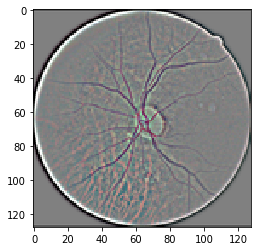

In [24]:
plt.imshow(xtrain[0])

In [25]:
from numpy import asarray
from numpy import save

data = asarray(xtrain)
save('California Healthcare Foundation/train/xtrainchf128c.npy', data)